# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Final Project: Police Violence Investigation

### Models and Supporting Analysis

**Harvard University**<br/>
**Fall 2020**<br/>
**Team Members**: Chika Okafor, Vasco Meerman, Matthew Parker, and David Koupaei

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<hr style="height:2pt">

## README

### Layout
#### Section 1: Looking at the Datasets

* Goals
    * See the state of both datasets
    * Determine if any cleaning is necessary
    * Perform cleaning
    * Initial snapshot look for trends
    * Identify which predictors might be useful
    * Determine which dataset to use
    
#### Section 2:  Adding additional predictors

* Goals
    * Import and match our additional predictors to each case
    * Perform cleaning if needed
    * Create new categorical predictors from the additional predictors

    
#### Section 3: Make some Plots

* Goals
    * Start to generate plots
    * Continue EDA on primarily the Washington Post Dataset
    
    
#### Section 4: Initial look at models

* Goals
    * Now that the data is understood, take a look at initial models
    * Try a few options and review for feasibility and utility
    
#### Section 5: Extending Models Further

* Goals
    * Based on initial results of very little correlation with year and race for violent police shooting events, this section will switch gears to attempt to predict other items.  

  *Models:*
 * Logistic Regression baseline
 * Polynomial Features (3rd order) Regression
 * Lasso Regularized Model
 * Random Forest
 * Neural Net
 
  *Predictions:*
 1. Predict race based on all other WaPo predictors. 
 2. Predict mental illness based on other WaPo predictors.
 3. Predict justification of shootings with police violence predictors
    
#### Section 6: Additional Models and Analysis   
 * Other Models Attempted:
  1. Predict mental illness based on other WaPo predictors.
  2. Predict justification of shootings with police violence predictors
  3. Adjusted model for mentall illness using different predictors
    

## Contents
- [Section 1: Looking at the Datasets](#section_1) 
- [Section 2: Adding additional predictors](#section_2) 
- [Section 3: Make some Plots!](#section_3)
- [Section 4: Initial Look at Models](#section_4)
- [Section 5: Extending the Models](#section_5)
- [Section 6: Supporting Models and Other Analysis](#section_6)
<hr style="height:2pt">





In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Lasso
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, auc
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping

from linearmodels import PanelOLS
import statsmodels.formula.api as smf

import reverse_geocode
import missingno as msno 

import geopandas as gpd
from scipy.spatial import cKDTree
from shapely.geometry import Point

%matplotlib inline

sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

/Users/rocketman-parker/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/rocketman-parker/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/rocketman-parker/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [3]:
# Random state for this project
random_state = 42


## Information about the datasets

#### Washingpost dataset
In 2015, The Post began tracking more than a dozen details about each killing — including the race of the deceased, the circumstances of the shooting, whether the person was armed and whether the person was experiencing a mental-health crisis — by culling local news reports, law enforcement websites and social media, and by monitoring independent databases such as Killed by Police and Fatal Encounters. The Post conducted additional reporting in many cases.

#### Mapping Police Violence
This information has been meticulously sourced from the three largest, most comprehensive and impartial crowdsourced databases on police killings in the country: FatalEncounters.org, the U.S. Police Shootings Database and KilledbyPolice.net. 

#### Important notes
The mapping police violence dataset has more predictors and data entries which could still be of interest for this analysis, but it also has some NaN values and incomplete data. Washington Post sources their data from the mapping police violence and that datasets that mapping police violence also uses, but they cleaned the data more completely making it more useful for many required comparisons in this investigation. Therefore, the best data source to answer the proposed analysis questions is the Washington Post dataset.

In [4]:
# Data dir path from root of project
data_dir = "../../data"

# Load data
mpv_df = pd.read_csv(f'{data_dir}/mapping-police-violence-24oct2020.csv')
# https://github.com/washingtonpost/data-police-shootings
wsp_df = pd.read_csv(f'{data_dir}/fatal-police-shootings-data-wsp.csv')

# Population Data
population_df = pd.read_csv(f'{data_dir}/nst-est2019-alldata.csv')

print(f"{len(mpv_df)} mapping police violence samples")
print(f"{len(wsp_df)} Washington Post Fatal Police Shootings samples")
print("\nMapping Columns:")
print(', '.join(mpv_df.columns))
print("\nWaPo Fatal Shootings Columns:")
print(', '.join(wsp_df.columns))

8507 mapping police violence samples
5716 Washington Post Fatal Police Shootings samples

Mapping Columns:
Victim's name, Victim's age, Victim's gender, Victim's race, URL of image of victim, Date of Incident (month/day/year), Street Address of Incident, City, State, Zipcode, County, Agency responsible for death, ORI Agency Identifier (if available), Cause of death, A brief description of the circumstances surrounding the death, Official disposition of death (justified or other), Criminal Charges?, Link to news article or photo of official document, Symptoms of mental illness?, Unarmed/Did Not Have an Actual Weapon, Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database), Alleged Threat Level (Source: WaPo), Fleeing (Source: WaPo), Body Camera (Source: WaPo), WaPo ID (If included in WaPo database), Off-Duty Killing?, Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-content/uploads/2015/05/full-ZCTA-urban-suburban-rura

## <div class='exercise' id='section_1'><b>Section 1: Looking at the Datasets</b></div>
[▲ Return to contents](#Contents)
<div class='exercise'>
    

    
</div>

In [5]:
display(mpv_df.head())
display(mpv_df.info())
display(mpv_df.describe())
print("Police Mapping Dataset size is:", mpv_df.shape)


,Victim's name,Victim's age,Victim's gender,Victim's race,URL of image of victim,Date of Incident (month/day/year),Street Address of Incident,City,State,Zipcode,County,Agency responsible for death,ORI Agency Identifier (if available),Cause of death,A brief description of the circumstances surrounding the death,Official disposition of death (justified or other),Criminal Charges?,Link to news article or photo of official document,Symptoms of mental illness?,Unarmed/Did Not Have an Actual Weapon,Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database),Alleged Threat Level (Source: WaPo),Fleeing (Source: WaPo),Body Camera (Source: WaPo),WaPo ID (If included in WaPo database),Off-Duty Killing?,Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-content/uploads/2015/05/full-ZCTA-urban-suburban-rural-classification.xlsx ),MPV ID,Fatal Encounters ID
0,Name withheld by police,NaN,Male,NaN,NaN,10/14/2020,NaN,Cookson,OK,NaN,Cherokee,Cherokee County Sheriff's Department,OK0110000,"Gunshot, Taser",A deputy responded to a disturbance called aro...,Pending investigation,No known charges,https://www.newson6.com/story/5f87912629c6bb05...,No,Allegedly Armed,spear,attack,Not fleeing,No,6232.0,NaN,NaN,NaN,NaN
1,Name withheld by police,NaN,Male,NaN,NaN,10/14/2020,NaN,South Los Angeles,CA,NaN,Los Angeles,Los Angeles Police Department,CA0194200,Gunshot,Around 9:50PM officers were driving by the 76 ...,Pending investigation,No known charges,https://ktla.com/news/local-news/lapd-suspect-...,No,Allegedly Armed,gun,attack,Not fleeing,No,6231.0,NaN,NaN,NaN,NaN
2,Name withheld by police,NaN,Male,White,NaN,10/14/2020,NaN,Chico,CA,NaN,Butte,Chico Police Department,CA0040200,Gunshot,A man who reportedly brandished a knife and th...,Pending investigation,No known charges,https://www.chicoer.com/2020/10/15/chico-polic...,No,Allegedly Armed,knife,attack,foot,No,6230.0,NaN,NaN,NaN,NaN
3,Marcos Ramirez,27,Male,Hispanic,NaN,10/13/2020,NaN,Bakersfield,CA,NaN,Kern,Bakersfield Police Department,CA0150200,Gunshot,Bakersfield police shot and killed a man they ...,Pending investigation,No known charges,https://www.turnto23.com/news/crime/bpd-invest...,No,Allegedly Armed,knife,attack,foot,Yes,6228.0,NaN,NaN,NaN,NaN
4,Anthony Jones,24,Male,NaN,NaN,10/12/2020,NaN,Bethel Springs,TN,NaN,McNairy,NaN,NaN,Gunshot,Jones was shot in McNairy County after police ...,Pending investigation,No known charges,https://www.wkrn.com/news/tennessee-news/tenne...,No,Unarmed/Did Not Have an Actual Weapon,no object,other,car,No,6229.0,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8507 entries, 0 to 8506
Data columns (total 29 columns):
 #   Column                                                                                                                                                                      Non-Null Count  Dtype  
---  ------                                                                                                                                                                      --------------  -----  
 0   Victim's name                                                                                                                                                               8507 non-null   object 
 1   Victim's age                                                                                                                                                                8492 non-null   object 
 2   Victim's gender                                                                     

None

,Zipcode,WaPo ID (If included in WaPo database),MPV ID,Fatal Encounters ID
count,8465.000000,5592.000000,8485.000000,8417.000000
mean,60584.679622,3116.519134,4261.408721,20024.425686
std,28088.279417,1765.307092,2454.204918,5196.315249
min,1085.000000,3.000000,1.000000,350.000000
25%,33525.000000,1591.750000,2139.000000,15550.000000
50%,67203.000000,3111.500000,4262.000000,18525.000000
75%,85756.000000,4639.250000,6386.000000,25052.000000
max,99801.000000,6232.000000,8511.000000,28933.000000


Police Mapping Dataset size is: (8507, 29)


### Checking for nan values

In [6]:
# Custom function to get nan stats for empty rows
def nan_row_stats(df_missing):
    # Get the rows with all null values
    idx = df_missing.index[df_missing.isnull().all(1)]
    nans = df_missing.iloc[idx]
    if len(nans) > 1:
        print("Dataframe has rows with each column value being empty")
        display(nans)
    else:
        print(f"Dataframe with {len(df_missing)} rows, does not have rows with all empty values")
        
# Custom function to get nan stats for values
def nan_vals_stats(df_missing, show_summary=False, show_rows=False):
    # Get the missing values per each column 
    missing_series = df_missing.isna().sum()

    # Concatunate each column's type so we have a better idea for imputation
    missing_types_df = pd.concat([missing_series.rename('Missing'), df_missing.dtypes.rename('Dtype')], axis=1)
    missing_types_df.sort_values(by=['Missing'], ascending=False, inplace=True)
    display(missing_types_df)
    
    # Get the column names where values are missing
    missing_colnames = missing_types_df[missing_types_df['Missing']>0].index.tolist()
    
    if len(missing_colnames) > 0:
        # Output missing column's stats for imputaiton 
        if show_summary:
            # Get the basic information of our missing columns
            display(df_missing[missing_colnames].describe())

        # Also output missing rows, needed to determine adequate imputation method
        if show_rows:
            null_data_df = df_missing[df_missing.isnull().any(axis=1)]
            display(null_data_df)

In [7]:
# rename a few annoying columns
mpv_df.rename(columns={'Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-content/uploads/2015/05/full-ZCTA-urban-suburban-rural-classification.xlsx )':'geography'}, inplace=True)
mpv_df.rename(columns={'Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database)':'Alleged Weapon'}, inplace=True)


# Check for nan values
nan_row_stats(mpv_df)
nan_vals_stats(mpv_df)


Dataframe with 8507 rows, does not have rows with all empty values


,Missing,Dtype
Off-Duty Killing?,8268,object
URL of image of victim,3939,object
Body Camera (Source: WaPo),2996,object
WaPo ID (If included in WaPo database),2915,float64
Fleeing (Source: WaPo),2893,object
Alleged Threat Level (Source: WaPo),2451,object
Street Address of Incident,95,object
Fatal Encounters ID,90,float64
Zipcode,42,float64
MPV ID,22,float64


<AxesSubplot:>

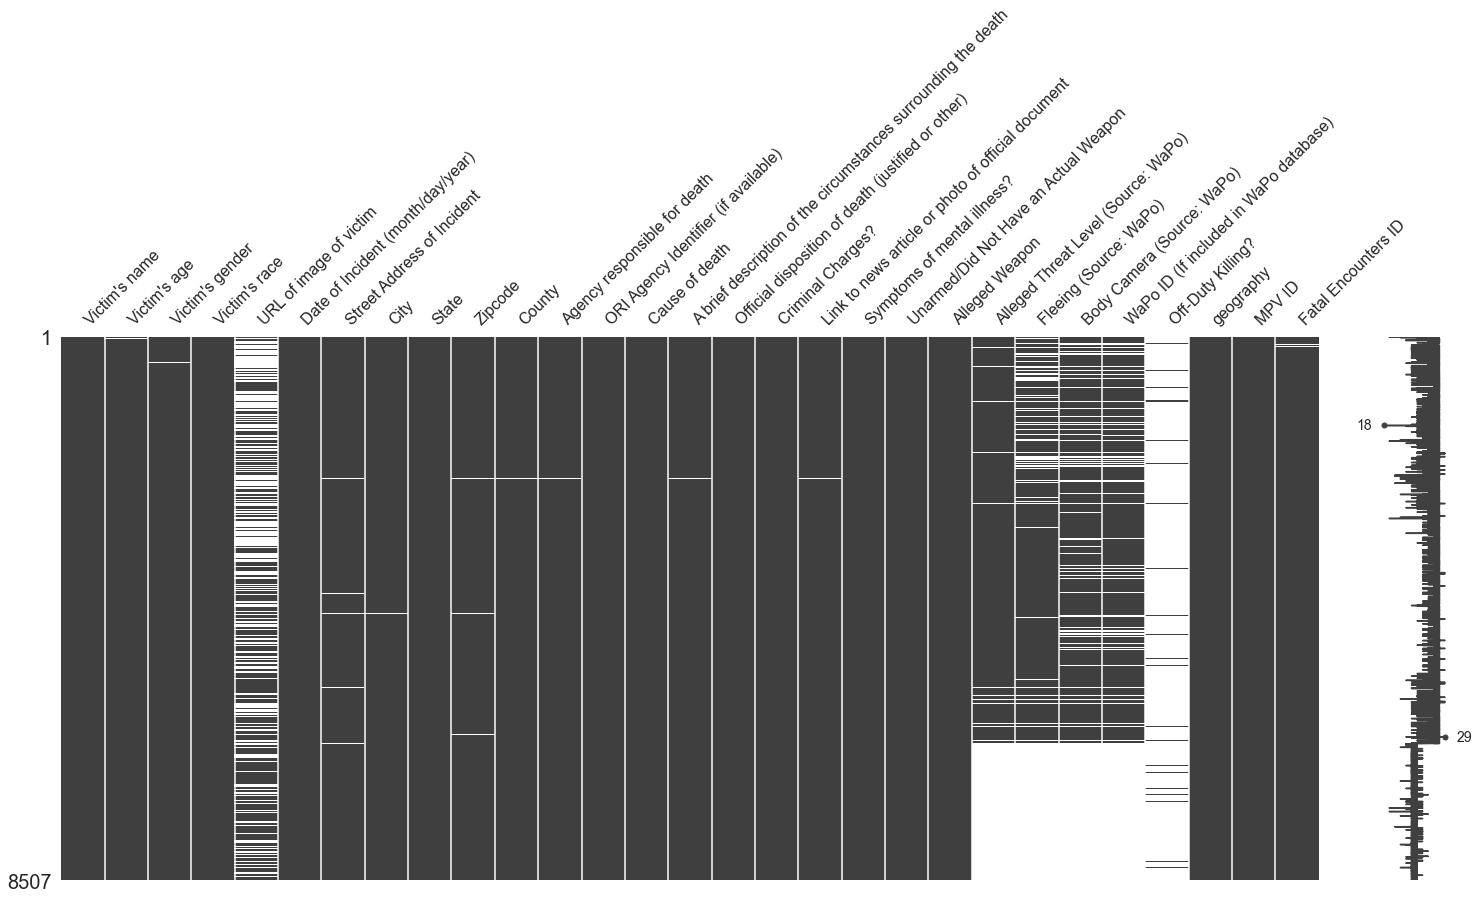

In [8]:
# Program to visualize missing values in dataset 


# Visualize missing values as a matrix 
msno.matrix(mpv_df) 

### Dropping some of the columns which have too many N/A or don't really help us

In [9]:
# Creating a new df for mutation of the data
df1 = mpv_df

# not used and lots of missing
df1.drop('URL of image of victim', axis=1, inplace=True)

# almost all NaN
df1.drop('Off-Duty Killing?', axis=1, inplace=True)

# not really used
df1.drop(['Street Address of Incident',
                'A brief description of the circumstances surrounding the death',
                "Victim's name",
                'Link to news article or photo of official document',
                'ORI Agency Identifier (if available)'],
                axis=1, inplace=True)

# rename a few annoying columns
df1.rename(columns={'Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-content/uploads/2015/05/full-ZCTA-urban-suburban-rural-classification.xlsx )':'geography'}, inplace=True)
df1.rename(columns={'Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database)':'Alleged Weapon'}, inplace=True)

# fix a few of the duplicate groupings

df1['Symptoms of mental illness?'] = df1['Symptoms of mental illness?'].str.replace('unknown', 'Unknown')
df1['Symptoms of mental illness?'] = df1['Symptoms of mental illness?'].str.replace('Unkown', 'Unknown')

df1['Alleged Threat Level (Source: WaPo)'] = df1['Alleged Threat Level (Source: WaPo)'].str.replace('Other', 'other')

df1['Fleeing (Source: WaPo)'] = df1['Fleeing (Source: WaPo)'].str.replace('other', 'Other')
df1['Fleeing (Source: WaPo)'] = df1['Fleeing (Source: WaPo)'].str.replace('not fleeing', 'Not fleeing')
df1['Fleeing (Source: WaPo)'] = df1['Fleeing (Source: WaPo)'].str.replace('Not Fleeing', 'Not fleeing')
df1['Fleeing (Source: WaPo)'] = df1['Fleeing (Source: WaPo)'].str.replace('foot', 'Foot')
df1['Fleeing (Source: WaPo)'] = df1['Fleeing (Source: WaPo)'].str.replace('car', 'Car')

df1['Body Camera (Source: WaPo)'] = df1['Body Camera (Source: WaPo)'].str.replace('no', 'No')
df1['Body Camera (Source: WaPo)'] = df1['Body Camera (Source: WaPo)'].str.replace('Dashcam video', 'Dashcam Video')


### Now see what needs further cleaning

In [10]:
for col in df1.columns:
    display(df1[col].value_counts())

25         279
31         275
27         268
Unknown    268
28         266
          ... 
40s          1
7            1
107          1
93           1
95           1
Name: Victim's age, Length: 88, dtype: int64

Male           8055
Female          425
Transgender       9
Unknown           4
Male              1
Name: Victim's gender, dtype: int64

White               3739
Black               2138
Hispanic            1467
Unknown race         863
Asian                131
Native American      119
Pacific Islander      46
Name: Victim's race, dtype: int64

6/16/2013     10
5/3/2020       9
6/8/2013       9
1/24/2017      9
2/1/2018       9
              ..
9/17/2020      1
6/18/2015      1
11/24/2018     1
2/5/2019       1
12/25/2015     1
Name: Date of Incident (month/day/year), Length: 2675, dtype: int64

Phoenix          121
Los Angeles      121
Houston          109
Chicago           84
San Antonio       66
                ... 
Bass River         1
Bay St. Louis      1
Buckley            1
Springtown         1
Ithaca             1
Name: City, Length: 3102, dtype: int64

CA    1312
TX     785
FL     613
AZ     376
GA     299
CO     267
WA     245
OK     236
NC     236
OH     229
MO     226
TN     201
IL     190
PA     185
NY     174
LA     167
NM     158
AL     153
NV     144
IN     141
MD     139
KY     137
VA     136
SC     133
MI     133
WI     125
OR     124
AR     117
MS     115
NJ     113
UT      94
MN      92
KS      80
WV      76
MA      58
ID      53
IA      52
MT      48
AK      47
CT      40
NE      39
HI      39
ME      34
DC      27
SD      26
WY      22
DE      21
NH      18
ND      14
VT      12
RI       6
Name: State, dtype: int64

88001.0    11
93307.0    10
90044.0    10
87121.0    10
85009.0    10
           ..
30428.0     1
78942.0     1
67132.0     1
85085.0     1
37888.0     1
Name: Zipcode, Length: 5329, dtype: int64

Los Angeles    361
Maricopa       231
Harris         136
Jefferson      124
Orange         123
              ... 
McLean           1
Dinwiddie        1
Grand            1
Gaines           1
Duchesne         1
Name: County, Length: 1152, dtype: int64

Los Angeles Police Department                           132
Phoenix Police Department                               116
Los Angeles County Sheriff's Department                 101
Chicago Police Department                                81
New York Police Department                               79
                                                       ... 
Copperas Cove Police Department                           1
Addis Police Department                                   1
Cascade County Sheriff's Office                           1
Saginaw Township Police Department                        1
Forney Police Department, Mesquite Police Department      1
Name: Agency responsible for death, Length: 3091, dtype: int64

Gunshot                                    7833
Gunshot, Taser                              253
Taser                                       247
Vehicle                                      44
Beaten                                       31
Physical Restraint                           25
Tasered                                      18
Asphyxiated                                   9
Physical restraint                            9
Gunshot, Police Dog                           5
Other                                         5
Gunshot, Pepper Spray                         4
Pepper Spray                                  4
Bean bag                                      2
Taser, Physical Restraint                     2
Taser, Baton                                  1
Chemical agent/Pepper spray                   1
Bomb                                          1
Taser, Beaten                                 1
Gunshot, Taser, Pepper spray                  1
Taser, Pepper Spray, Beaten             

Pending investigation/No Known Charges                                   4862
Unreported                                                               1225
Justified                                                                 651
Pending investigation                                                     446
Justified by District Attorney                                            350
                                                                         ... 
Justified by District Attorney/Civil Suit/Family awarded money              1
Charged, Convicted of 2nd degree manslaughter, Sentenced to 4 years         1
Charged with manslaughter, Charges Tossed under Stand Your Ground law       1
Justified by County Prosecuting Attorney                                    1
Charged, Convicted of voluntary manslaughter, Sentenced to 6 years          1
Name: Official disposition of death (justified or other), Length: 145, dtype: int64

No known charges                                                                 8361
Charged with a crime                                                               69
Charged, Acquitted                                                                 29
Charged, Mistrial                                                                   6
Charged, Charges Dropped                                                            5
Charged, Convicted                                                                  4
Charged, Convicted, Sentenced to 5 years probation.                                 2
Charged, Convicted, Sentenced to life in prison                                     2
Charged, Convicted, Sentenced to 30 years in prison                                 2
Charged, Convicted, Sentenced to 40 years in prison                                 1
Charged, Convicted, Sentenced to 25 years in prison                                 1
Charged, Convicted, Sentenced to Life in Prison       

No                     5415
Yes                    1598
Unknown                1164
Drug or alcohol use     318
Unknown                   1
Name: Symptoms of mental illness?, dtype: int64

Allegedly Armed                          6084
Unarmed/Did Not Have an Actual Weapon    1164
Unclear                                   697
Vehicle                                   562
Name: Unarmed/Did Not Have an Actual Weapon, dtype: int64

gun                        4432
knife                      1129
no object                   888
undetermined                532
vehicle                     499
                           ... 
club                          1
wooden stick                  1
carjack                       1
baseball bat and bottle       1
barstool                      1
Name: Alleged Weapon, Length: 170, dtype: int64

attack          3922
other           1803
undetermined     331
Name: Alleged Threat Level (Source: WaPo), dtype: int64

Not fleeing    3770
Car             937
Foot            732
Other           175
Name: Fleeing (Source: WaPo), dtype: int64

No                    4905
Yes                    592
Surveillance Video       5
Bystander Video          4
Dashcam Video            3
Surveillance video       2
Name: Body Camera (Source: WaPo), dtype: int64

3232.0    2
3784.0    2
6117.0    2
3516.0    2
4731.0    1
         ..
6020.0    1
4650.0    1
3766.0    1
3226.0    1
6144.0    1
Name: WaPo ID (If included in WaPo database), Length: 5588, dtype: int64

Suburban        4240
Urban           2287
Rural           1899
Undetermined      73
Name: geography, dtype: int64

5972.0    2
4603.0    1
4629.0    1
497.0     1
590.0     1
         ..
2906.0    1
2268.0    1
2129.0    1
1794.0    1
8448.0    1
Name: MPV ID, Length: 8484, dtype: int64

28926.0    2
24323.0    2
28921.0    2
28920.0    2
20232.0    1
          ..
25960.0    1
14498.0    1
17377.0    1
14854.0    1
28160.0    1
Name: Fatal Encounters ID, Length: 8413, dtype: int64

### Taking a look at the victim's race

In [11]:
df1["Victim's race"].value_counts()

White               3739
Black               2138
Hispanic            1467
Unknown race         863
Asian                131
Native American      119
Pacific Islander      46
Name: Victim's race, dtype: int64

### Where are most of the events taking place?


In [12]:
display(df1["State"].value_counts())
display(df1["City"].value_counts())

CA    1312
TX     785
FL     613
AZ     376
GA     299
CO     267
WA     245
OK     236
NC     236
OH     229
MO     226
TN     201
IL     190
PA     185
NY     174
LA     167
NM     158
AL     153
NV     144
IN     141
MD     139
KY     137
VA     136
SC     133
MI     133
WI     125
OR     124
AR     117
MS     115
NJ     113
UT      94
MN      92
KS      80
WV      76
MA      58
ID      53
IA      52
MT      48
AK      47
CT      40
NE      39
HI      39
ME      34
DC      27
SD      26
WY      22
DE      21
NH      18
ND      14
VT      12
RI       6
Name: State, dtype: int64

Phoenix          121
Los Angeles      121
Houston          109
Chicago           84
San Antonio       66
                ... 
Bass River         1
Bay St. Louis      1
Buckley            1
Springtown         1
Ithaca             1
Name: City, Length: 3102, dtype: int64

### Cleaning up some predictors

In [13]:
df1['Cause of death'] = df1['Cause of death'].str.replace('Tasered', 'Taser')
df1['Cause of death'] = df1['Cause of death'].str.replace('Taser, Beaten', 'Taser')
df1['Cause of death'] = df1['Cause of death'].str.replace('Taser, Baton', 'Taser')
df1['Cause of death'] = df1['Cause of death'].str.replace('Taser, Physical Restraint', 'Taser')
df1['Cause of death'] = df1['Cause of death'].str.replace('Taser, Pepper Spray, Beaten', 'Taser')
df1['Cause of death'] = df1['Cause of death'].str.replace('Taser, Pepper spray, beaten', 'Taser')

df1['Cause of death'] = df1['Cause of death'].str.replace('Gunshot, Police Dog', 'Gunshot')
df1['Cause of death'] = df1['Cause of death'].str.replace('Gunshot, Taser', 'Gunshot')
df1['Cause of death'] = df1['Cause of death'].str.replace('Gunshot, Pepper Spray', 'Gunshot')
df1['Cause of death'] = df1['Cause of death'].str.replace('Gunshot, Pepper spray', 'Gunshot')
df1['Cause of death'] = df1['Cause of death'].str.replace('Gunshot, Pepper Spray', 'Gunshot')
df1['Cause of death'] = df1['Cause of death'].str.replace('Gunshot, Bean Bag Gun', 'Gunshot')
df1['Cause of death'] = df1['Cause of death'].str.replace('Gunshot, Beanbag Gun', 'Gunshot')
df1['Cause of death'] = df1['Cause of death'].str.replace('Gunshot, Beanbag Shotgun', 'Gunshot')
df1['Cause of death'] = df1['Cause of death'].str.replace('Gunshot, Stabbed', 'Gunshot')
df1['Cause of death'] = df1['Cause of death'].str.replace('Gunshot, Unspecified Less Lethal Weapon', 'Gunshot')
df1['Cause of death'] = df1['Cause of death'].str.replace('Gunshot, Vehicle', 'Gunshot')

df1['Cause of death'] = df1['Cause of death'].str.replace('Physical restraint', 'Physical Restraint')
df1['Cause of death'] = df1['Cause of death'].str.replace('Baton, Pepper Spray, Physical Restraint', 'Beaten')
df1['Cause of death'] = df1['Cause of death'].str.replace('Beaten/Bludgeoned with instrument', 'Beaten')
df1['Cause of death'] = df1['Cause of death'].str.replace('Chemical agent/Pepper spray ', 'Pepper Spray')



df1['Cause of death'].value_counts()


Gunshot                        8103
Taser                           271
Vehicle                          44
Physical Restraint               34
Beaten                           33
Asphyxiated                       9
Other                             5
Pepper Spray                      4
Bean bag                          2
Bomb                              1
Chemical agent/Pepper spray       1
Name: Cause of death, dtype: int64

In [14]:
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 5 years probation.', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 30 years in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to life in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 1 year in prison and 4 years probation', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 40 years in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 16 years in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 5 years in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 6 years', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 1 year in jail, 3 years suspended', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted without parole, plus 16 years', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 14 years in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 7 years in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 12 years in prison and 8 years in probation', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 20 years in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 2.5 years in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 3 years probation', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 25 years in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 50 years', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 4 years', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted of reckless homicide, sentenced to 1 year in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 3 months in jail ', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 1 year in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 10 years in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 40 years to Life in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted ', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to Life in Prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 3 months in jail', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Plead No Contest, Sentenced to 10 years probation', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 18 months', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convictedin prison', 'Charged, Convicted')

df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Charges Dropped', 'Charged, Acquitted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged with a crime, Acquitted', 'Charged, Acquitted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Mistrial, Plead Guilty to Civil Rights Charges', 'Charged, Mistrial')


display(df1["Criminal Charges?"].value_counts())

No known charges        8361
Charged with a crime      69
Charged, Convicted        35
Charged, Acquitted        35
Charged, Mistrial          7
Name: Criminal Charges?, dtype: int64

In [15]:
df1["Symptoms of mental illness?"] = df1["Symptoms of mental illness?"].str.replace('Unknown ', 'Unknown')
df1["Symptoms of mental illness?"] = df1["Symptoms of mental illness?"].str.replace('nan', 'Unknown')
display(df1["Symptoms of mental illness?"].value_counts())

No                     5415
Yes                    1598
Unknown                1165
Drug or alcohol use     318
Name: Symptoms of mental illness?, dtype: int64

In [16]:
display(df1["Unarmed/Did Not Have an Actual Weapon"].value_counts())

Allegedly Armed                          6084
Unarmed/Did Not Have an Actual Weapon    1164
Unclear                                   697
Vehicle                                   562
Name: Unarmed/Did Not Have an Actual Weapon, dtype: int64

In [17]:
display(df1["Fleeing (Source: WaPo)"].value_counts())

Not fleeing    3770
Car             937
Foot            732
Other           175
Name: Fleeing (Source: WaPo), dtype: int64

In [18]:
df1["Body Camera (Source: WaPo)"] = df1["Body Camera (Source: WaPo)"].str.replace('Surveillance video', 'Surveillance Video')
df1["Body Camera (Source: WaPo)"] = df1["Body Camera (Source: WaPo)"].str.replace('nan', 'Unknown')

display(df1["Body Camera (Source: WaPo)"].value_counts())

No                    4905
Yes                    592
Surveillance Video       7
Bystander Video          4
Dashcam Video            3
Name: Body Camera (Source: WaPo), dtype: int64

In [19]:
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with murder, aquitted', 'Charged, Aquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted, Sentenced to 18 months', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with criminally negligent homicide, Acquitted', 'Charged, Aquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by District Attorney/Civil suit/Pending', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified by County Commonwealth's Attorney", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified by District Attorney", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with manslaughter, Charges Tossed under Stand Your Ground law', 'Charged, Aquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with murder and aggravated assault', 'Charged, Aquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, charges dismissed', 'Charged, Aquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted of murder, Sentenced to 30 years in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Pending investigation/No Known Charges; Minnesota Bureau of Criminal Apprehension, Minnesota State Patrol, Anoka County Sheriff's Office, Fridley Police Department, Lino Lakes Police Department", 'Pending investigation/No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Pending investigation', 'Pending investigation/No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted of murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted of involuntary manslaugher, Sentenced to 1 year in jail, 3 years suspended', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with murder and involuntary manslaughter, Convicted, Sentenced to Life in Prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by County Prosecuting Attorney', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, convicted of manslaughter', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted, Sentenced to 5 years in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted, Sentenced to five years probation.', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with murder, Convicted of manslaughter, Sentenced to 14 years in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with negligent homicide', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified/Civil Suit/Family awarded money', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified; New York State Police investigation; Schwalm's brother offered condolences to the deputy because of his brother's illness.", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted of involuntary manslaughter, Sentenced to 5 years in Prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted of reckless manslaughter, Sentenced to 6 years', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted of felony murder, Sentenced to life without parole, plus 16 years', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Unjustified, Officer fired', 'Pending investigation/No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with manslaughter, Plead no contest, Sentenced to 10 years probation', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Pending investigation/No Known Charges/No Known Charges/No Known Charges/No Known Charges/No Known Charges', 'No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with murder, Convicted of aggravated assault, violating the oath of his office and making a false statement, Sentenced to 12 years in prison and 8 years probation ', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('unknown', 'Unknown')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('No Known Charges/No Known Charges', 'Pending investigation/No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Cleared by coroner's inquest/Civil suit/Family awarded money", 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted of misdemeanor misconduct in office, Sentenced to 3 years probation', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted and malfeasance', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by external agency', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted of second-degree murder, Sentenced to 20 years in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with manslaughter, Mistrial', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted ', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with first-degree murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with 3rd degree murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with reckless homicide, Acquitted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted, Acquitted', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Pending investigation/No Known Charges/No Known Charges', 'Pending investigation/No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with murder, possession of a firearm during the commission of a crime and violation of oath', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified by State's Attorney/Civil suit/Pending", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Grand jury/No bill or Cleared/Justified', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof manslaughter and attempted murder, Sentenced to 25 years', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof voluntary manslaughter, Sentenced to 6 years', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Unjustified by internal review', 'Unjustified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Charged, Mistrial declared, Pled Guilty for Violating Walter Scott's Civil Rights", 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Grand jury/No bill or Cleared', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof voluntary manslaughter, Sentenced to 3 months in jail', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with involuntary manslaughter, Acquitted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with 2nd degreee murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof misdemeanor reckless conduct with a firearm, Sentenced to 1 year in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with 1st degree wanton endangerment', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by Prosecutor', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with felony negligent homicide, Acquitted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by Department of Justice', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified by State's Attorney", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('No Known Chargess', 'Pending investigation/No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof aggravated manslaughter and child endangerment, Sentenced to 30 years in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with murder, Convicted of aggravated assault, violating the oath of his office and making a false statement, Sentenced to 12 years in prison and 8 years probation', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof manslaughter, Sentenced to 2.5 years in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified by coroner's inquest", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by Attorney General', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof Third Degree Murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with manslaughter and reckless discharge of firearm', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof first-degree murder, Sentenced to life in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by Fifth Judicial Circuit Solicitor', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with murder, Ruled not guilty by reason of insanity', 'Charged, Acquittted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Acquittted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with homicide and felony firearm charges, Acquitted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with criminal homicide, assault, and reckless endangerment', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof felony murder, Sentenced to life in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof reckless homicide, sentenced to 1 year in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with manslaughter, Convicted of violating oath of office, Sentenced to 1 year in prison and 4 years probation', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with voluntary manslaughter', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with involuntary manslaughter, Plead Guilty to Involuntary Manslaughter, Sentenced to 7 years in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof 2nd degree manslaughter, Sentenced to 4 years', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Murder / Suicide', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with 2nd degree murder or first degree manslaughter', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof second-degree manslaughter and one count of official misconduct, Sentenced to five years probation.', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with manslaughter, acquitted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified by State Attorney's Office", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted, Sentenced to 50 years', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged and Civil suit/Family awarded money', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('No Known Charges; Snohomish County Multiagency Response Team', 'Pending investigation/No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('No Known Charges ', 'No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with second-degree murder, Acquitted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged witth 1st degree manslaughter, Acquitted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with manslaughter, Charges Dismissed in Federal Court', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with 1st degree murder, armed criminal action and two counts of child endangerment, Acquitted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by U.S. Attorney', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with murder and attemped murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Unjustified', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted, Sentenced to 10 years in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified by County Prosecutor's Office", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with involuntary manslaughter', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with 1st degree murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Pending investigaton', 'No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified by County State's Attorney", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Cleared by district attorney', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by Special Prosecutor', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Administrative discipline/Civil suit/Family awarded money', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with manslaughter, Charges Dropped', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified by Solicitor's Office", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof second-degree murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified/Civil suit/Family awarded money', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Ruled accidental', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('No Known Charges; Georgia Bureau of Investigation', 'Pending investigation/No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with homicide', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by outside agency/Civil suit/Family awarded money', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Other justified (Civilian board/Prosecutor/District Attorney/Coroner)', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Accidental', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with a crime', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by Solicitor', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with 2nd degree murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Civil suit/Pending', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with murder, Acquitted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Cleared', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with second-degree murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Other justified (Civilian board/Prosecutor/District Attorney/Coroner) ', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Mistrial declared', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Aquitted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Administrative discipline', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified's Office", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by Prosecuting Attorney', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified by Commonwealth's Attorney", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Found Excusable', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with manslaughter, Acquitted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Other justified (Civilian board/Prosecutor/District Attorney/Coroner)", 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by County Attorney', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by State Attorney', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by outside agency', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by County Prosecutor', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Other justified (Civilian board/Coroner/Medical examiner) ', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Murder/suicide', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with manslaughter', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Civil suit/Family awarded money', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by internal review', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Under investigation', 'Pending investigation/No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedwith felony murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by Inspector General', 'Justified')




display(df1['Official disposition of death (justified or other)'].value_counts())

Pending investigation/Pending investigation/No Known Charges                          4865
Justified                                                                             1451
Unreported                                                                            1225
Pending investigation/No Known Charges                                                 460
Unknown                                                                                254
Charged, Convicted                                                                     151
Charged, Acquitted                                                                      56
Other justified (Civilian board/Coroner/Medical examiner)                               14
Charged                                                                                  9
Pending investigation/Pending investigation/Pending investigation/No Known Charges       4
Other justified (Civilian board/Prosecutor/District Attorney/Coroner)                    3

### Let's convert all the boolean predictors

In [20]:
# group all of the charges together for now
df1["Criminal Charges?_bool"]= df1["Criminal Charges?"].apply(lambda x: 0 if x=='No known charges' else 1)

# grouping all symptoms not classified as "yes"
df1["Symptoms of mental illness?_bool"]= df1["Symptoms of mental illness?"].apply(lambda x: 1 if x=='Yes' else 0)

# grouping all 'allegedly armed' as "yes" vs all other answers
df1["Unarmed/Did Not Have an Actual Weapon_bool"]= df1["Unarmed/Did Not Have an Actual Weapon"].apply(lambda x: 1 if x=='Allegedly Armed' else 0)

# grouping all spellings of 'not fleeing'
df1["Fleeing (Source: WaPo)_bool"]= df1["Fleeing (Source: WaPo)"].apply(lambda x: 0 if x in ['Not fleeing', 'not fleeing', 'Not Fleeing'] else 1)

# grouping all spellings of 'no'
df1["Body Camera (Source: WaPo)_bool"]= df1["Body Camera (Source: WaPo)"].apply(lambda x: 0 if x in ['No', 'no'] else 1)


In [21]:
display(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8507 entries, 0 to 8506
Data columns (total 27 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Victim's age                                        8492 non-null   object 
 1   Victim's gender                                     8494 non-null   object 
 2   Victim's race                                       8503 non-null   object 
 3   Date of Incident (month/day/year)                   8507 non-null   object 
 4   City                                                8501 non-null   object 
 5   State                                               8507 non-null   object 
 6   Zipcode                                             8465 non-null   float64
 7   County                                              8493 non-null   object 
 8   Agency responsible for death                        8491 non-null   object 
 9

None

### Recasting some datatypes

In [22]:
# Data type conversions

# age still has some odd values
# display(mpv_df["Victim's age"].head())
df1["Victim's age"] = mpv_df["Victim's age"].fillna(0)
#print(df1["Victim's age"].str.isdigit().sum())
df1["Victim's age"]= df1["Victim's age"].apply(lambda x: x if str(x).isdigit() else 0).astype("int")


# drop a few more NaN
#df1 = df1.fillna(str(0))
df1.dropna()

# recast some of the string categories as type string
df1["Victim's gender"] = df1["Victim's gender"].astype('str')
df1["Victim's race"] = df1["Victim's race"].astype('str')
df1["City"] = df1["City"].astype('str')
df1["State"] = df1["State"].astype('str')
df1["County"] = df1["County"].astype('str')
df1["Agency responsible for death"] = df1["Agency responsible for death"].astype('str')
df1["Cause of death"] = df1["Cause of death"].astype('str')
df1["Official disposition of death (justified or other)"] = df1["Official disposition of death (justified or other)"].astype('str')
df1["Symptoms of mental illness?"] = df1["Symptoms of mental illness?"].astype('str')
df1["Unarmed/Did Not Have an Actual Weapon"] = df1["Unarmed/Did Not Have an Actual Weapon"].astype('str')
df1["Alleged Weapon"] = df1["Alleged Weapon"].astype('str')
df1["Fleeing (Source: WaPo)"] = df1["Fleeing (Source: WaPo)"].astype('str')
df1["Body Camera (Source: WaPo)"] = df1["Body Camera (Source: WaPo)"].astype('str')
df1["Alleged Threat Level (Source: WaPo)"] = df1["Alleged Threat Level (Source: WaPo)"].astype('str')
df1["geography"] = df1["geography"].astype('str')

# Add year
df1['year'] = pd.DatetimeIndex(df1['Date of Incident (month/day/year)']).year


In [23]:
df1["Victim's gender"] = df1["Victim's gender"].str.replace('nan', 'Unknown')

display(df1["Victim's gender"].value_counts())

Male           8055
Female          425
Unknown          17
Transgender       9
Male              1
Name: Victim's gender, dtype: int64

### Some basic EDA

<AxesSubplot:>

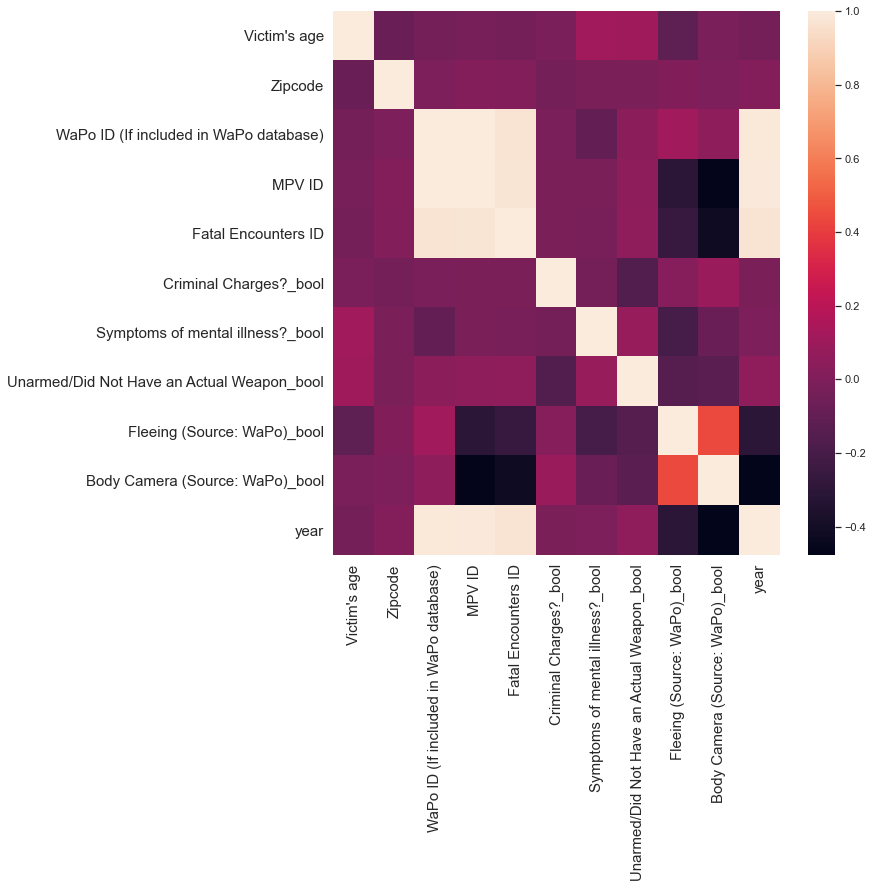

In [24]:
# your code here

# Calculate correlations
corr = df1.corr()

# Create our plot models
fig, ax = plt.subplots(figsize=(10,10)) 

# Set and rotate the labels for better readability 
ax.tick_params(axis='x', rotation=45,  labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)

# Show the heatmap
sns.heatmap(corr, ax=ax)

    

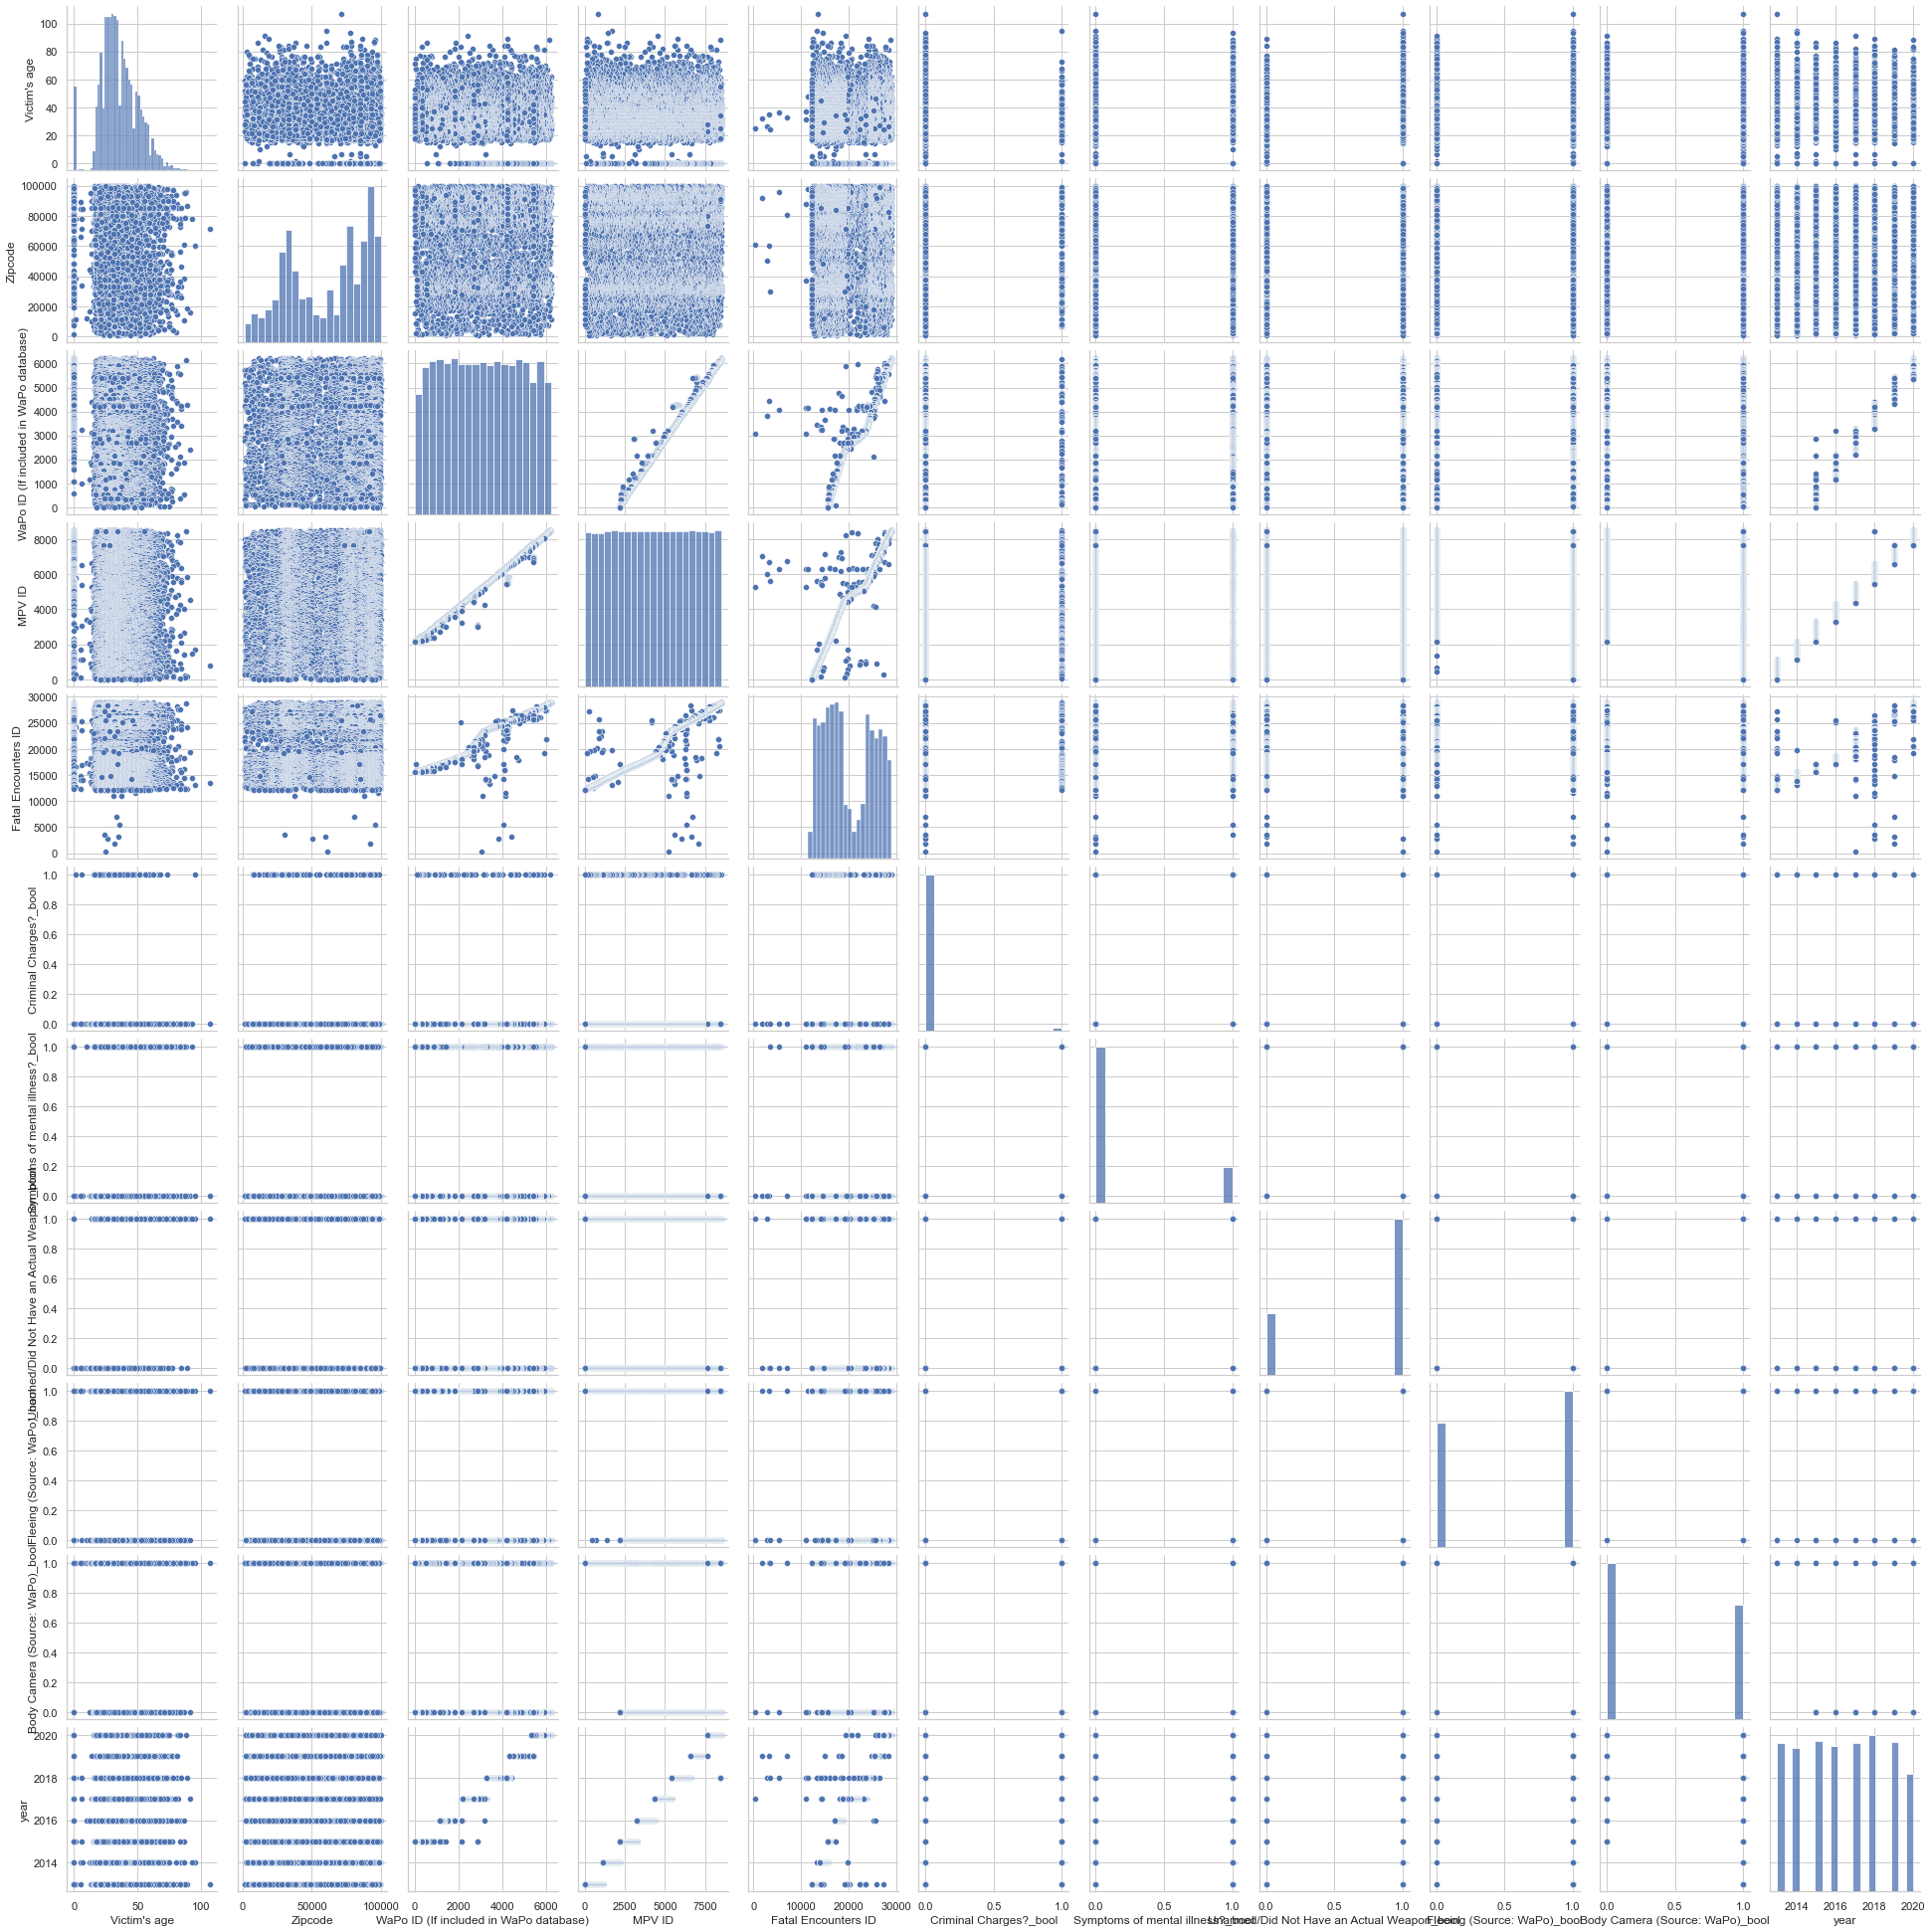

In [25]:
sns.pairplot(data=df1)


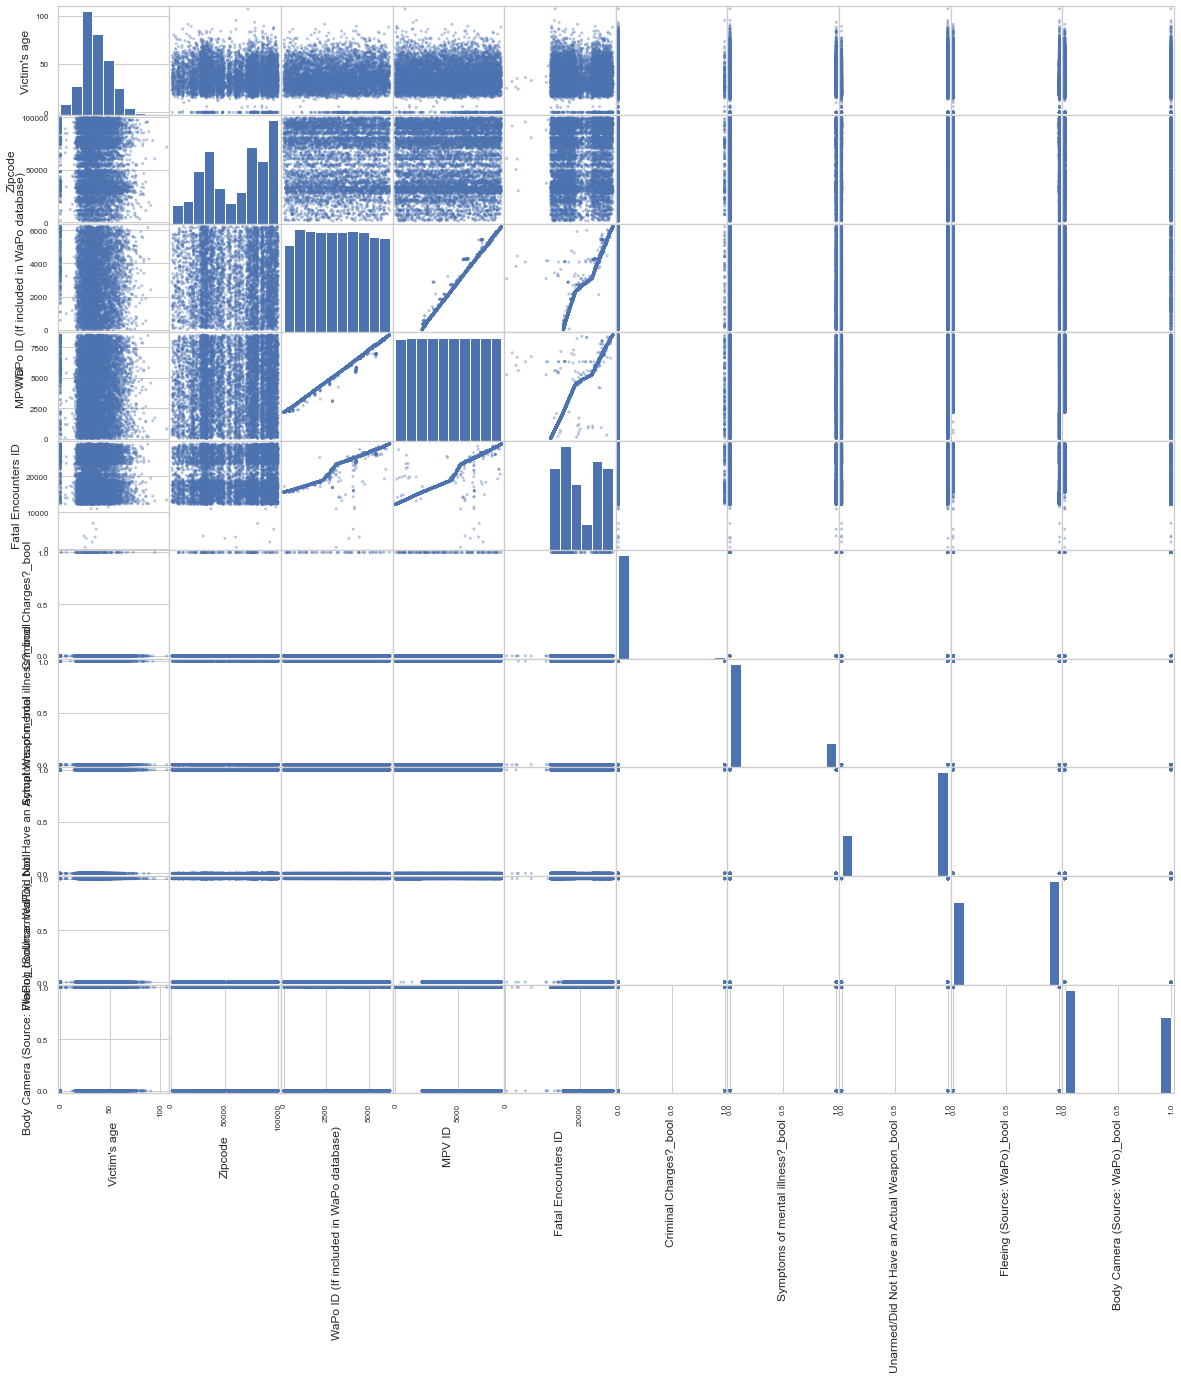

In [26]:
# check float features
grid_features = ["Victim's age", 'Zipcode', 'WaPo ID (If included in WaPo database)', 'MPV ID', 
                 'Fatal Encounters ID','Criminal Charges?_bool', 'Symptoms of mental illness?_bool',  
                 'Unarmed/Did Not Have an Actual Weapon_bool', 'Fleeing (Source: WaPo)_bool',
                 'Body Camera (Source: WaPo)_bool' ]

scatter = pd.plotting.scatter_matrix(df1[grid_features], alpha=0.4, figsize=(20,20));
for ax in scatter.ravel():
    ax.set_xlabel(ax.get_xlabel(), rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), rotation = 90)

##  Let's look at the Washington Post Data

The mapping police violence dataset has more predictors and data entries which could still be of interest for this analysis, but it also has some NaN values and incomplete data. Washington Post sources their data from the mapping police violence dataset, but they cleaned the data more completely making it more useful for many required comparisons in this investigation. Therefore, the best data source to answer the proposed analysis questions is the Washington Post dataset.

In [27]:
display(wsp_df.head())
display(wsp_df.describe())

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


,id,age,longitude,latitude
count,5716.000000,5456.000000,5437.000000,5437.000000
mean,3173.216235,37.139113,-97.256366,36.650508
std,1789.492388,13.068117,16.629368,5.367021
min,3.000000,6.000000,-158.137000,19.498000
25%,1624.750000,27.000000,-112.134000,33.477000
50%,3174.500000,35.000000,-94.432000,36.100000
75%,4734.250000,46.000000,-83.066000,39.958000
max,6247.000000,91.000000,-68.014000,71.301000


### Check overview information about the data


In [28]:
display(wsp_df.columns)

Index(['id', 'name', 'date', 'manner_of_death', 'armed', 'age', 'gender', 'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera', 'longitude', 'latitude', 'is_geocoding_exact'], dtype='object')

In [29]:
print('Dataset shape: ', wsp_df.shape)

wsp_df.info()

Dataset shape:  (5716, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5716 entries, 0 to 5715
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       5716 non-null   int64  
 1   name                     5499 non-null   object 
 2   date                     5716 non-null   object 
 3   manner_of_death          5716 non-null   object 
 4   armed                    5503 non-null   object 
 5   age                      5456 non-null   float64
 6   gender                   5715 non-null   object 
 7   race                     5109 non-null   object 
 8   city                     5716 non-null   object 
 9   state                    5716 non-null   object 
 10  signs_of_mental_illness  5716 non-null   bool   
 11  threat_level             5716 non-null   object 
 12  flee                     5426 non-null   object 
 13  body_camera              5716 non-null   bool   
 1

### Checking for nan values in the dataset


In [30]:
# Inspect nan values
nan_row_stats(wsp_df)
nan_vals_stats(wsp_df)


Dataframe with 5716 rows, does not have rows with all empty values


,Missing,Dtype
race,607,object
flee,290,object
latitude,279,float64
longitude,279,float64
age,260,float64
name,217,object
armed,213,object
gender,1,object
id,0,int64
threat_level,0,object


<AxesSubplot:>

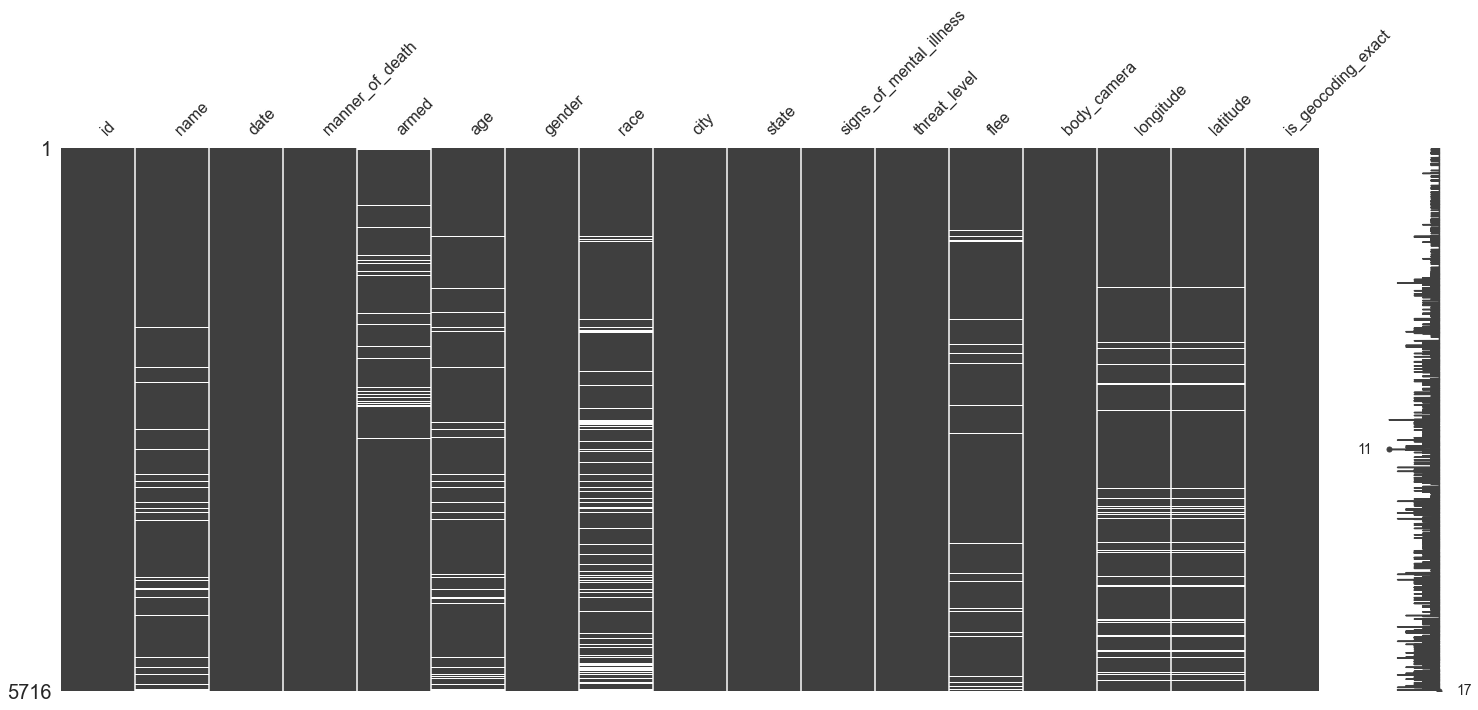

In [31]:
# Program to visualize missing values in dataset 

# Visualize missing values as a matrix 
msno.matrix(wsp_df) 

### Inspecting the data
Check value count info for all columns

In [32]:
for col in wsp_df.columns:
    display(wsp_df[col].value_counts())
    
    

2047    1
689     1
661     1
4759    1
2712    1
       ..
3431    1
5480    1
1386    1
3435    1
2049    1
Name: id, Length: 5716, dtype: int64

Michael Johnson           3
Joseph Santos             2
Jeffrey Sims              2
Brandon Jones             2
George Tillman            2
                         ..
Julian Hoffman            1
Talif Scudder             1
Matt Goff                 1
Trevon Johnson            1
Sean Michael Pelletier    1
Name: name, Length: 5482, dtype: int64

2018-01-06    9
2018-02-01    9
2019-01-28    9
2018-04-01    9
2020-05-26    9
             ..
2015-10-27    1
2016-08-22    1
2018-05-12    1
2016-05-27    1
2016-11-26    1
Name: date, Length: 1962, dtype: int64

shot                5427
shot and Tasered     289
Name: manner_of_death, dtype: int64

gun                       3252
knife                      846
unarmed                    359
toy weapon                 193
undetermined               177
                          ... 
grenade                      1
car, knife and mace          1
baseball bat and knife       1
metal rake                   1
barstool                     1
Name: armed, Length: 95, dtype: int64

31.0    195
25.0    189
27.0    183
32.0    177
33.0    177
       ... 
79.0      1
89.0      1
91.0      1
12.0      1
78.0      1
Name: age, Length: 78, dtype: int64

M    5463
F     252
Name: gender, dtype: int64

W    2595
B    1345
H     947
A      94
N      81
O      47
Name: race, dtype: int64

Los Angeles    89
Phoenix        80
Houston        61
Las Vegas      50
San Antonio    47
               ..
Pine County     1
Nitro           1
Hayti           1
Bemidji         1
Ithaca          1
Name: city, Length: 2565, dtype: int64

CA    853
TX    506
FL    379
AZ    262
CO    209
GA    197
OK    171
NC    168
WA    163
OH    159
TN    149
MO    146
LA    116
PA    113
NM    112
IL    109
NY    105
AL    105
NV    104
KY    103
IN    101
VA     97
WI     96
SC     93
OR     87
MI     86
AR     84
MD     81
NJ     71
UT     70
MS     67
MN     64
WV     56
KS     52
ID     43
AK     40
IA     36
MA     35
MT     34
HI     30
NE     25
ME     22
CT     21
SD     17
WY     14
DC     14
NH     13
DE     13
ND     12
VT      9
RI      4
Name: state, dtype: int64

False    4390
True     1326
Name: signs_of_mental_illness, dtype: int64

attack          3697
other           1763
undetermined     256
Name: threat_level, dtype: int64

Not fleeing    3567
Car             937
Foot            736
Other           186
Name: flee, dtype: int64

False    5029
True      687
Name: body_camera, dtype: int64

-112.134    7
-112.152    6
-111.978    5
-97.132     4
-118.457    4
           ..
-84.268     1
-71.518     1
-94.138     1
-80.537     1
-112.078    1
Name: longitude, Length: 4846, dtype: int64

33.495    8
33.415    7
33.480    7
33.568    5
34.033    5
         ..
43.131    1
31.375    1
31.125    1
34.500    1
28.500    1
Name: latitude, Length: 4401, dtype: int64

True     5708
False       8
Name: is_geocoding_exact, dtype: int64

In [33]:

display(wsp_df['manner_of_death'].value_counts())

shot                5427
shot and Tasered     289
Name: manner_of_death, dtype: int64

In [34]:
pd.set_option('display.max_rows', 20)

display(wsp_df['armed'].value_counts())
print(wsp_df['armed'].unique())

gun                       3252
knife                      846
unarmed                    359
toy weapon                 193
undetermined               177
                          ... 
grenade                      1
car, knife and mace          1
baseball bat and knife       1
metal rake                   1
barstool                     1
Name: armed, Length: 95, dtype: int64

['gun' 'unarmed' 'toy weapon' 'nail gun' 'knife' nan 'shovel' 'vehicle'
 'hammer' 'hatchet' 'sword' 'machete' 'box cutter' 'undetermined'
 'metal object' 'screwdriver' 'lawn mower blade' 'flagpole'
 'guns and explosives' 'cordless drill' 'crossbow' 'metal pole' 'Taser'
 'metal pipe' 'metal hand tool' 'blunt object' 'metal stick'
 'sharp object' 'meat cleaver' 'carjack' 'chain' "contractor's level"
 'unknown weapon' 'stapler' 'beer bottle' 'bean-bag gun'
 'baseball bat and fireplace poker' 'straight edge razor' 'gun and knife'
 'ax' 'brick' 'baseball bat' 'hand torch' 'chain saw' 'garden tool'
 'scissors' 'pole' 'pick-axe' 'flashlight' 'baton' 'spear' 'chair'
 'pitchfork' 'hatchet and gun' 'rock' 'piece of wood' 'bayonet' 'pipe'
 'glass shard' 'motorcycle' 'pepper spray' 'metal rake' 'crowbar' 'oar'
 'machete and gun' 'tire iron' 'air conditioner' 'pole and knife'
 'baseball bat and bottle' 'fireworks' 'pen' 'chainsaw' 'gun and sword'
 'gun and car' 'pellet gun' 'claimed to be armed' 'B

In [35]:
display(wsp_df['gender'].value_counts())

M    5463
F     252
Name: gender, dtype: int64

In [36]:
display(wsp_df['threat_level'].value_counts())

attack          3697
other           1763
undetermined     256
Name: threat_level, dtype: int64

In [37]:
display(wsp_df['race'].value_counts())

W    2595
B    1345
H     947
A      94
N      81
O      47
Name: race, dtype: int64

## <div class='exercise' id='section_2'><b>Section 2: Adding additional predictors</b></div>
[▲ Return to contents](#Contents)

By using external data sources, we are going to add more predictors which could yield more insightful predictions.  Below we list the predictors we are adding, along with the corresponding rationales behind their inclusion:
* Population Density: Used lat/long coordinates to identify location and subsequent population density.  The rationale behind adding this predictor is that we suspect that crime level might be correlated with population density and thereby also correlated with the race of the police victim. 
* Urban Classifier: Sorted population density by {urban, suburban, and rural}.  The rationale behind the inclusion of this variable is if we wanted population density as a categorical variable instead of a continuous variable.  This would allow us to understand in the Feature Importance analysis whether a particular category of urban center impacted the likelihood of the police shooting victim to be black.
* Political Party:  Selected political affiliation of the state and year by prior Presidential election results {Red State, Blue State}.  The rationale behind adding this predictor is that we suspect that there may be greater racial animus in areas where the political affiliation is more solidly Red.  This may translate to measurable differences in the incidence of black victims from police shootings.
* Average Income: Used zipcode of incident to determine the median income in that area.  The rationale behind adding this predictor was that low-income areas often map to areas with a greater proportion of minorities.  Hence, one might expect that income would be inversely related to the likelihood of a black victim from police shooting.



In [38]:
# Create a new df which hold our changes
df2 = wsp_df

### Validate which rows' cities can be imputed via coordinates
The Washington Post dataset has a boolean value 'is_exact' which reflects the accuracy of the coordinates. true means that the coordinates are for the location of the shooting (within approximately 100 meters). And they also have some 'city' values which are [not exactly a city but rather a county name](https://github.com/washingtonpost/data-police-shootings).

We're going to need the city names to cross reference city density later on, so we're going to add an extra 'city' column for which we match the lat and long for the nearest city the 'reverse_geocode' can find.

This way we can use this city as a backup when cross refercing the population density for each city.

In [39]:
# Use the offline reverse_geopy lubrary to match cities to the coordinates
# http://jonathansoma.com/lede/foundations/classes/pandas%20columns%20and%20functions/apply-a-function-to-every-row-in-a-pandas-dataframe/
def addCityBasedOnCoordinates(row):
    # Get coordinate values
    lat, long = row['latitude'] , row['longitude']
    
    # Null check
    if str(lat) == 'nan' or str(long) == 'nan':
        # Return original city
        return row['city']
    location_info = reverse_geocode.get((lat, long))
    return location_info['city']
    

# Save the result in a new column
df2['city_lat_long'] = df2.apply(addCityBasedOnCoordinates, axis=1)

# Inspect the results
display(df2.head())

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,city_lat_long
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,Shelton
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,Aloha
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,Wichita
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,Mission District
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,Evans


### Population density by city name

We also believe that population density and classifications that could be made from this information like rural or urban cities could be important in our models. 

We got the population density estimates from [SimpleMaps](https://simplemaps.com/data/us-cities). They've built this dataset from the ground up using authoritative sources such as the U.S. Geological Survey and U.S. Census Bureau.
We are going to use this data to add a city population density column to each incident.

We matched the city names from our the listed incidents of the Washington Post dataset to the population density from the scraped data and added a new Population density km2 column to our dataset.

In [40]:
# Reading in the city data
city_df = pd.read_csv(f'{data_dir}/uscities-simplemaps.csv')
city_df.head()


,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,New York,New York,NY,New York,36061,New York,40.6943,-73.9249,18713220,10715.0,polygon,False,True,America/New_York,1,11229 11226 11225 11224 11222 11221 11220 1138...,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1139,-118.4068,12750807,3276.0,polygon,False,True,America/Los_Angeles,1,90291 90293 90292 91316 91311 90037 90031 9000...,1840020491
2,Chicago,Chicago,IL,Illinois,17031,Cook,41.8373,-87.6862,8604203,4574.0,polygon,False,True,America/Chicago,1,60018 60649 60641 60640 60643 60642 60645 6064...,1840000494
3,Miami,Miami,FL,Florida,12086,Miami-Dade,25.7839,-80.2102,6445545,5019.0,polygon,False,True,America/New_York,1,33129 33125 33126 33127 33128 33149 33144 3314...,1840015149
4,Dallas,Dallas,TX,Texas,48113,Dallas,32.7936,-96.7662,5743938,1526.0,polygon,False,True,America/Chicago,1,75287 75098 75233 75254 75251 75252 75253 7503...,1840019440


### Adding the incident's city population density 
Now that we have the original city (and sometime county) and backup city names from the coordinates, we can make the cross reference on the city population density dataset. We're imputing the city density average for city/county names that could not be matched by both our city names predictors.

In [41]:
# The average city density from each us city, needed for imputation
avg_city_dens = city_df['density'].mean()

# To store the fails for inspection
df_fails = pd.DataFrame(columns=df2.columns)

# Use the offline reverse_geopy lubrary to match cities to the coordinates
# http://jonathansoma.com/lede/foundations/classes/pandas%20columns%20and%20functions/apply-a-function-to-every-row-in-a-pandas-dataframe/
def addCityDensity(row):
    global df_fails
    
    # Grab values to match
    state = row['state']
    city = row['city']
    
    # Match based on STATE and city, because a lot of states have cities with the same name
    df_matches = city_df.loc[(city_df['state_id'] == state ) & (city_df['state_id'] == state ) & (city_df['city'] == city) ]
    
    # Try backup cities that were matched by coordinates
    if len(df_matches.index) == 0:
        city_xtra = row['city_lat_long']
        df_matches = city_df.loc[(city_df['state_id'] == state ) & (city_df['city'] == city_xtra) ]

    # Null check if no matched at all...
    if len(df_matches.index) == 0:
        # print(f"Could not match city: '{city}' or '{city_xtra}' so imputing average....")
        df_fails = df_fails.append(row, ignore_index=True)
        return avg_city_dens
    
    # Only happened once for a place in Florida and since the wsp doesn't have county, we impute the avg
    elif len(df_matches.index) > 1:
        # display(df_matches)
        mean_similar_matches = df_matches['density'].mean()
        match_cnt = len(df_matches.index)
        print(f"Multiple matches ({match_cnt}) for -> '{(city)} - {state}' so imputing their average: {round(mean_similar_matches, 2)}")
        return mean_similar_matches

    # Return first match
    return df_matches['density'].iloc[0]


# Save the result in a new column
df2['city_density'] = df2.apply(addCityDensity, axis=1)
amount_total =  len(df2.index)
amount_fail = len(df_fails.index)

# Output basic stats
print(f"\n{amount_fail} from the total of {amount_total} did not match any city name from the original cities and coordinates based cities")
print(f"So we have imputed the overal city density for them of: {round(avg_city_dens, 2)}\n")

# Inspect the new df and the rows which did not match
display(df2.head())
# display(df_fails.head())

Multiple matches (3) for -> 'Midway - FL' so imputing their average: 507.67

217 from the total of 5716 did not match any city name from the original cities and coordinates based cities
So we have imputed the overal city density for them of: 515.61



,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,city_lat_long,city_density
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,Shelton,708.0
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,Aloha,2915.0
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,Wichita,931.0
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,Mission District,7256.0
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,Evans,804.0


### Adding merging avg household income by closest coordinate match

We matches the US postal codes mapped to coordinates with the data from [geonames](http://download.geonames.org/export/zip/)

Now we can create a new zipcode column by finding the nearest postal_code (zipcode) for the given coordinates from each shooting.
We fist tried to search the neirest location with [apply and Harversine Distance](https://medium.com/analytics-vidhya/finding-nearest-pair-of-latitude-and-longitude-match-using-python-ce50d62af546), but this unfortuunatley took too long. This took to long becaus each of the 4k+ indicindents need to 1 row of the 50k+ US postal codes where you also need to compare them to get the closest distance.

So we endid up using geopandas, scripy's cKDTree by first converting the lat and long coordinates from both datasets int geomerty Points inside GeoDataFrames. And then we could use all the build in functionality from these libraries, we got this idea [from here](https://gis.stackexchange.com/a/301935). 

In [42]:
# Add the year column we can use to match the right df
df2['year'] = pd.DatetimeIndex(df2['date']).year
display(df2['year'].value_counts())

# Read our yearly census data
# Get the income data 
df_inc_2015 = pd.read_csv(f"{data_dir}/census_household_inc_median_2015.csv", encoding='utf-8')
df_inc_2016 = pd.read_csv(f"{data_dir}/census_household_inc_median_2016.csv", encoding='utf-8')
df_inc_2017 = pd.read_csv(f"{data_dir}/census_household_inc_median_2017.csv", encoding='utf-8')
df_inc_2018 = pd.read_csv(f"{data_dir}/census_household_inc_median_2018.csv", encoding='utf-8')

# Set into a dict -> Exception for file name to match, since 2019 & 2020 not available yet
inc_dict = {
    2015 : df_inc_2015,
    2016 : df_inc_2016,
    2017 : df_inc_2017,
    2018 : df_inc_2018,
    2019 : df_inc_2018,
    2020 : df_inc_2018,
}

# Validate df
df_inc_2018.head()


2019    999
2015    994
2018    990
2017    986
2016    962
2020    785
Name: year, dtype: int64

,ZCTA5,median_household_inc,postal_code,latitude,longitude,acc_lat_long,Place_state,Place,State
0,1001,62144,1001,42.0702,-72.6227,4.0,"Agawam Town city, Massachusetts",Agawam Town city,Massachusetts
1,1002,55858,1002,42.3671,-72.4646,4.0,"North Amherst CDP, Massachusetts",North Amherst CDP,Massachusetts
2,1002,55858,1002,42.3671,-72.4646,4.0,"Amherst Center CDP, Massachusetts",Amherst Center CDP,Massachusetts
3,1002,55858,1002,42.3671,-72.4646,4.0,"South Amherst CDP, Massachusetts",South Amherst CDP,Massachusetts
4,1003,2499,1003,42.3919,-72.5248,4.0,"North Amherst CDP, Massachusetts",North Amherst CDP,Massachusetts


In [43]:
# Temporarely remove rows that don't have lat/long coordinates
df_wsp_no_coordinates = df2.loc[df2['latitude'].isnull()]
df_wsp_geo = df2[pd.notnull(df2['latitude'])]

# Output info
print(f"Full amount: {len(df2.index)} and Amount geo wsp: {len(df_wsp_geo.index)}")

# https://gis.stackexchange.com/questions/222315/geopandas-find-nearest-point-in-other-dataframe 
def ckdnearest(gdA, gdB):
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdf = pd.concat(
        [gdA.reset_index(drop=True), 
         gdB.loc[idx, gdB.columns == 'median_household_inc'].reset_index(drop=True),
         pd.Series(dist, name='inc_coor_dist_match')], axis=1)
    
    # Remove the geometry col after usage
    gdf.drop(columns=['geometry'], inplace=True)
    
    return pd.DataFrame(gdf)


def match_avg_inc(year, year_inc_df):
    # Grab all incidents 1 year
    wsp_year_df = df_wsp_geo.loc[df_wsp_geo['year'] == year]
    
    # https://geopandas.org/gallery/create_geopandas_from_pandas.html#from-longitudes-and-latitudes
    gdf_wsp = gpd.GeoDataFrame(
        wsp_year_df, geometry=gpd.points_from_xy(wsp_year_df.longitude, wsp_year_df.latitude))
    inc_wsp = gpd.GeoDataFrame(
        year_inc_df, geometry=gpd.points_from_xy(year_inc_df.longitude, year_inc_df.latitude))

    # Output dfs before the operation
    # display(gdf_wsp.head())
    # display(wsp_year_df.head())

    # display(ckdnearest(gdf_wsp, inc_wsp))
    return ckdnearest(gdf_wsp, inc_wsp)
    
    

Full amount: 5716 and Amount geo wsp: 5437


In [44]:
# To store each year's result
wsp_year_dfs = []

# Match the closest coordinates incomes to the right years
for year, year_inc_df in inc_dict.items():
    print(f"Matching income for year -> {year}")
    df_inc_year = match_avg_inc(year, year_inc_df)
    wsp_year_dfs.append(df_inc_year)
    # display(df_inc_year)
#     break
    
# Concatunate back together and sort back to original order
df_wsp_inc = pd.concat(wsp_year_dfs, axis=0)


Matching income for year -> 2015
Matching income for year -> 2016
Matching income for year -> 2017
Matching income for year -> 2018
Matching income for year -> 2019
Matching income for year -> 2020


### Imputing yearly average median household income

Multiple incidents could not be matched, since they miss the actual coordinates. So we're going to impute the average income for all the incidents that happened that year.

In [45]:
# Get the median household incident averages per year
# Again use the average of 2018 for 2019 and 2020 because not avaiable
inc_avg_dict = {
    2015 : int(wsp_year_dfs[0]['median_household_inc'].mean()),
    2016 : int(wsp_year_dfs[1]['median_household_inc'].mean()),
    2017 : int(wsp_year_dfs[2]['median_household_inc'].mean()),
    2018 : int(wsp_year_dfs[3]['median_household_inc'].mean()),
    2019 : int(wsp_year_dfs[3]['median_household_inc'].mean()),
    2020 : int(wsp_year_dfs[3]['median_household_inc'].mean()),
}


# First add column and set to nan instead of 0, so we don't accidentally use low incomes
df_wsp_no_coordinates['median_household_inc'] = np.NaN

# Add the values
df_wsp_no_coordinates['median_household_inc'] = df_wsp_no_coordinates['year'].map(inc_avg_dict)

# Add back the rows with no coordinates
df_wsp_inc = pd.concat([df_wsp_inc, df_wsp_no_coordinates], axis=0)

# Sort by data and reset the index to be normally indexed
df_wsp_inc.sort_values(by=['date'])
df_wsp_inc.reset_index(inplace=True)

# Validate that we did not loss any rows
print(f"Before amount: {len(df2.index)} & end amount: {len(df_wsp_inc.index)}")

# Validate of each ZCTA is matched
display(df_wsp_inc)
nan_vals_stats(df_wsp_inc)

Before amount: 5716 & end amount: 5716


,index,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,city_lat_long,city_density,year,median_household_inc,inc_coor_dist_match
0,0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,Shelton,708.000000,2015,48164,0.038358
1,1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,Aloha,2915.000000,2015,73008,0.045282
2,2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,Wichita,931.000000,2015,43926,0.007401
3,3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,Mission District,7256.000000,2015,125265,0.011811
4,4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,Evans,804.000000,2015,45060,0.006301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5711,5673,6200,NaN,2020-10-01,shot,gun,NaN,M,NaN,Whitby,WV,False,attack,Car,False,NaN,NaN,True,Whitby,515.613848,2020,54230,NaN
5712,5696,6229,Anthony Jones,2020-10-12,shot and Tasered,gun,24.0,M,NaN,Bethel Springs,TN,False,other,Car,False,NaN,NaN,True,Bethel Springs,125.000000,2020,54230,NaN
5713,5698,6231,NaN,2020-10-14,shot,gun,NaN,M,NaN,South Los Angeles,CA,False,attack,Not fleeing,False,NaN,NaN,True,South Los Angeles,515.613848,2020,54230,NaN
5714,5701,6230,Steven Vest,2020-10-14,shot and Tasered,knife,30.0,M,W,Chico,CA,False,attack,Foot,False,NaN,NaN,True,Chico,1191.000000,2020,54230,NaN


,Missing,Dtype
race,607,object
flee,290,object
inc_coor_dist_match,279,float64
longitude,279,float64
latitude,279,float64
...,...,...
state,0,object
city,0,object
manner_of_death,0,object
date,0,object


In [46]:
# Reverting back our previous variable name
df2 = df_wsp_inc

### Adding the 'inc_group' classifier

We are adding classifiers based on the median household incomes we just added.

In [47]:
# Creating income groups

def set_inc_groups(x):
    # Some have negative incomplete data
    if x < 0:
        return 'none'
    elif 0 < x <= 25000:
        return '25k_less'
    elif 25000 < x < 50000:
        return '25k_50k'
    elif 50000 < x < 75000:
        return '50k_75k'
    elif 75000 < x < 100000:
        return '75k_100k'
    elif x >= 100000:
        return '100k_plus'
    
    
def set_poverty_groups(x):
    pov_threshold = 25000
    if x < 0:
        return 'none'
    elif 0 < x < pov_threshold:
        return 'low_income'
    elif x >= pov_threshold:
        return 'not_low_income'

df2['inc_group'] = df2['median_household_inc'].apply(set_inc_groups)

# Check the distribution
display(df2['inc_group'].value_counts())

25k_50k      2789
50k_75k      2057
75k_100k      498
100k_plus     190
25k_less      180
Name: inc_group, dtype: int64

### Adding the 'urban' classifier

We used a simple metric of a population km2 density above 2900 to be an 'urban' city. I got the idea from:
https://medium.com/codait/got-zip-code-data-prep-it-for-analytics-7022b47652d9

But we can probably make the classification more accurate or perhaps add more classes or create our own density based classes which could perhaps by good predictors for our model

In [48]:
# Add population density
# Classification from: https://medium.com/codait/got-zip-code-data-prep-it-for-analytics-7022b47652d9
df2 = df_wsp_inc

# Mappping
# 2 = Urban (dens >2900)
# 1 = Suburban (100< dense < 2900)
# 0 = Rural (dens < 100)

def func(x):
    if x > 2900:
        return 'urban'
    elif 100 < x <= 2900:
        return 'suburban'
    elif x <= 100:
        return 'rural'
    elif x < 0:
        return 'none'

df2['urban'] = df2['city_density'].apply(func)

# Check the distribution
display(df2['urban'].value_counts())

suburban    5035
urban        463
rural        218
Name: urban, dtype: int64

### Adding the 'party' classifier

This project statement originated with a discussion about Black Lives Matter and other political movements. While this analysis is focuesed more on race and time distributions, the "party" classifier uses the political affiliation in different areas of the country to attempt to identify whether political viewpoints are reflected in the likelihood of police violence and the response to those events.

Used voting records over the timeframe of the data to classify by state. (Need to boil this down to County if possible)

Reference: https://www.nytimes.com/2016/08/23/upshot/50-years-of-electoral-college-maps-how-the-us-turned-red-and-blue.html


In [49]:

# which states are blue?
blue_states = {2012: ['CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'HI', 'IL', 'IA', 'ME', 'MD', 'MA', 'MI', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OH', 'OR', 'PA', 'RI', 'VT', 'VA', 'WA', 'WI'],
               2013: ['CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'HI', 'IL', 'IA', 'ME', 'MD', 'MA', 'MI', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OH', 'OR', 'PA', 'RI', 'VT', 'VA', 'WA', 'WI'],
               2014: ['CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'HI', 'IL', 'IA', 'ME', 'MD', 'MA', 'MI', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OH', 'OR', 'PA', 'RI', 'VT', 'VA', 'WA', 'WI'],
               2015: ['CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'HI', 'IL', 'IA', 'ME', 'MD', 'MA', 'MI', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OH', 'OR', 'PA', 'RI', 'VT', 'VA', 'WA', 'WI'],
               2016: ['CA', 'CO', 'CT', 'DE', 'DC', 'HI', 'IL', 'ME', 'MD', 'MA', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OR', 'RI', 'VT', 'VA', 'WA'],
               2017: ['CA', 'CO', 'CT', 'DE', 'DC', 'HI', 'IL', 'ME', 'MD', 'MA', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OR', 'RI', 'VT', 'VA', 'WA'],
               2018: ['CA', 'CO', 'CT', 'DE', 'DC', 'HI', 'IL', 'ME', 'MD', 'MA', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OR', 'RI', 'VT', 'VA', 'WA'],
               2019: ['CA', 'CO', 'CT', 'DE', 'DC', 'HI', 'IL', 'ME', 'MD', 'MA', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OR', 'RI', 'VT', 'VA', 'WA'],
               2020: ['AZ', 'CA', 'CO', 'CT', 'DE', 'DC', 'GA', 'HI', 'IL', 'ME', 'MD', 'MA', 'MI', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OR', 'PA', 'RI', 'VT', 'VA', 'WA', 'WI'] 
              }

# process
def f1(x):
    return 1 if x.State in blue_states[x.year] else 0
def f2(x):
    return 1 if x.state in blue_states[x.year] else 0

df2['party'] = df2.apply(f2, axis=1)
df1['party'] = df1.apply(f1, axis=1)


# Display the distribution
display(df2['party'].value_counts())

0    3262
1    2454
Name: party, dtype: int64

In [50]:
display(df2.columns)

Index(['index', 'id', 'name', 'date', 'manner_of_death', 'armed', 'age', 'gender', 'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera', 'longitude', 'latitude', 'is_geocoding_exact', 'city_lat_long', 'city_density', 'year', 'median_household_inc', 'inc_coor_dist_match', 'inc_group', 'urban', 'party'], dtype='object')

### Let's remove the variables we don't need anymore

Since we have added all our new predictors, we can start removing some of the predictors. For example the location based predictors we used for cross refering and the victim's name.


In [51]:
# The predictors to drop
cols_to_drop = ['index', 'longitude', 'latitude', 'city', 'city_lat_long',
                 'inc_coor_dist_match', 'name', 'is_geocoding_exact']

# Create a new df with our reduced columns
df3 = df2.drop(cols_to_drop, axis=1)

# Check our new df
display(df3.head())

,id,date,manner_of_death,armed,age,gender,race,state,signs_of_mental_illness,threat_level,flee,body_camera,city_density,year,median_household_inc,inc_group,urban,party
0,3,2015-01-02,shot,gun,53.0,M,A,WA,True,attack,Not fleeing,False,708.0,2015,48164,25k_50k,suburban,1
1,4,2015-01-02,shot,gun,47.0,M,W,OR,False,attack,Not fleeing,False,2915.0,2015,73008,50k_75k,urban,1
2,5,2015-01-03,shot and Tasered,unarmed,23.0,M,H,KS,False,other,Not fleeing,False,931.0,2015,43926,25k_50k,suburban,0
3,8,2015-01-04,shot,toy weapon,32.0,M,W,CA,True,attack,Not fleeing,False,7256.0,2015,125265,100k_plus,urban,1
4,9,2015-01-04,shot,nail gun,39.0,M,H,CO,False,attack,Not fleeing,False,804.0,2015,45060,25k_50k,suburban,1


<AxesSubplot:>

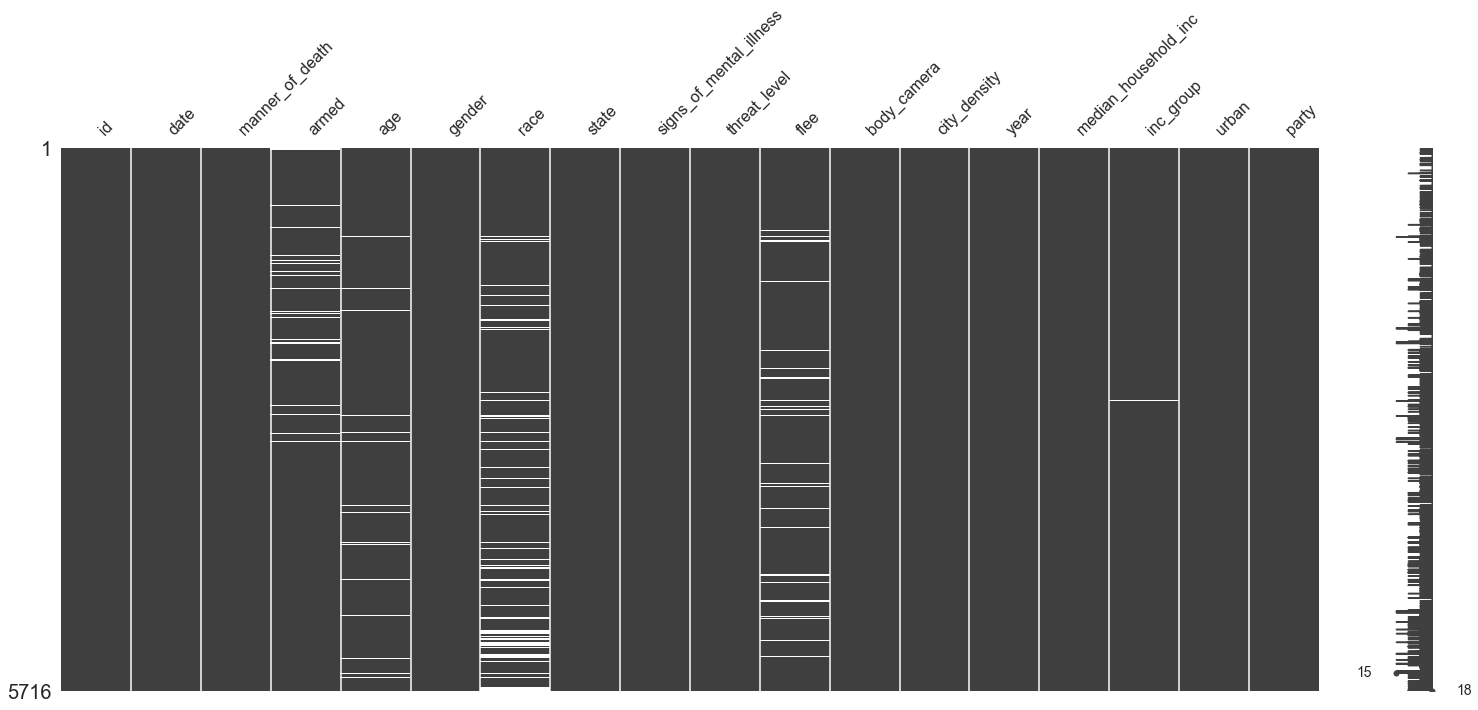

In [52]:
# Program to visualize missing values in dataset 

# Visualize missing values as a matrix 
msno.matrix(df3) 

### <div class='exercise' id='section_3'><b>Section 3: Lets make some Plots!</b></div>
[▲ Return to contents](#Contents)

<div class='exercise'>

</div>

In [53]:
# Add the weighted race values from wikipedia x populatio
race_dict = {
    'W': 'White',
    'B': 'Black',
    'A': 'Asian',
    'N': 'Native American',
    'H': 'Hispanic',
    'O': 'Other',
    'nan': 'Unknown'
}


In [54]:
# Helper function for our plots
def plot_hor_value_counts_barchart(df_plot, class_key, verbose=False, normalized=False,
                               is_custom=False, custom_values=None):
    # Grab the value counts, and use custom ones if needed
    # e.g. date or categroical group
    if is_custom:
        df_values = custom_values
    else:
        df_values = df_plot[class_key].value_counts(ascending=True)
    
    if verbose:
        display(df_values)
    
    # Create the plot ax object
    ax = df_values.plot(kind='barh', figsize=(8,14))
    
    # Set and rotate the labels for better readability 
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Set the labels
    x_label =  "Fatal Police Shooting Count / Million People" if normalized == True else "Fatal Police Shooting count"
    ax.set_xlabel(x_label, fontsize=18)    
    
    # Create the title extenstion and then set title
    title_ext_norm = " - Per 1 Million People" if normalized == True else ""
    ax.set_title(f"Fatal Police Shootings by {class_key.capitalize()}{title_ext_norm}", fontsize=20)
    
    # Remove the legend
    ax.legend().set_visible(False)

    plt.show()

# Helper function for our plots
def plot_value_counts_barchart(df_plot, class_key, verbose=False, normalized=False,
                               is_custom=False, custom_values=None, custom_title_ext=None):
    # Grab the value counts, and use custom ones if needed
    # e.g. date or categroical group
    if is_custom:
        df_values = custom_values
    else:
        df_values = df_plot[class_key].value_counts()
    
    if verbose:
        display(df_values)
    
    # Create the plot ax object
    ax = df_values.plot(kind='bar', figsize=(14,8))    
    
    # Set and rotate the labels for better readability 
    ax.tick_params(axis='x', rotation=0, direction="in", which='major', labelsize=18)
    ax.tick_params(axis='y', which='major', labelsize=18)

    # Set the labels
    ax.set_ylabel("Fatal Police Shooting Count", fontsize=18)
    ax.set_xlabel("", fontsize=1)
    
    # Update for mapping race
    if 'race' in class_key.lower():
        xticks_race = []
        for race_abbrev in df_values.index:
            xticks_race.append(race_dict[race_abbrev])
            
        ax.set_xticklabels(xticks_race)

    # Create the title extenstion and then set title
    if custom_title_ext is None:
        title_ext_norm = " - by Ratio US Population" if normalized == True else ""
        title_plot = f"Fatal Police Shootings{title_ext_norm}"
    else:
        title_plot = f"Fatal Police Shootings by {custom_title_ext}"
        
    ax.set_title(title_plot, fontsize=20)
    
    plt.show()

### State by state 
We see that CA, TX and FL by far have the most police indcident. If you look at the normalized (so by ratio), chart you see a more even distribution.

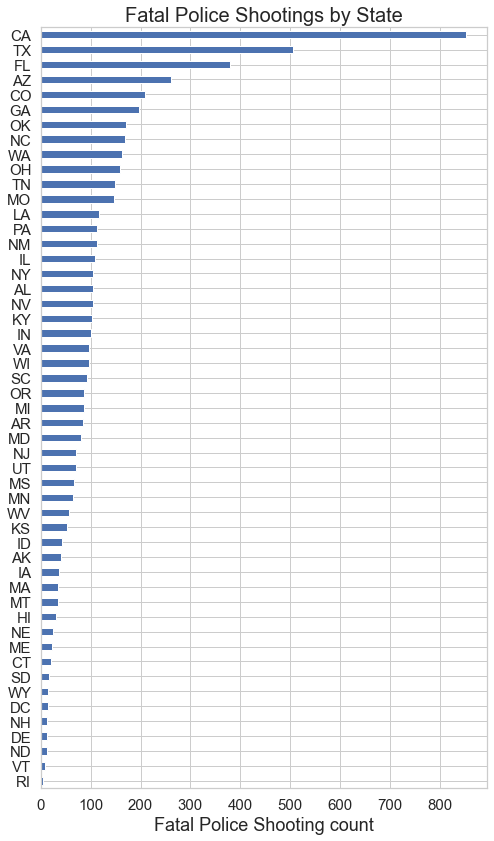

In [55]:
# Plot state by state count 
plot_hor_value_counts_barchart(df3, 'state')


### State by state ratio based

We used to us census data to normalize each state's incident by it's population, to get a more clear few of where most incidents happen the most.

In [56]:
# Get the population of each state from the 2019 Cencus data
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}
# Create our summary df
population_summary = population_df[population_df['STATE']!=0][['NAME','POPESTIMATE2019']]

# Map state abbreviations
population_summary['abbrev'] = population_summary['NAME'].map(us_state_abbrev)

# Drop and set index right
population_summary.drop(columns=['NAME'], inplace=True)
population_summary.set_index('abbrev',inplace=True)

# Ouput data
display(population_summary.head())


,POPESTIMATE2019
abbrev,
AL,4903185
AK,731545
AZ,7278717
AR,3017804
CA,39512223


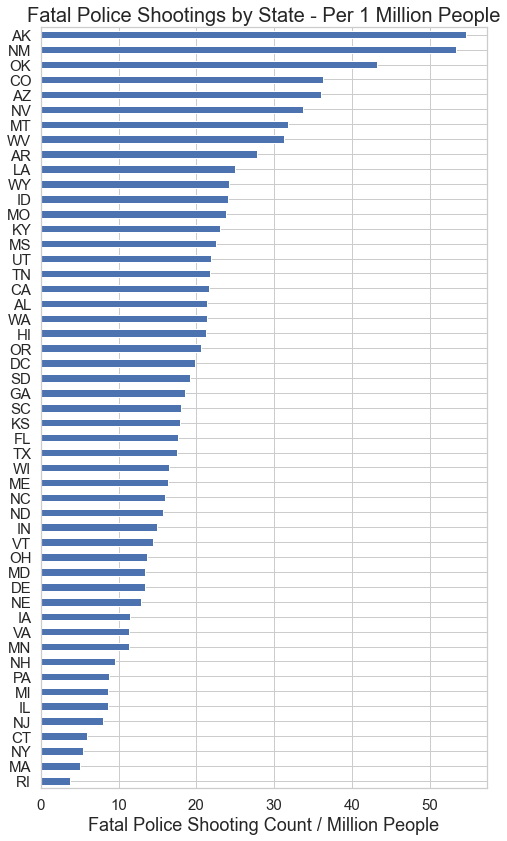

In [57]:
# Merge and create the state df
state_df = pd.concat([population_summary, df3['state'].groupby([df3.state]).agg('count')],axis=1).drop(index='PR')

# Make the calculation
state_df['incidents_per_million'] = state_df['state']/state_df['POPESTIMATE2019']*1000000

# Do some cleaning up
state_df.drop(columns=['state', 'POPESTIMATE2019'], inplace=True)

# Sort by most most incidents
state_df.sort_values(by=['incidents_per_million'], inplace=True, ascending=True)

# display(state_df)
plot_hor_value_counts_barchart(state_df, 'state', normalized=True, is_custom=True, custom_values=state_df)


### Year by year for all incidents
There doesn't seem to be a very clear indication that the indicents grew on year to year basis 

This data was sourced at the 10th month of 2020, so 2020 could at the end of this year also be similar to the previous years

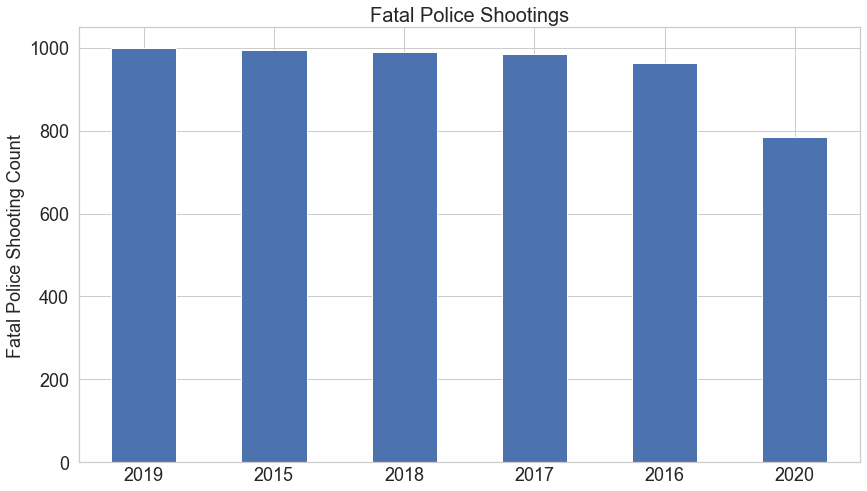

In [58]:
# Plot state by year 
plot_value_counts_barchart(df3, 'year')

### Incidents by race

This is the [original classification](https://github.com/washingtonpost/data-police-shootings):
race:

`race`:
- `W`: White, non-Hispanic
- `B`: Black, non-Hispanic
- `A`: Asian
- `N`: Native American
- `H`: Hispanic
- `O`: Other
- `None`: unknown

We want add weights the incident based on the actual amount of each race that lives in the US.

Used data [from wikipedia](https://en.wikipedia.org/wiki/Race_and_ethnicity_in_the_United_States#Racial_categories):
- `W`: 0.601
- `B`: 0.134
- `A`: 0.059
- `N`: 0.013
- `H`: 0.185
- `O`: 0.008

W    2595
B    1345
H     947
A      94
N      81
Name: race, dtype: int64

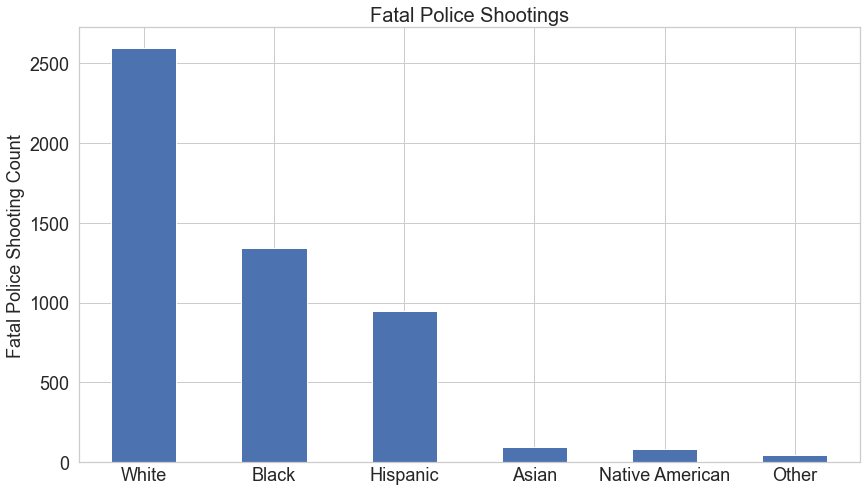

In [59]:
# Get weighted values
df_by_race = df3['race'].value_counts()
display(df_by_race.head())

# Plot state by race
plot_value_counts_barchart(df3, 'race')


A    0.000481
B    0.003032
H    0.001546
N    0.001882
O    0.001775
dtype: float64

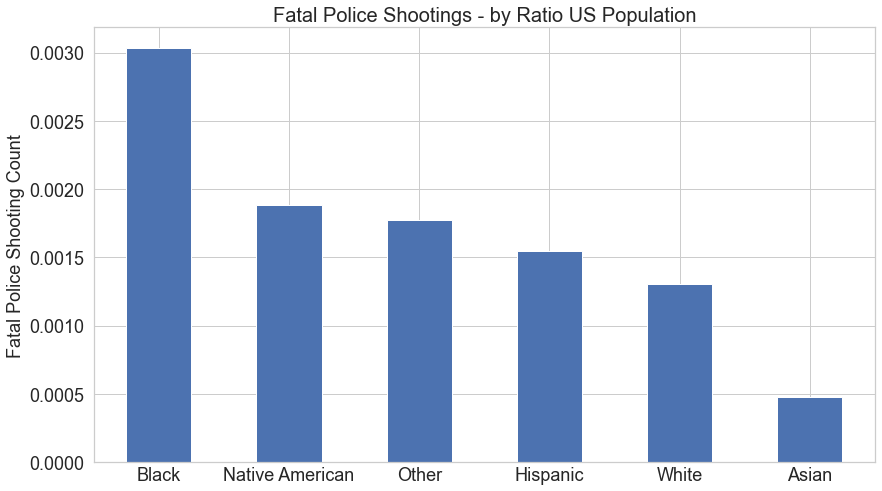

In [60]:
# https://www.worldometers.info/world-population/us-population
total_pop = 331002651

# Add the weighted race values from wikipedia x populatio
race_ratios = pd.Series({
    'W': 0.601,
    'B': 0.134,
    'A': 0.059,
    'N': 0.013,
    'H': 0.185,
    'O': 0.008,
}) * total_pop

# print(race_ratios)

# Divide the indicent counts by their representation amount 
df_by_race_ratio = (df_by_race/race_ratios) * 100
display(df_by_race_ratio.head())

# Indicent plot by ratio race in US Normalized
df_by_race_ratio.sort_values(ascending=False, inplace=True)
plot_value_counts_barchart(df3, 'Race ratio', is_custom=True, 
                           normalized=True, custom_values=df_by_race_ratio)

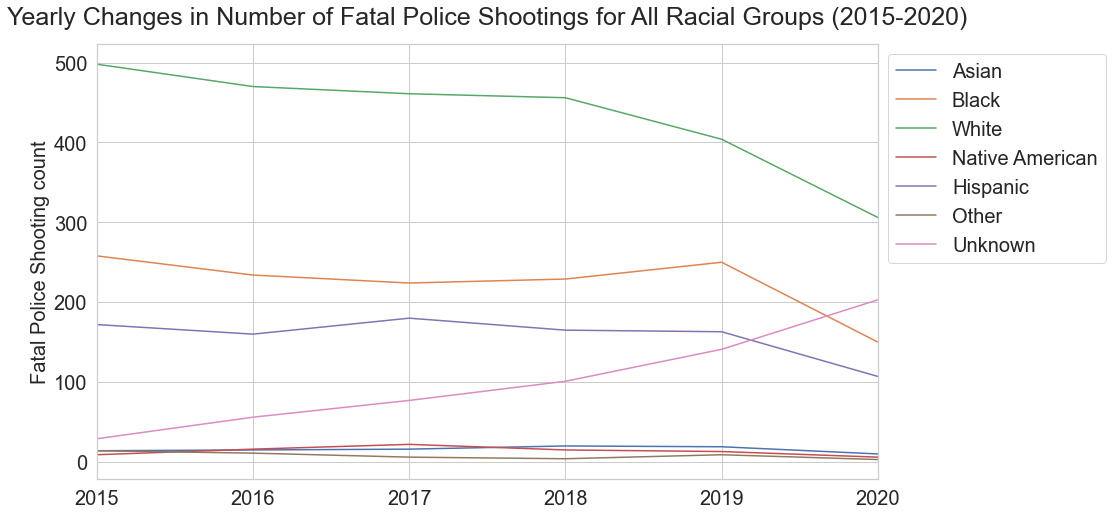

In [61]:
# Need to also include nans for year
df_plot_year = df3
df_plot_year['race'] = df_plot_year['race'].astype('str')

# Group incidents by year
race_year_df = df_plot_year.groupby(['race','year'], as_index=False).count()

# Create the plot
plt.figure(figsize=(14,8))
plt.plot(race_year_df[race_year_df['race']=='A']['year'],race_year_df[race_year_df['race']=='A']['id'], label='Asian')
plt.plot(race_year_df[race_year_df['race']=='B']['year'],race_year_df[race_year_df['race']=='B']['id'], label='Black')
plt.plot(race_year_df[race_year_df['race']=='W']['year'],race_year_df[race_year_df['race']=='W']['id'], label='White')
plt.plot(race_year_df[race_year_df['race']=='N']['year'],race_year_df[race_year_df['race']=='N']['id'], label='Native American')
plt.plot(race_year_df[race_year_df['race']=='H']['year'],race_year_df[race_year_df['race']=='H']['id'], label='Hispanic')
plt.plot(race_year_df[race_year_df['race']=='O']['year'],race_year_df[race_year_df['race']=='O']['id'], label='Other')
plt.plot(race_year_df[race_year_df['race']=='nan']['year'],race_year_df[race_year_df['race']=='nan']['id'], label='Unknown')
plt.xlim(2015,2020)

# Set and rotate the labels for better readability 
plt.tick_params(axis='both', which='major', labelsize=20)

# Set labels
plt.ylabel("Fatal Police Shooting count", fontsize=20)
plt.xlabel("", fontsize=1)
plt.title("Yearly Changes in Number of Fatal Police Shootings for All Racial Groups (2015-2020)",
          fontsize=25, pad=20)

# Position and show the legend
plt.legend( bbox_to_anchor=(1, 1), loc='upper left', fontsize=20)

# plt.legend(fontsize=16)
plt.show()

### Incidents by age


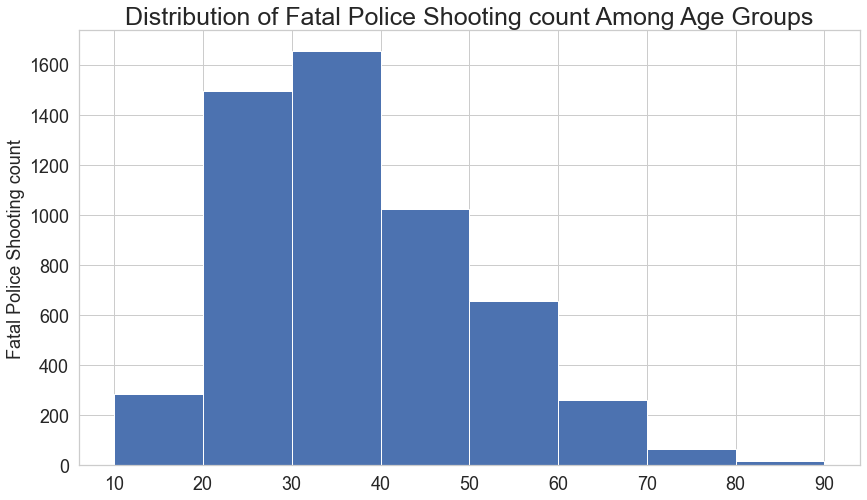

In [62]:
plt.figure(figsize=(14,8))
plt.hist(df3['age'],bins=range(10,100,10))

# Set and rotate the labels for better readability 
plt.tick_params(axis='both', which='major', labelsize=18)

# Set labels
plt.ylabel("Fatal Police Shooting count", fontsize=18)
plt.xlabel("", fontsize=1)
plt.title("Distribution of Fatal Police Shooting count Among Age Groups", fontsize=25)

plt.show()


### Income groups

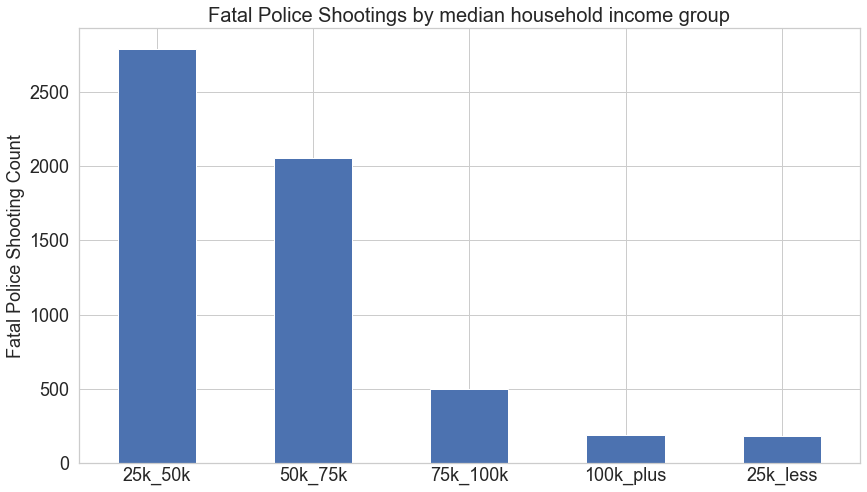

In [63]:
# Plot state by race
plot_value_counts_barchart(df3, 'inc_group', custom_title_ext="median household income group")

### Plot by city density classifier

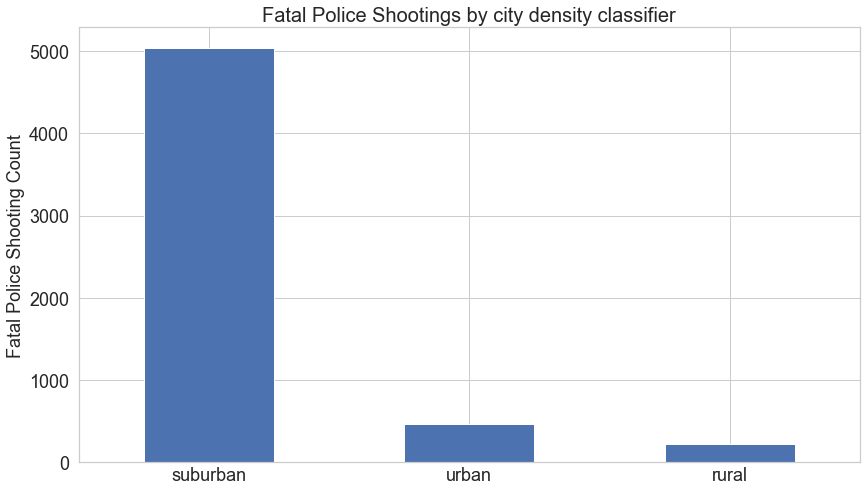

In [64]:
# Plot state by race
plot_value_counts_barchart(df3, 'urban', custom_title_ext="city density classifier")

### Additional Investigative visualizations

Variety of plots attempting to gain further insights into the data


In [65]:
# Custom value count bar plots
def plot_value_count_catergories(ax, df_plot, group_cat = 'year',  cat = ''):
    
    # Needs ratios
    if group_cat == 'race':
        # Group by race
        df_by_race = df_plot.groupby('race')[cat].value_counts().unstack(0)

        # Divide the indicent counts by their representation amount 
        for col in df_by_race.columns:
            if col != 'nan':                    
                df_by_race[col] = (df_by_race[col]/race_ratios[col]) * 100
            else:
                df_by_race[col] = 0

        # Create the plot ax object
        df_by_race.plot.bar(ax=ax)
        
    else:
        # Create the plot ax object
        df_plot.groupby(group_cat)[cat].value_counts().unstack(0).plot.bar(ax=ax)
        
    # Set and rotate the labels for better readability 
    ax.tick_params(axis='x', rotation=0, direction="in", which='major', labelsize=20)
    ax.tick_params(axis='y', which='major', labelsize=18)
    
    # Set the labels
    ax.set_ylabel("Frequency", fontsize = 18)    
    ax.set_xlabel("", fontsize = 1)    
    
    # Create the title extenstion and then set title
    ax.set_title(f"Fatal police killings by {cat.capitalize()}", fontsize=20)
    ax.legend(loc='upper right', fontsize=14)


display(df3.columns)

Index(['id', 'date', 'manner_of_death', 'armed', 'age', 'gender', 'race', 'state', 'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera', 'city_density', 'year', 'median_household_inc', 'inc_group', 'urban', 'party'], dtype='object')

### Categorical plots by year

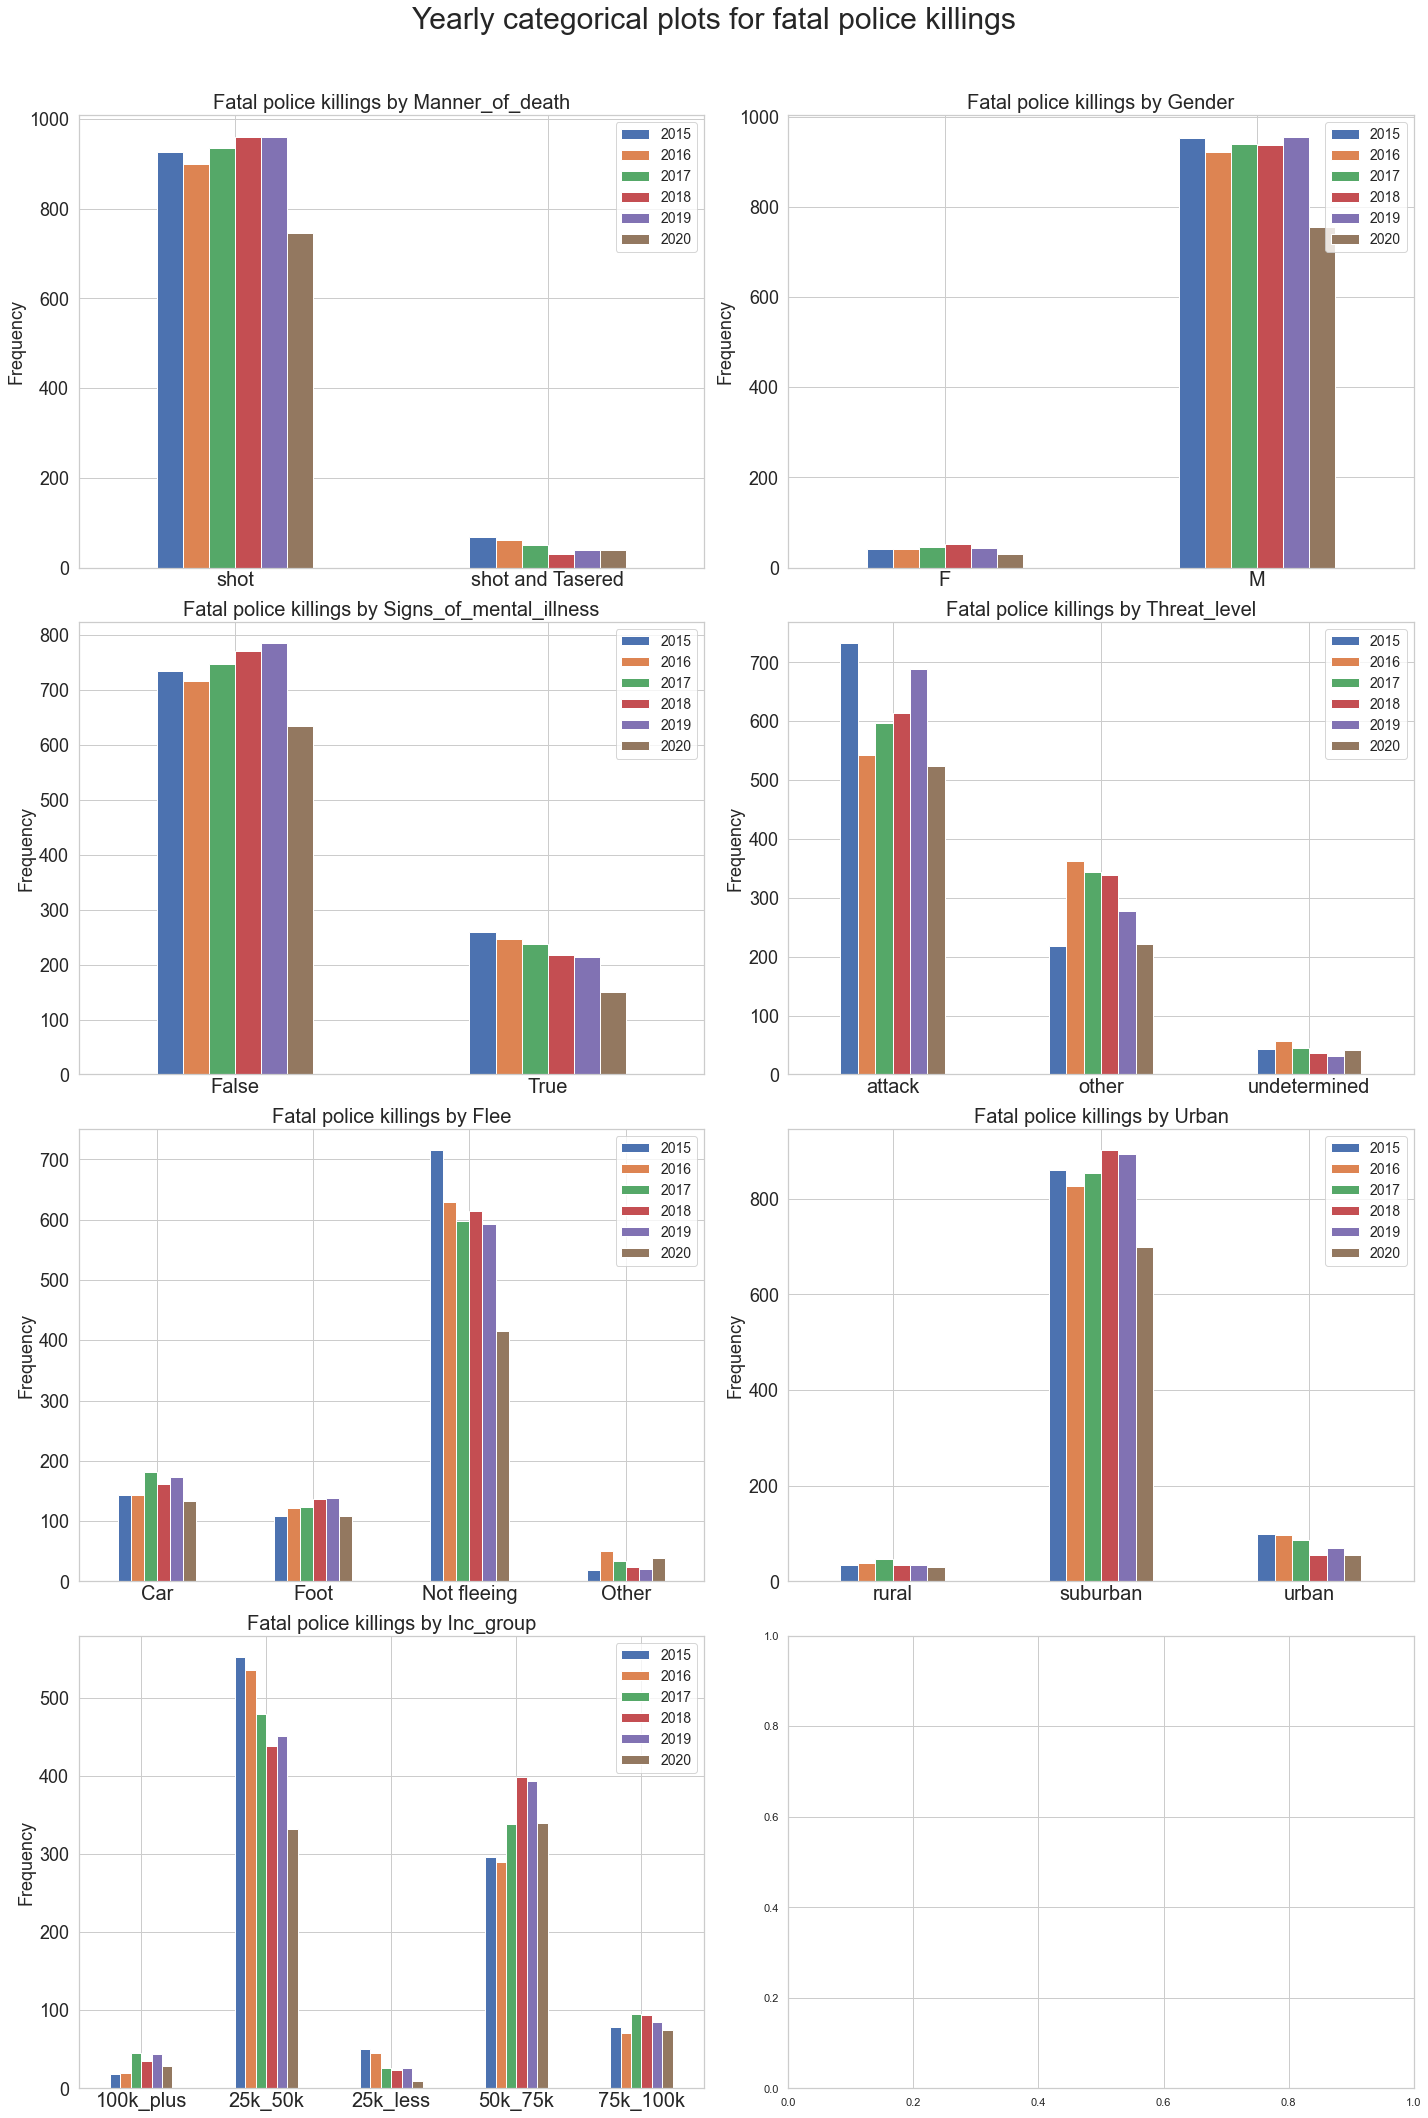

In [66]:
# Categorical
cat_preds = ['manner_of_death', 'gender', 'signs_of_mental_illness', 'threat_level', 'flee', 'urban', 'inc_group']

amount_rows = int(np.ceil(len(cat_preds)/2))

# Grab the figure and ax arr object
fig, axs = plt.subplots(nrows=amount_rows, ncols=2, figsize=(20,30)) 
axs = axs.ravel() # Get them in a listed order

for i in range(len(cat_preds)):
    cat = cat_preds[i]        
    plot_value_count_catergories(axs[i], df3, group_cat='year', cat = cat)

# Add the main title and show the plot
plt.suptitle(f"Yearly categorical plots for fatal police killings", fontsize=30)
fig.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()



### Categorical plot by race

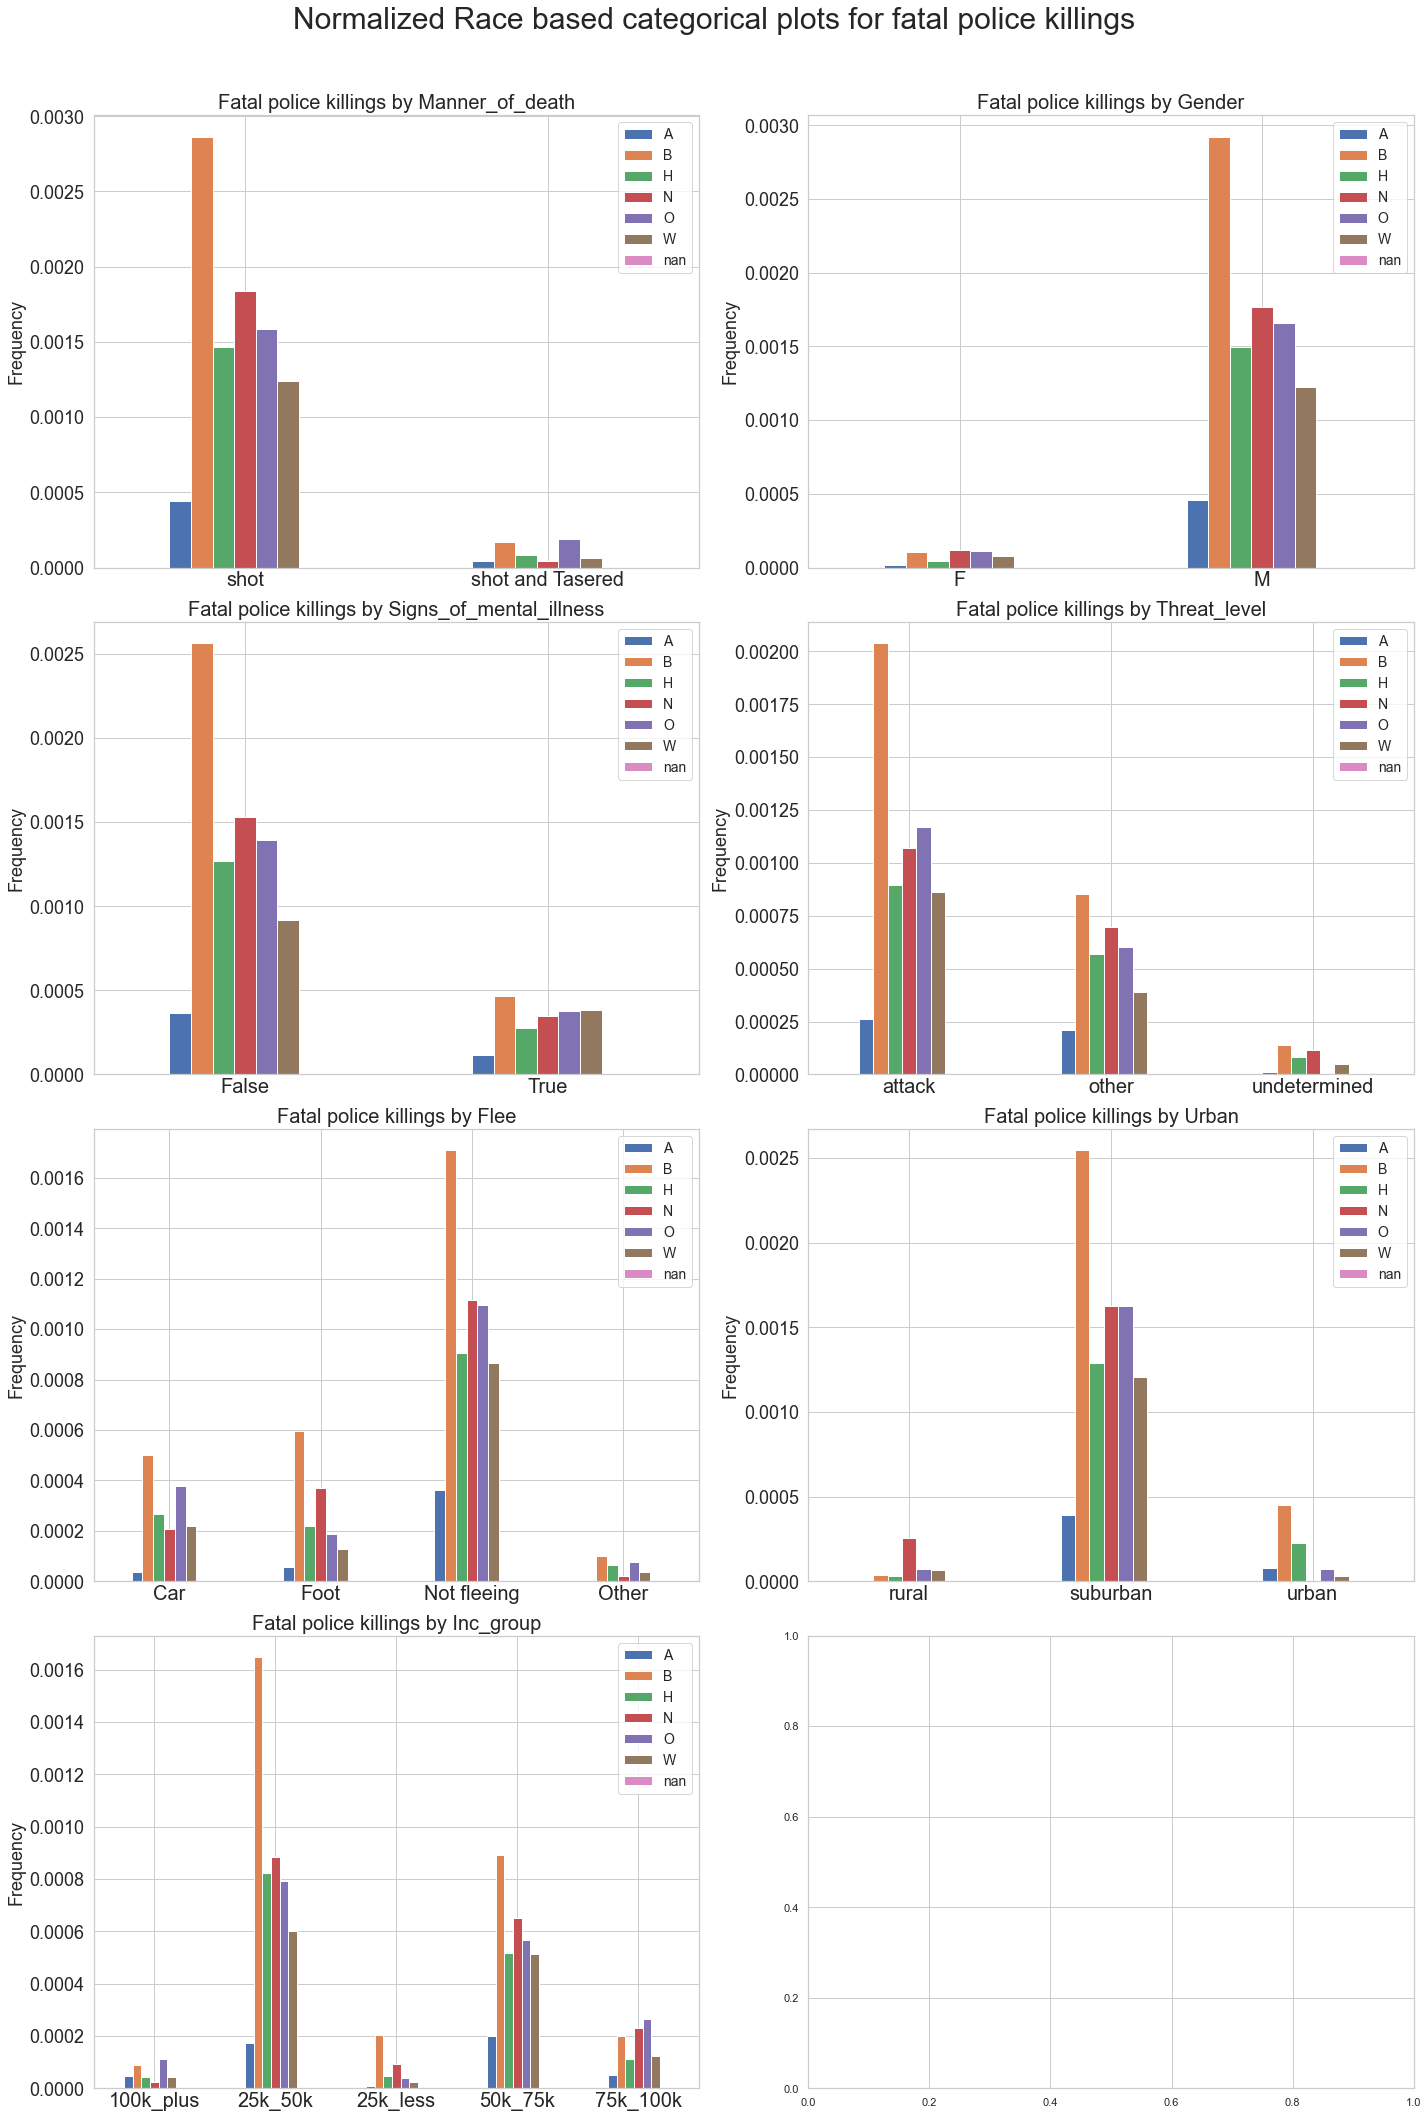

In [67]:
# Categorical
cat_preds = ['manner_of_death', 'gender', 'signs_of_mental_illness', 'threat_level', 'flee', 'urban', 'inc_group']

amount_rows = int(np.ceil(len(cat_preds)/2))

# Grab the figure and ax arr object
fig, axs = plt.subplots(nrows=amount_rows, ncols=2, figsize=(20,30)) 
axs = axs.ravel() # Get them in a listed order

for i in range(len(cat_preds)):
    cat = cat_preds[i]        
    plot_value_count_catergories(axs[i], df3, group_cat = 'race', cat = cat)

# Add the main title and show the plot
plt.suptitle(f"Normalized Race based categorical plots for fatal police killings", fontsize=30)
fig.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

### Correlation plot

We don't see that much correlation, only city_density and party seem to be more correlated, which could imply that democratid lead states are more dense in terms of population

<AxesSubplot:>

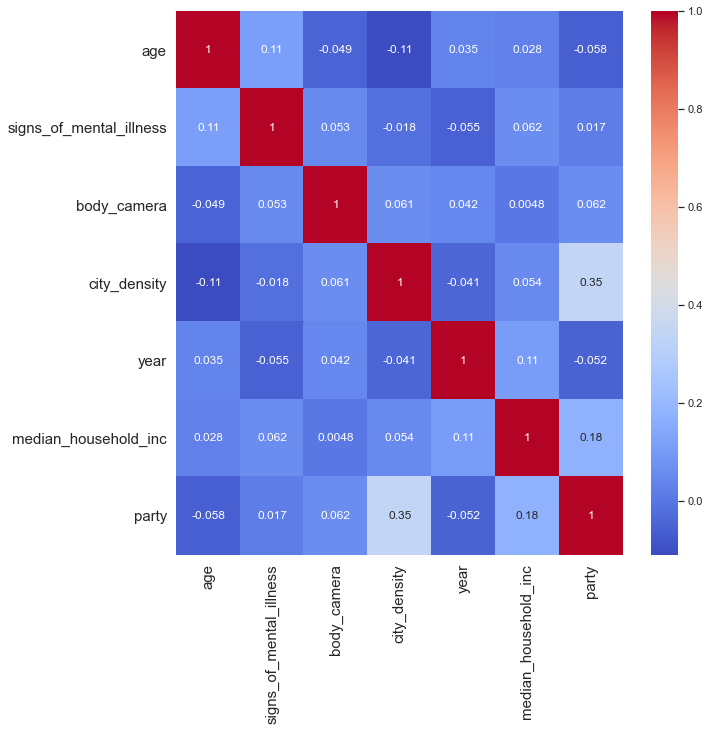

In [68]:
# your code here

# Calculate correlations
corr = df3.drop('id', axis=1).corr()

# Create our plot models
fig, ax = plt.subplots(figsize=(10,10)) 

# Set and rotate the labels for better readability 
ax.tick_params(axis='x', rotation=45,  labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)

# Show the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', robust=True, ax=ax)


In [69]:
df3.race.value_counts()

W      2595
B      1345
H       947
nan     607
A        94
N        81
O        47
Name: race, dtype: int64

### <div class='exercise' id='section_4'><b>Section 4: Initial Look at Models</b></div>
[▲ Return to contents](#Contents)

<div class='exercise'>

</div>



*This initial look at the models explores the regression specification for Modified Question #2, evaluated by racial category of police shooting victim*

In [70]:
# For our model, we need the distribution of racial groups in each state.  
# To get this data, we downloaded a CSV file from the following URL,
# based on the 2019 estimates by the US Census Bureau.

# https://www.kff.org/other/state-indicator/distribution-by-raceethnicity/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D 

In [71]:
racial_dist_df = pd.read_csv(f'{data_dir}/raw_data.csv')
# Drop US and PR
racial_dist_df.drop(index=[0,52], inplace=True)
racial_dist_df['state'] = racial_dist_df['Location'].map(us_state_abbrev)
racial_dist_df.set_index('state',inplace=True)
racial_dist_df = racial_dist_df.replace(np.nan,0)
racial_dist_df = racial_dist_df.replace('<.01',0)
racial_dist_df['Native Hawaiian/Other Pacific Islander'] = racial_dist_df['Native Hawaiian/Other Pacific Islander'].astype(float)
racial_dist_df['other'] = racial_dist_df['Native Hawaiian/Other Pacific Islander'] + racial_dist_df['Multiple Races']
racial_dist_df = racial_dist_df.rename(columns={'White':'race_W_ratio', 'Black': 'race_B_ratio', 'Hispanic': 'race_H_ratio', 'Asian': 'race_A_ratio', 'American Indian/Alaska Native': 'race_N_ratio', 'other': 'race_O_ratio'})

In [72]:
model_df = pd.get_dummies(data=df3[['year','race','state']], columns=['race'])
model_df = model_df.groupby(['state','year'], as_index=False).sum()
model_df['total_incidents'] = model_df.race_A + model_df.race_B + model_df.race_H + model_df.race_N + model_df.race_O + model_df.race_W 
model_df = model_df.join(population_summary['POPESTIMATE2019'], on='state')
model_df = model_df.join(racial_dist_df[['race_W_ratio','race_B_ratio','race_H_ratio','race_A_ratio','race_N_ratio','race_O_ratio']], on='state')
model_df['black_inc_per_pop'] = model_df['race_B'] / (model_df['POPESTIMATE2019'] * model_df['race_B_ratio'])
model_df['white_inc_per_pop'] = model_df['race_W'] / (model_df['POPESTIMATE2019'] * model_df['race_W_ratio'])
model_df['asian_inc_per_pop'] = model_df['race_A'] / (model_df['POPESTIMATE2019'] * model_df['race_A_ratio'])
model_df['native_inc_per_pop'] = model_df['race_N'] / (model_df['POPESTIMATE2019'] * model_df['race_N_ratio'])
model_df['hispanic_inc_per_pop'] = model_df['race_H'] / (model_df['POPESTIMATE2019'] * model_df['race_H_ratio'])
model_df['other_inc_per_pop'] = model_df['race_O'] / (model_df['POPESTIMATE2019'] * model_df['race_O_ratio'])
model_df.head(10)

,state,year,race_A,race_B,race_H,race_N,race_O,race_W,race_nan,total_incidents,POPESTIMATE2019,race_W_ratio,race_B_ratio,race_H_ratio,race_A_ratio,race_N_ratio,race_O_ratio,black_inc_per_pop,white_inc_per_pop,asian_inc_per_pop,native_inc_per_pop,hispanic_inc_per_pop,other_inc_per_pop
0,AK,2015,0,0,0,2,0,2,0,4,731545,0.600,0.022,0.070,0.060,0.151,0.098,0.000000,0.000005,0.000000,0.000018,0.000000,0.0
1,AK,2016,0,0,0,3,0,3,1,6,731545,0.600,0.022,0.070,0.060,0.151,0.098,0.000000,0.000007,0.000000,0.000027,0.000000,0.0
2,AK,2017,0,1,0,1,0,5,1,7,731545,0.600,0.022,0.070,0.060,0.151,0.098,0.000062,0.000011,0.000000,0.000009,0.000000,0.0
3,AK,2018,1,1,0,2,0,3,0,7,731545,0.600,0.022,0.070,0.060,0.151,0.098,0.000062,0.000007,0.000023,0.000018,0.000000,0.0
4,AK,2019,0,1,0,1,0,4,1,6,731545,0.600,0.022,0.070,0.060,0.151,0.098,0.000062,0.000009,0.000000,0.000009,0.000000,0.0
5,AK,2020,1,0,0,0,0,5,1,6,731545,0.600,0.022,0.070,0.060,0.151,0.098,0.000000,0.000011,0.000023,0.000000,0.000000,0.0
6,AL,2015,0,6,0,0,0,11,0,17,4903185,0.654,0.265,0.044,0.014,0.004,0.019,0.000005,0.000003,0.000000,0.000000,0.000000,0.0
7,AL,2016,0,6,0,0,0,17,2,23,4903185,0.654,0.265,0.044,0.014,0.004,0.019,0.000005,0.000005,0.000000,0.000000,0.000000,0.0
8,AL,2017,0,6,1,0,0,14,4,21,4903185,0.654,0.265,0.044,0.014,0.004,0.019,0.000005,0.000004,0.000000,0.000000,0.000005,0.0
9,AL,2018,0,3,0,0,0,9,1,12,4903185,0.654,0.265,0.044,0.014,0.004,0.019,0.000002,0.000003,0.000000,0.000000,0.000000,0.0


In [73]:
# your code here
model_black = smf.ols(formula='black_inc_per_pop ~ 1 + C(state) + C(year)', data = model_df).fit()
print(model_black.summary())

                            OLS Regression Results                            
Dep. Variable:      black_inc_per_pop   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     2.754
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           5.57e-08
Time:                        13:13:19   Log-Likelihood:                 3020.3
No. Observations:                 298   AIC:                            -5929.
Df Residuals:                     242   BIC:                            -5721.
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.061e-05   4.56e-06     

In [74]:
# your code here
model_white = smf.ols(formula='white_inc_per_pop ~ 1 + C(state) + C(year)', data = model_df).fit()
print(model_white.summary())

                            OLS Regression Results                            
Dep. Variable:      white_inc_per_pop   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     7.783
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           2.98e-30
Time:                        13:13:19   Log-Likelihood:                 3633.7
No. Observations:                 298   AIC:                            -7155.
Df Residuals:                     242   BIC:                            -6948.
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        8.685e-06   5.82e-07     

In [75]:
# your code here
model_hispanic = smf.ols(formula='hispanic_inc_per_pop ~ 1 + C(state) + C(year) ', data = model_df).fit()
print(model_hispanic.summary())

                             OLS Regression Results                             
Dep. Variable:     hispanic_inc_per_pop   R-squared:                       0.375
Model:                              OLS   Adj. R-squared:                  0.233
Method:                   Least Squares   F-statistic:                     2.643
Date:                  Sat, 12 Dec 2020   Prob (F-statistic):           1.92e-07
Time:                          13:13:19   Log-Likelihood:                 3363.5
No. Observations:                   298   AIC:                            -6615.
Df Residuals:                       242   BIC:                            -6408.
Df Model:                            55                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -6.438

In [76]:
# your code here
model_otherrace = smf.ols(formula='other_inc_per_pop ~ 1 + C(state) + C(year)', data = model_df).fit()
print(model_otherrace.summary())

                            OLS Regression Results                            
Dep. Variable:      other_inc_per_pop   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     1.541
Date:                Sat, 12 Dec 2020   Prob (F-statistic):             0.0147
Time:                        13:13:19   Log-Likelihood:                 3438.1
No. Observations:                 298   AIC:                            -6764.
Df Residuals:                     242   BIC:                            -6557.
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         1.89e-07   1.12e-06     

### <div class='exercise' id='section_5'><b>Section 5: Extending The Models Further</b></div>
[▲ Return to contents](#Contents)
<div class='exercise'>

</div>


This section will predict race based on the WaPo dataset, using the following methodologies:

### Models
 * Logistic Regression Baseline Model
 * Logistirc Regression Lasso Regularized Model with Cross-Validation
 * Random Forest
 * Neural Net


### Dropping predictors

We are dropping predictors we don't need in our model like 'date' and 'id'. 

We are not using 'urban' as categorical predictor in our model because 'city_density' itself was proven to be better predictor. Also 'median_household_inc' turned out to be a better predictor than 'inc_group'.

In [77]:
# Drop the 'id' and 'date' column
df4 = df3.drop(columns=['date', 'id', 'urban', 'inc_group'])

### Check for nan values

In [78]:
nan_row_stats(df4)
missing_cols = nan_vals_stats(df4)

Dataframe with 5716 rows, does not have rows with all empty values


,Missing,Dtype
flee,290,object
age,260,float64
armed,213,object
gender,1,object
manner_of_death,0,object
race,0,object
state,0,object
signs_of_mental_illness,0,bool
threat_level,0,object
body_camera,0,bool


### Dropping rows

Now the we have made the final selection of predictors we need for our model, we can start dropping rows that miss essential information for our model.

In [79]:
# Only a few missing values, lets drop those and create a new df
df4 = df4.dropna()
print("\n\nModified dataframe shape after dropping NaN:")
display(df4.shape)
display(df4.columns)



Modified dataframe shape after dropping NaN:


(4990, 14)

Index(['manner_of_death', 'armed', 'age', 'gender', 'race', 'state', 'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera', 'city_density', 'year', 'median_household_inc', 'party'], dtype='object')

### Now we need to recast some of the object types as correct values

Lastly we want to recast some predictors before we start encoding and building our models.


In [80]:
# Data type conversions
df4['race'] = df4['race'].astype('category')
df4['flee'] = df4['flee'].astype('category')
df4['armed'] = df4['armed'].astype('category')
df4['gender'] = df4['gender'].astype('category')
df4['manner_of_death'] = df4['manner_of_death'].astype('category')
df4['threat_level'] = df4['threat_level'].astype('category')
df4['body_camera'] = df4['body_camera'].astype('category')
df4['state'] = df4['state'].astype('category')
df4['signs_of_mental_illness'] = df4['signs_of_mental_illness'].astype('int')

# check again
display(df4.dtypes)

manner_of_death            category
armed                      category
age                         float64
gender                     category
race                       category
state                      category
signs_of_mental_illness       int64
threat_level               category
flee                       category
body_camera                category
city_density                float64
year                          int64
median_household_inc          int64
party                         int64
dtype: object

### Encode categorical predictors

We are not using 'urban' as categorical predictor in our model because 'city_density' itself was proven to be better predictor.
Also 'median_household_inc' turned out to be a better predictor than 'inc_group'.

In [81]:
# Custom one hot encoding function for non numerical columns/features
def one_hot_encode(df_one_hot, cols, drop_orig = False, force_lc = False, output_stats = True):
    encoded_cols_added = 0
    amount_cols_before = len(df_one_hot.columns)
    
    for col in cols:
        dummies = pd.get_dummies(df_one_hot[col], prefix=col)
        print(f"Predictor '{col}' has {len(dummies.columns)} categories added")
        df_one_hot = pd.concat([df_one_hot, dummies], axis=1)
        encoded_cols_added += len(dummies.columns)
    
    # Drop original columns
    if drop_orig:
        df_one_hot = df_one_hot.drop(cols, axis=1)
    
    # Output changes made
    if output_stats:
        print(f"Dropped original -> {drop_orig}")
        print(f"Added {encoded_cols_added} one hot encoded cols.")
        print(f"Started with {amount_cols_before} to a total of {len(df_one_hot.columns)} columns")
    
    # Lowercase all columns if required
    if force_lc:
        df_one_hot.columns= df_one_hot.columns.str.lower()
    
    return df_one_hot

In [82]:
# Categorical variables to process
cat_vars = ['manner_of_death','armed', 'gender', 'state',
            'threat_level','flee', 'body_camera', 'race']

# cat_columns = df2[['manner_of_death','armed', 'gender', 'state', 'threat_level','flee',
#                    'body_camera', 'is_geocoding_exact', 'year', 'race']]

# Enocde all the data
df5 = one_hot_encode(df4, cat_vars, drop_orig = True, force_lc = True)

# Validate data mutation and output the rest
display(df5.head())

Predictor 'manner_of_death' has 2 categories added
Predictor 'armed' has 94 categories added
Predictor 'gender' has 2 categories added
Predictor 'state' has 51 categories added
Predictor 'threat_level' has 3 categories added
Predictor 'flee' has 4 categories added
Predictor 'body_camera' has 2 categories added
Predictor 'race' has 7 categories added
Dropped original -> True
Added 165 one hot encoded cols.
Started with 14 to a total of 171 columns


,age,signs_of_mental_illness,city_density,year,median_household_inc,party,manner_of_death_shot,manner_of_death_shot and tasered,armed_airsoft pistol,armed_bb gun,armed_bb gun and vehicle,armed_taser,armed_air conditioner,armed_air pistol,armed_ax,armed_barstool,armed_baseball bat,armed_baseball bat and bottle,armed_baseball bat and fireplace poker,armed_baseball bat and knife,armed_baton,armed_bayonet,armed_bean-bag gun,armed_beer bottle,armed_blunt object,armed_bottle,armed_bow and arrow,armed_box cutter,armed_brick,"armed_car, knife and mace",armed_carjack,armed_chain,armed_chain saw,armed_chainsaw,armed_chair,armed_contractor's level,armed_cordless drill,armed_crossbow,armed_crowbar,armed_fireworks,armed_flagpole,armed_flashlight,armed_garden tool,armed_glass shard,armed_grenade,armed_gun,armed_gun and car,armed_gun and knife,armed_gun and machete,armed_gun and sword,...,state_ky,state_la,state_ma,state_md,state_me,state_mi,state_mn,state_mo,state_ms,state_mt,state_nc,state_nd,state_ne,state_nh,state_nj,state_nm,state_nv,state_ny,state_oh,state_ok,state_or,state_pa,state_ri,state_sc,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy,threat_level_attack,threat_level_other,threat_level_undetermined,flee_car,flee_foot,flee_not fleeing,flee_other,body_camera_false,body_camera_true,race_a,race_b,race_h,race_n,race_o,race_w,race_nan
0,53.0,1,708.0,2015,48164,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0
1,47.0,0,2915.0,2015,73008,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
2,23.0,0,931.0,2015,43926,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0
3,32.0,1,7256.0,2015,125265,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
4,39.0,0,804.0,2015,45060,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0


In [83]:
# Variables to use
test_size = 0.3

# set X without response or unused predictors
X = df5.drop(columns=['race_a', 'race_b', 'race_h', 'race_n', 'race_o', 'race_w', 'race_nan'])
y = df5['race_b']

display(X.head())

# Split train and test data and stratify african-american as race
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=test_size, 
                                                     random_state = random_state,
                                                     stratify=y)


print("Initial Dataframe shape: ", df5.shape)
print("X_train shape: ", X_train.shape, "\nX_test shape: ", X_test.shape, "\ny_train shape: ", y_train.shape, "\ny_test shape: ", y_test.shape)


,age,signs_of_mental_illness,city_density,year,median_household_inc,party,manner_of_death_shot,manner_of_death_shot and tasered,armed_airsoft pistol,armed_bb gun,armed_bb gun and vehicle,armed_taser,armed_air conditioner,armed_air pistol,armed_ax,armed_barstool,armed_baseball bat,armed_baseball bat and bottle,armed_baseball bat and fireplace poker,armed_baseball bat and knife,armed_baton,armed_bayonet,armed_bean-bag gun,armed_beer bottle,armed_blunt object,armed_bottle,armed_bow and arrow,armed_box cutter,armed_brick,"armed_car, knife and mace",armed_carjack,armed_chain,armed_chain saw,armed_chainsaw,armed_chair,armed_contractor's level,armed_cordless drill,armed_crossbow,armed_crowbar,armed_fireworks,armed_flagpole,armed_flashlight,armed_garden tool,armed_glass shard,armed_grenade,armed_gun,armed_gun and car,armed_gun and knife,armed_gun and machete,armed_gun and sword,...,state_ga,state_hi,state_ia,state_id,state_il,state_in,state_ks,state_ky,state_la,state_ma,state_md,state_me,state_mi,state_mn,state_mo,state_ms,state_mt,state_nc,state_nd,state_ne,state_nh,state_nj,state_nm,state_nv,state_ny,state_oh,state_ok,state_or,state_pa,state_ri,state_sc,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy,threat_level_attack,threat_level_other,threat_level_undetermined,flee_car,flee_foot,flee_not fleeing,flee_other,body_camera_false,body_camera_true
0,53.0,1,708.0,2015,48164,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0
1,47.0,0,2915.0,2015,73008,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
2,23.0,0,931.0,2015,43926,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
3,32.0,1,7256.0,2015,125265,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
4,39.0,0,804.0,2015,45060,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0


Initial Dataframe shape:  (4990, 171)
X_train shape:  (3493, 164) 
X_test shape:  (1497, 164) 
y_train shape:  (3493,) 
y_test shape:  (1497,)


### Logistic Regression Baseline Model


In [84]:
# Simple logisitc regression
logit = LogisticRegression(penalty="none", max_iter = 1000)
logit.fit(X_train, y_train)

# Get the classification scores
logit_train_accuracy = logit.score(X_train, y_train)
logit_test_accuracy = logit.score(X_test, y_test)

logit_train_score_perc = logit_train_accuracy * 100
logit_test_score_perc = logit_test_accuracy * 100

print(f"The train accuracy is {logit_train_score_perc:.2f}%")
print(f"The test accuracy is {logit_test_score_perc:.2f}%")

The train accuracy is 77.13%
The test accuracy is 76.62%


### Logistic Regression Lasso Regularized Model with Cross-Validation


In [85]:
# Regularization parameters to try
Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e6, 1e10]
kfold = 5
training_error, cross_validation_error, testing_error = [],[],[]

# Loop to get different model scores
for c in Cs:
    logit_lasso = LogisticRegression(C=c, penalty='l1', solver='liblinear')
    logit_lasso.fit(X_train, y_train)

    logit_lasso_train_accuracy = logit_lasso.score(X_train, y_train)
    logit_lasso_test_accuracy = logit_lasso.score(X_test, y_test)

    logit_lasso_coefficients = np.hstack(
        [logit_lasso.intercept_.reshape(-1, 1), logit_lasso.coef_]
    ).T

    #Perform cross-validation on the training data with 3 folds and get the mse_scores
    acc_score_train = cross_validate(logit_lasso, X_train, y_train, cv=kfold, scoring='accuracy')['test_score']
    train_score = logit_lasso.score(X_train, y_train)*100
    test_score = logit_lasso.score(X_test, y_test)*100
    
    #Compute the train and validation MSE
    training_error.append(train_score)
    testing_error.append(test_score)
    
    #Compute the mean of the cross validation error and store in list 
    #Remember to take into account the sign of the MSE metric returned by the cross_validate function 
    cross_validation_error.append(np.mean(acc_score_train)*100)
    
    #print(
    #"The regularization parameter C chosen by this model for each class "
    #"was:\n\n\t{}\n\n"
    #"The accuracy scores for this model are:"
    #"\n\n\tTrain\t{:.4f}\n\tTest\t{:.4f}\n"
    #.format(logit_lasso.C_, logit_lasso_train_accuracy, logit_lasso_test_accuracy)
    #)

The best C-value Lasso model using training dataset is c=10.0  with Accuracy of:  80.76%
The best C-value Lasso model using testing dataset is c=1 with Accuracy of: 79.56%
The best C-value Lasso model using cross-validation is c=1 with Accuracy of: 79.93%


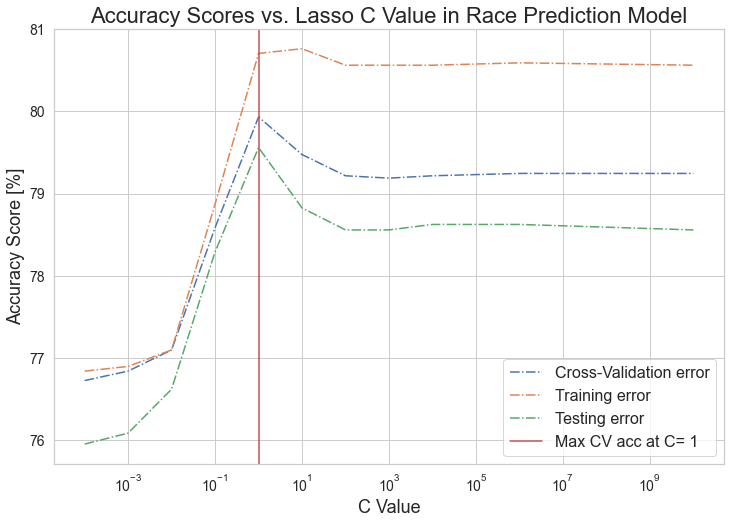

In [86]:
#The best degree with the highest training accuracy
max_train_acc = max(training_error)
best_train_c = Cs[training_error.index(max_train_acc)]


#The best degree with the highest testing accuracy
max_test_acc = max(testing_error)
best_test_c = Cs[testing_error.index(max_test_acc)]

#The best degree with the lowest cross-validation error
max_cross_val_acc = max(cross_validation_error)
best_cross_val_c = Cs[cross_validation_error.index(max_cross_val_acc)]

print(f"The best C-value Lasso model using training dataset is c={best_train_c}  with Accuracy of:  {max_train_acc:.2f}%")
print(f"The best C-value Lasso model using testing dataset is c={best_test_c} with Accuracy of: {max_test_acc:.2f}%")
print(f"The best C-value Lasso model using cross-validation is c={best_cross_val_c} with Accuracy of: {max_cross_val_acc:.2f}%")


# visualize results using plots
fig, ax = plt.subplots(figsize=(12,8))
#ax.plot(range(maxdeg), validation_error, label = 'Validation error')
plt.title('Accuracy Scores vs. Lasso C Value in Race Prediction Model', fontsize=22)
#Plot the cross-validation error with labels
ax.plot(Cs, cross_validation_error, '-.', label = 'Cross-Validation error')
ax.plot(Cs, training_error, '-.', label = 'Training error')
ax.plot(Cs, testing_error, '-.', label = 'Testing error')
plt.axvline(Cs[cross_validation_error.index(max(cross_validation_error))], 0, 10, color = 'r', label = f'Max CV acc at C= {Cs[cross_validation_error.index(max(cross_validation_error))]}')

# Set the plot labels and legends
ax.set_xlabel('C Value', fontsize=18)
ax.set_ylabel('Accuracy Score [%]', fontsize=18)
ax.set_xscale('log')
ax.tick_params(labelsize=14)
ax.legend(loc = 'best', fontsize=16)
plt.show()

In [87]:
%%time
# your code here

# run permutation importance
perm_results = permutation_importance(logit_lasso, X_train, y_train, n_jobs=-1)

# calculate relative importance of top 10 predictors in descending order
relimp10 = np.flip(np.sort(perm_results.importances_mean)[-10:])/perm_results.importances_mean.max()

# identify indices of top 10 predictors in descending order
relimp10_idx = np.flip(np.argsort(perm_results.importances_mean)[-10:])

# identify top 10 predictor names based on sorted top 10 indices
relimp10_preds = [X_train.columns[i] for i in relimp10_idx]

CPU times: user 718 ms, sys: 143 ms, total: 861 ms
Wall time: 8 s


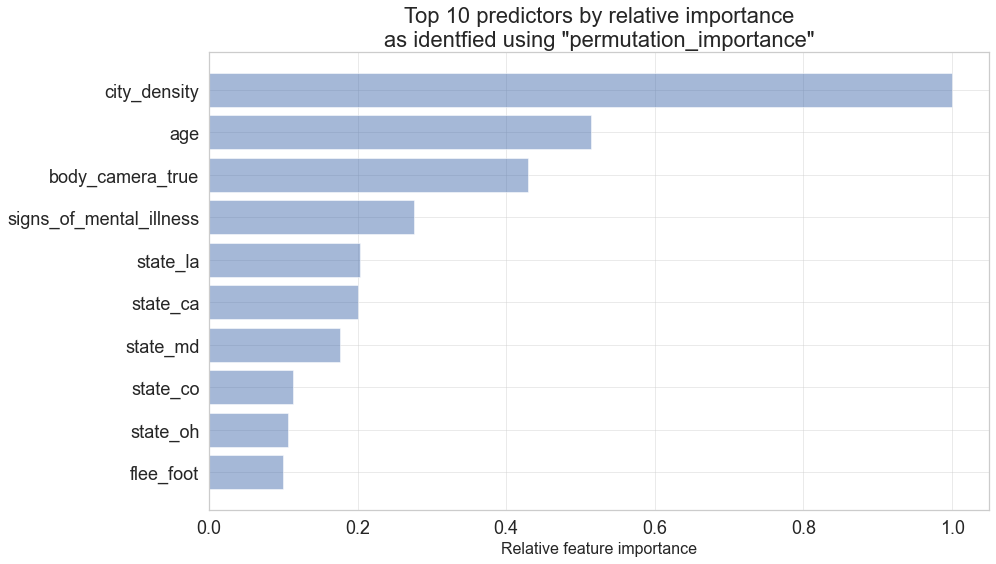

In [88]:

# plot results of top 10 predictors
fig, ax = plt.subplots(figsize = (14,8))

plt.title(
    "Top 10 predictors by relative importance\n"
    "as identfied using \"permutation_importance\"",
    fontsize=22,
)

ax.barh(relimp10_preds[::-1], relimp10[::-1], alpha=0.5)

ax.set_xlabel("Relative feature importance", fontsize=16)
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
ax.grid(':', alpha=0.4)
        
plt.tight_layout()
plt.show();

### Plotting the 2 top predictors

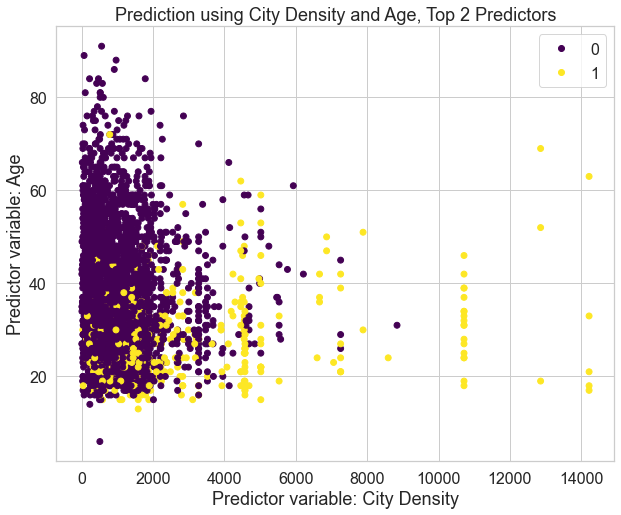

In [89]:
# your code here

y_pred = logit_lasso.predict(X_train).flatten()
# initialize
x_plot = X_train['city_density']
y_plot = X_train['age']
z = y_pred

# plot results
fig = plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis')
scatter = plt.scatter(x_plot, y_plot, c=z, vmin=0, vmax=1, s=35, cmap=cm)
#plt.colorbar()
plt.title('Prediction using City Density and Age, Top 2 Predictors', fontsize=18)
plt.ylabel('Predictor variable: Age', fontsize=18)
plt.xlabel('Predictor variable: City Density', fontsize=18)
plt.tick_params(labelsize=16)
plt.legend(*scatter.legend_elements(), loc='best', fontsize=16)
plt.show()


### Random Forest

In [90]:
# Depths to try
depths = list(range(1, 40))

def calc_meanstd(X_train, y_train, depths):
    # your code here
    
    # initialize
    cvmeans, cvstds, train_scores, cv_scores= [], [], [], []
    
    # fit basic decision tree for each depth
    for d in depths:
        dtree = RandomForestClassifier(max_depth=d, random_state=random_state)
        dtree.fit(X_train,y_train)
    
        # training accuracy scores
        score = dtree.score(X_train, y_train)*100
        train_scores.append(score)
    
        # now check cross validation score
        kfold = 5 
        cv_score = cross_val_score(dtree, X_train, y_train, cv=kfold, scoring='accuracy')*100

        
        # create lists for mean and stddev
        cvmeans.append(cv_score.mean())
        cvstds.append(cv_score.std())
    
    # set as nparrays for future use
    cvmeans = np.array(cvmeans)
    cvstds = np.array(cvstds)
    
    # end of your code here
    return cvmeans, cvstds, train_scores

cvmeans, cvstds, train_scores= calc_meanstd(X_train, y_train, depths)


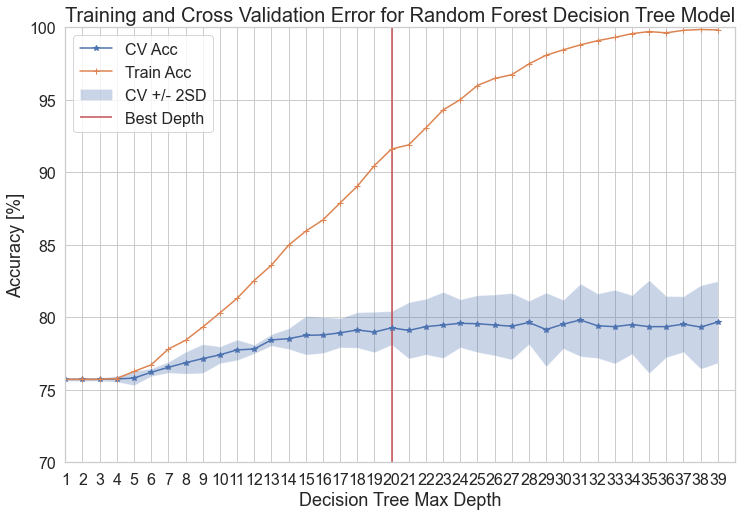

In [91]:
# now plot
fig = plt.figure(figsize=(12,8))
plt.plot(depths, cvmeans, '*-', label="CV Acc")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3, label='CV +/- 2SD')
ylim = plt.ylim()
plt.plot(depths, train_scores, '-+', label="Train Acc")
plt.vlines(20, 70, 100, color = 'r', label = f'Best Depth')
plt.legend(fontsize=16)
plt.title("Training and Cross Validation Error for Random Forest Decision Tree Model", fontsize=20)
plt.ylabel("Accuracy [%]", fontsize=18)
plt.xlabel("Decision Tree Max Depth", fontsize=18)
plt.xticks(depths)
plt.tick_params(labelsize=16)
plt.ylim(70, 100)
plt.xlim(1, 40)
plt.show()

In [92]:
# initialize
tree_depth = 20
#seed = 0
n_estimators = round(np.sqrt(X_train.shape[1]))

random_forest = RandomForestClassifier(max_depth=tree_depth, 
                                       random_state=random_state,
                                       max_features='sqrt',
                                       n_estimators=n_estimators)

# Fit the model on the training set
random_forest.fit(X_train, y_train)

# scores
random_forest_train_accuracy = random_forest.score(X_train, y_train)
random_forest_test_accuracy = random_forest.score(X_test, y_test)

# Format to percentages
rf_train_accuracy_perc = random_forest_train_accuracy * 100
rf_test_accuracy_perc = random_forest_test_accuracy * 100

# print results
print(f'Random Forest Train Accuracy: {rf_train_accuracy_perc:.2f}%')
print(f'Random Forest Test Accuracy: {rf_test_accuracy_perc:.2f}%')

Random Forest Train Accuracy: 90.78%
Random Forest Test Accuracy: 77.96%


### Neural Net

In [93]:
# Scale the data ->  Needs to happen afterwards;
# else scaling would influence both sets which should be totally seperated
scaler = StandardScaler()

# Transform data -> All to np arrays and x scaled
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# The number of nodes in a hidden layer
n_hidden = 5
# The number of nodes in the input layer (features)
n_input = len(X_train.columns)
# The number of nodes in the output layer
n_output = 1

# First we instantiate a Keras model
NN_model = models.Sequential(name='ANN')

# Adding Layers
NN_model.add(layers.Dense(n_hidden, 
                          activation='relu', 
                          input_shape=[n_input,], 
                          name='hidden1'))
NN_model.add(layers.Dense(n_hidden, 
                          activation='relu',  
                          name='hidden2'))

# Now add the output layer
NN_model.add(layers.Dense(n_output, 
                          activation='sigmoid',  
                          name='output'))

# Early stopping for overfitting
callback = EarlyStopping(patience=10)

# Maximum epochs to try 
epochs = 100

# Compilation
NN_model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'],
                 #callbacks=[callback]
                )

#View model summary
#display(NN_model.summary())

#Fit the model on the training data
history_NN = NN_model.fit(X_train_scaled, 
             y_train.values, 
             epochs=epochs,
             verbose=2,
             validation_split=0.3)



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2445 samples, validate on 1048 samples
Epoch 1/100
2445/2445 - 0s - loss: 0.7166 - acc: 0.5751 - val_loss: 0.6633 - val_acc: 0.6737
Epoch 2/100
2445/2445 - 0s - loss: 0.6251 - acc: 0.7084 - val_loss: 0.6157 - val_acc: 0.7261
Epoch 3/100
2445/2445 - 0s - loss: 0.5723 - acc: 0.7436 - val_loss: 0.5832 - val_acc: 0.7405
Epoch 4/100
2445/2445 - 0s - loss: 0.5375 - acc: 0.7534 - val_loss: 0.5595 - val_acc: 0.7490
Epoch 5/100
2445/2445 - 0s - loss: 0.5107 - acc: 0.7640 - val_loss: 0.5414 - val_acc: 0.7557
Epoch 6/100
2445/2445 - 0s - loss: 0.4894 - acc: 0.7710 - val_loss: 0.5276 - val_acc: 0.7529
Epoch 7/100
2445/2445 - 0s - loss: 0.4725 - acc: 0.7771 - val_loss: 0.5161 - val_acc: 0.7605
Epoch 8/100
2445/2445 - 0s - loss: 0.4582 - acc: 0.7873 - val_loss: 0.5086 - val_acc: 0.7

Epoch 80/100
2445/2445 - 0s - loss: 0.3584 - acc: 0.8479 - val_loss: 0.5943 - val_acc: 0.7719
Epoch 81/100
2445/2445 - 0s - loss: 0.3583 - acc: 0.8474 - val_loss: 0.5918 - val_acc: 0.7710
Epoch 82/100
2445/2445 - 0s - loss: 0.3579 - acc: 0.8470 - val_loss: 0.5931 - val_acc: 0.7672
Epoch 83/100
2445/2445 - 0s - loss: 0.3577 - acc: 0.8487 - val_loss: 0.5936 - val_acc: 0.7662
Epoch 84/100
2445/2445 - 0s - loss: 0.3583 - acc: 0.8479 - val_loss: 0.5956 - val_acc: 0.7643
Epoch 85/100
2445/2445 - 0s - loss: 0.3569 - acc: 0.8487 - val_loss: 0.5949 - val_acc: 0.7615
Epoch 86/100
2445/2445 - 0s - loss: 0.3565 - acc: 0.8507 - val_loss: 0.5960 - val_acc: 0.7615
Epoch 87/100
2445/2445 - 0s - loss: 0.3561 - acc: 0.8483 - val_loss: 0.5966 - val_acc: 0.7653
Epoch 88/100
2445/2445 - 0s - loss: 0.3559 - acc: 0.8495 - val_loss: 0.5991 - val_acc: 0.7634
Epoch 89/100
2445/2445 - 0s - loss: 0.3553 - acc: 0.8495 - val_loss: 0.5995 - val_acc: 0.7615
Epoch 90/100
2445/2445 - 0s - loss: 0.3557 - acc: 0.8474 - v

In [94]:
# Evaluate on train and test and print accuracy results
NN_train_loss, NN_train_accuracy = NN_model.evaluate(X_train_scaled, y_train.values, verbose=0)
NN_test_loss, NN_test_accuracy = NN_model.evaluate(X_test_scaled, y_test.values, verbose=0)

# Create percentage based printable scores
train_nn_perc = round(NN_train_accuracy * 100, 2)
test_nn_perc = round(NN_test_accuracy *100 , 2)

# print results
print(f'\nThe training set accuracy for the model is: {train_nn_perc:.2f}%')
print(f'The test set accuracy for the model is: {test_nn_perc:.2f}%')


The training set accuracy for the model is: 82.59%
The test set accuracy for the model is: 75.48%


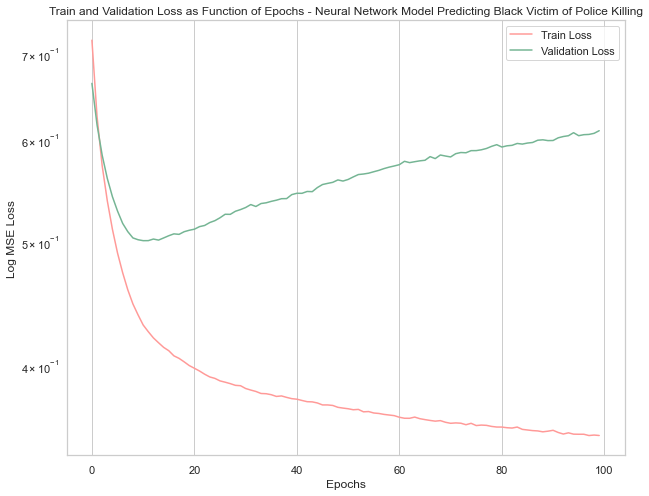

In [95]:
# plot train and val acc as a function of epochs
# your code here
# Plot the MSE of the model
plt.rcParams["figure.figsize"] = (10,8)
plt.title("Train and Validation Loss as Function of Epochs - Neural Network Model Predicting Black Victim of Police Killing")
plt.semilogy(history_NN.history['loss'], label='Train Loss', color='#FF9A98')
plt.semilogy(history_NN.history['val_loss'],  label='Validation Loss', color='#75B594')
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Log MSE Loss')
plt.legend()
plt.show()

KeyError: 'accuracy'

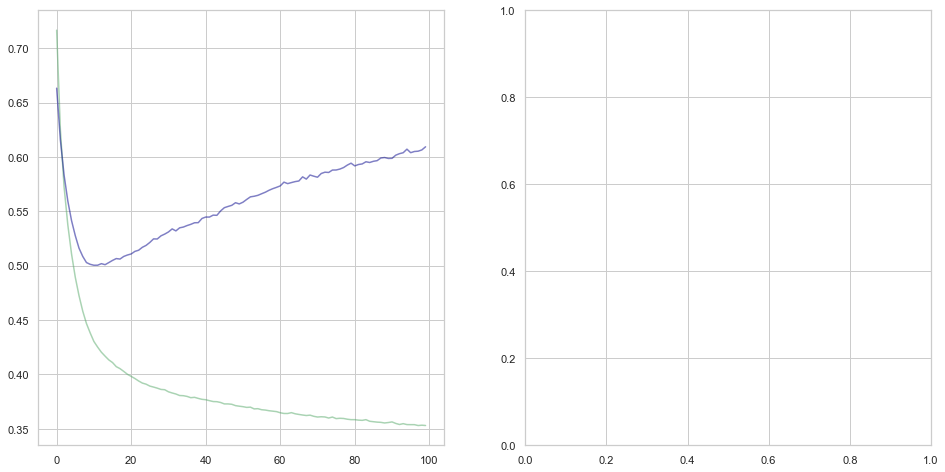

In [96]:
# plot train and val acc as a function of epochs

# your code here
fig, ax = plt.subplots(1,2,figsize = (16,8))
ax[0].plot(history_NN.history['loss'], 'g', alpha=0.5, label='Training Loss')
ax[0].plot(history_NN.history['val_loss'], 'darkblue', alpha=0.5, label='Validation Loss')
ax[1].plot(history_NN.history['accuracy'], 'g', alpha=0.5, label='Training Accuracy')
ax[1].plot(history_NN.history['val_accuracy'], 'darkblue', alpha=0.5, label='Validation Accuracy')
ax[0].legend(fontsize=16)
ax[1].legend(fontsize=16)
ax[0].set_xlabel('Epochs', fontsize = 16)
ax[0].set_ylabel('Loss', fontsize = 16)
ax[0].set_title('Loss Function vs. Epoch', fontsize = 16)
ax[1].set_xlabel('Epochs', fontsize = 16)
ax[1].set_ylabel('Accuracy %', fontsize = 16)
ax[0].set_ylim(0,2)
ax[1].set_title('Prediction Accuracy vs. Epoch', fontsize = 18)
fig.suptitle('Neural Network Model Predicting Black Victim of Police Killing', fontsize = 22)

In [ ]:
# compare various models
acc_dict_train = {'logit': logit_train_accuracy,
                #  'polyreg3': polyreg3_train_accuracy,
                  'logit_lasso_CV': logit_lasso_train_accuracy,
                  'random_forest': random_forest_train_accuracy, 
                  'neural_network': NN_train_accuracy
                 }
acc_dict_test = {'logit': logit_test_accuracy,
                # 'polyreg3': polyreg3_test_accuracy,
                 'logit_lasso_CV': logit_lasso_test_accuracy,
                 'random_forest': random_forest_test_accuracy,
                 'neural_network': NN_test_accuracy
                 }



# Look at our projections so far
X = np.arange(len(acc_dict_train))

fig = plt.figure(figsize=(12,8))
plt.scatter(X, acc_dict_train.values(), color='darkblue', label="Train Set", s = 75)
plt.scatter(X, acc_dict_test.values(), color='green', label='Test Set', s = 75)

plt.title('Test and Train Set Accuracy Scores of Various Models Predicting Black Victim of Police Killing',
          fontsize=18, pad=20)
plt.axvline(1, 0, 100, color = 'r', label = f'Best Test Model')
plt.xlabel('Model', fontsize=16)
plt.ylabel('Accuracy Score [%]', fontsize=16)
plt.xticks(X, acc_dict_train.keys())
plt.tick_params(labelsize=18)
plt.ylim(0.74,0.95)
plt.legend(fontsize=16)
plt.show()

In [ ]:
# your code here
# create predicted yhat variables
yhat_logit = logit.predict_proba(X_test)[:,1]
yhat_logit_lasso = logit_lasso.predict_proba(X_test)[:,1]
yhat_rf = random_forest.predict_proba(X_test)[:,1]
yhat_NN = NN_model.predict_proba(X_test_scaled)

# Get ROC metrics
fpr_logit, tpr_logit, thresholds_logit = roc_curve(y_test, yhat_logit)
fpr_logit_lasso, tpr_logit_lasso, thresholds_logit_lasso = roc_curve(y_test, yhat_logit_lasso)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, yhat_rf)
fpr_NN, tpr_NN, thresholds_NN = roc_curve(y_test, yhat_NN)

In [ ]:
# ROC Curve
x=np.arange(0,100)/100
plt.plot(x,x,'--',color="gray",alpha=0.3)
plt.plot(fpr_logit,tpr_logit,label="logit")
plt.plot(fpr_logit_lasso,tpr_logit_lasso,label="logit_lasso")
plt.plot(fpr_rf,tpr_rf,label="random_forest")
plt.plot(fpr_NN,tpr_NN,label="neural_network")
plt.ylabel("True Positive Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
plt.tick_params(labelsize=14)
plt.title("ROC Curve for Predicting Black Victim of Police Killing Across Various Models", fontsize=18)
plt.legend(fontsize=16)
plt.show()

### <div class='exercise' id='section_6'><b>Section 6: Other Supporting Models and Analysis</b></div>
[▲ Return to contents](#Contents)
<div class='exercise'>

</div>


This section will investigate additional models using the Washington Post and the Mapping Police Violence datasets.

#### Models
 * Logistic Regression baseline
 * Polynomial Features (3rd order) Regression
 * Lasso Regularized Model
 * Random Forest
 * Neural Net
 
#### attempts:
1. Predict mental illness based on other WaPo predictors.
2. Predict justification of shootings with police violence predictors
3. Adjusted model for mentall illness using different predictors


#### Moving on to Predicting Mental Illness
I'm really interested in understanding how mental illness factors into these crimes and subsequent shootings.

In [ ]:
display(df2.head())

# do we have any null values?
df2_encoded = df2.copy()
df2_encoded = df2_encoded.dropna()


from sklearn.preprocessing import LabelEncoder
# preprocess categorical
cat_vars = ['manner_of_death','armed', 'gender', 'race', 'city', 'state', 'threat_level', 
            'flee', 'body_camera', 'is_geocoding_exact', 'urban', 'year', 'inc_group']

le = LabelEncoder()
mapping = {}

# Assigning numerical values and storing in another column
for var in cat_vars:
    
    # transform categorical
    df2_encoded[var] = le.fit_transform(df2_encoded[var])
    
    # verify mappings for later filtering
    mapping[var] = dict(zip(le.classes_, le.transform(le.classes_)))

# mapping?
print("Mapping:")
print(mapping)

In [ ]:
# initialize
test_size = 0.2
random_state=42
# columns
display(df2_encoded.head())
# ['id', 'date', 'manner_of_death', 'armed', 'age', 'gender', 'race', 'city', 'state', 'signs_of_mental_illness', 
# 'threat_level', 'flee', 'body_camera', 'longitude', 'latitude', 'is_geocoding_exact']

# set X without response or unused predictors
X = df2_encoded.drop(['id', 'name', 'date', 'city', 'signs_of_mental_illness', 'is_geocoding_exact', 'latitude', 'longitude', 'city_lat_long'], axis=1)
y = df2_encoded['signs_of_mental_illness']


# Split train and test data
X_train, X_test, y_train, y_test  = train_test_split(X, 
                                                     y, 
                                                     test_size=test_size, 
                                                     random_state = random_state,
                                                     )

print("Initial Dataframe shape: ", df2_encoded.shape)
print("X_train shape: ", X_train.shape, "\nX_test shape: ", X_test.shape, "\ny_train shape: ", y_train.shape, "\ny_test shape: ", y_test.shape)


In [ ]:
# logistic regression model with L2 ridge regularization
logreg = LogisticRegression(penalty='l2',  
                            max_iter=2000,
                            C=1.0)

# fit on scaled training data
logreg.fit(X_train,y_train)

# Check accuracy score
logreg_train_accuracy = logreg.score(X_train, y_train)*100
logreg_test_accuracy = logreg.score(X_test, y_test)*100

# Print results
print("Ridge Model Accuracy Results:")
print(f'  Logisitic Train Accuracy: {logreg_train_accuracy:.2f}%')
print(f'  Logisitic Test Accuracy: {logreg_test_accuracy:.2f}%')

In [ ]:
# find predictors
importance = permutation_importance(logreg,
                                    X_train,
                                    y_train,
                                    n_repeats=5
                                   )

# take top 10
#importance = np.sort(importance)[:10]
cols = X.columns

# summarize feature importance
#for i,v in enumerate(importance.importances_mean):
#    print(f'Feature {i}: {cols[i]}   Score: {v:.4f}')

# plot feature importance
fig = plt.figure(figsize=(10,8))
plt.bar([x for x in range(len(importance.importances_mean))], importance.importances_mean, color='darkblue', label='all predictors')
plt.title('Logistic Regression Feature Importance', fontsize=22)
plt.xticks(np.arange(len(cols)), cols, rotation=45, horizontalalignment='right')
plt.ylabel('Importance', fontsize=16)
plt.xlabel('Predictors', fontsize=16)
plt.tick_params(labelsize=14)
plt.legend()
plt.show()

In [ ]:
# predict using test set
y_pred_test = logreg.predict(X_test)
y_pred_wh = logreg.predict(X_test[y_test==0])
y_pred_bl = logreg.predict(X_test[y_test==1])

# get performance by class
print('\nOverall Test Set Performance')
cm1 = pd.crosstab(y_test, 
                  y_pred_test, 
                  margins=True, 
                  rownames=['Actual'], 
                  colnames=['Predicted'])
display(cm1)

In [ ]:
# Try polynomial features up to 3rd order polynomials
degree = 3

# define data
X_train_poly = PolynomialFeatures(degree=degree,
                                  include_bias=False).fit_transform(X_train)
X_test_poly = PolynomialFeatures(degree=degree,
                                 include_bias=False).fit_transform(X_test)
# fit model
polyreg3 = LogisticRegression(penalty='none', 
                              max_iter = 5000).fit(X_train_poly, y_train)

# Check accuracy score
polyreg3_train_accuracy = polyreg3.score(X_train_poly, y_train)*100
polyreg3_test_accuracy = polyreg3.score(X_test_poly, y_test)*100

# Print results
print("Polynomial Features Logistic Regression Model Accuracy Results:")
print(f'  Logisitic Train Accuracy with 3rd Order Polynomial Features: {polyreg3_train_accuracy:.2f}%')
print(f'  Logisitic Test Accuracy with 3rd Order Polynomial Features: {polyreg3_test_accuracy:.2f}%')

In [ ]:
# Try Regularized Model
# Best model based on cross validation accuracy
c = 1

# generate model
logit_lasso = LogisticRegression(C=c, 
                                 penalty='l1', 
                                 solver='saga', 
                                 max_iter = 5000).fit(X_train, y_train)

#Perfromance Evaluation
logit_lasso_train_accuracy = logit_lasso.score(X_train, y_train)*100
logit_lasso_test_accuracy = logit_lasso.score(X_test, y_test)*100

# Beta Values
intercept = logit_lasso.intercept_[0]
betas = logit_lasso.coef_[0]

# Print results
print("Best (C=100) Lasso Model Estimated Coefficients:")
print(f'Intercept: {intercept:.4f}')
#for idx, val in enumerate(betas):
    #print(f'Beta {idx+1} value: {val:.4f}')
print(f'Best Lasso Train Accuracy: {logit_lasso_train_accuracy:.2f}%')
print(f'Best Lasso Test Accuracy: {logit_lasso_test_accuracy:.2f}%')

In [ ]:
# initialize
tree_depth = 10
seed = 0
n_estimators = 55

random_forest = RandomForestClassifier(max_depth=tree_depth, 
                                       #random_state=seed,
                                       max_features='sqrt',
                                       n_estimators=n_estimators)

# Fit the model on the training set
random_forest.fit(X_train, y_train)

# scores
random_forest_train_accuracy = random_forest.score(X_train, y_train)*100
random_forest_test_accuracy = random_forest.score(X_test, y_test)*100

# print results
print(f'Random Forest Train Accuracy: {random_forest_train_accuracy:.2f}%')
print(f'Random Forest Test Accuracy: {random_forest_test_accuracy:.2f}%')

In [ ]:
# try neural net

# couple extra imports
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

# initialize
# The number of nodes in a hidden layer
n_hidden = 15
# The number of nodes in the input layer (features)
n_input = len(X_train.columns)
# The number of nodes in the output layer
n_output = 1

# First we instantiate a Keras model
NN_model = models.Sequential(name='ANN')

# Adding Layers
NN_model.add(layers.Dense(n_hidden, 
                          activation='relu', 
                          input_shape=[n_input,], 
                          name='hidden1'))
NN_model.add(layers.Dense(n_hidden, 
                          activation='relu',  
                          name='hidden2'))

# Now add the output layer
NN_model.add(layers.Dense(n_output, 
                          activation='sigmoid',  
                          name='output'))

# initialize
epochs = 200

# Compilation
NN_model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

#View model summary
display(NN_model.summary())

#Fit the model on the training data
NN_model.fit(X_train, 
             y_train, 
             epochs=epochs,
             verbose=0,
             validation_split=0.2)

# evaluate
NN_train_accuracy = NN_model.evaluate(X_train,y_train)[1]*100
NN_test_accuracy = NN_model.evaluate(X_test,y_test)[1]*100

# print results
print(f'\nThe training set accuracy for the model is: {NN_train_accuracy:.2f}%')
print(f'The test set accuracy for the model is: {NN_test_accuracy:.2f}%')

In [ ]:
# compare various models
acc_dict_train = {'logreg': logreg_train_accuracy,
                  'polyreg3': polyreg3_train_accuracy,
                  'logit_lasso': logit_lasso_train_accuracy,
                  'random_forest': random_forest_train_accuracy, 
                  'neural_network': NN_train_accuracy
                 }
acc_dict_test = {'logreg': logreg_test_accuracy,
                 'polyreg3': polyreg3_test_accuracy,
                 'logit_lasso': logit_lasso_test_accuracy,
                 'random_forest': random_forest_test_accuracy,
                 'neural_network': NN_test_accuracy
                 }


# Look at our projections so far
X = np.arange(len(acc_dict_train))

fig = plt.figure(figsize=(12,8))
plt.plot(X, acc_dict_train.values(), '--.', color='g', label="Training")
plt.plot(X, acc_dict_test.values(), '--.', color='darkblue', label='Testing')
plt.title('Predicting Mental Health Issues using All Fatal Police Shooting Predictors', fontsize=20)
plt.axvline(3, 0, 100, color = 'r', label = f'Best Test Model')
plt.xlabel('Model', fontsize=16)
plt.ylabel('Accuracy Score [%]', fontsize=16)
plt.tick_params(labelsize=14)
plt.xticks(X, acc_dict_train.keys())
plt.ylim(55,85)
plt.legend(fontsize=16)
plt.show()

### Attempt 2

#### Predicting Justification of Violence by Race 
All of the above models were marginal at best, displaying no clear relationship between predictors and race

In [ ]:
# preprocess categorical

cat_vars = ["Victim's gender","Victim's race", 'State', 'Cause of death', 
            'Official disposition of death (justified or other)', 'Criminal Charges?', 'Symptoms of mental illness?', 
            'Unarmed/Did Not Have an Actual Weapon', 'Alleged Weapon', 'Alleged Threat Level (Source: WaPo)', 
            'Fleeing (Source: WaPo)', 'Body Camera (Source: WaPo)', 'geography', 'year']

le = LabelEncoder()
mapping = {}

# Assigning numerical values and storing in another column
for var in cat_vars:
    
    # transform categorical
    df1[var] = le.fit_transform(df1[var])
    
    # verify mappings for later filtering
    mapping[var] = dict(zip(le.classes_, le.transform(le.classes_)))

# mapping?
print("Mapping:")
print(mapping)

In [ ]:
# initialize
test_size = 0.2
random_state=42

# columns
# ['Victim's age', 'Victim's gender', 'Victim's race', 'Date of Incident (month/day/year)', 'City', 'State', 
#'Zipcode', 'County', 'Agency responsible for death', 'Cause of death', 
# 'Official disposition of death (justified or other)', 'Criminal Charges?', 'Symptoms of mental illness?', 
#'Unarmed/Did Not Have an Actual Weapon', 'Alleged Weapon', 'Alleged Threat Level (Source: WaPo)', 
#'Fleeing (Source: WaPo)', 'Body Camera (Source: WaPo)', 'WaPo ID (If included in WaPo database)', 
#'geography', 'MPV ID', 'Fatal Encounters ID', 'Criminal Charges?_bool', 'Symptoms of mental illness?_bool', 
#'Unarmed/Did Not Have an Actual Weapon_bool', 'Fleeing (Source: WaPo)_bool', 'Body Camera (Source: WaPo)_bool', 'year']

# set X without response or unused predictors
X = df1.drop(['Date of Incident (month/day/year)', 'City', 'Zipcode', 'County', 'Agency responsible for death', 
              'WaPo ID (If included in WaPo database)', 'MPV ID', 'Fatal Encounters ID', 
              'Official disposition of death (justified or other)'], axis=1)
y = df1['Official disposition of death (justified or other)']


# Split train and test data
X_train, X_test, y_train, y_test  = train_test_split(X, 
                                                     y, 
                                                     test_size=test_size, 
                                                     random_state = random_state,
                                                     stratify=df1["Victim's race"]
                                                     )

print("Initial Dataframe shape: ", df1.shape)
print("X_train shape: ", X_train.shape, "\nX_test shape: ", X_test.shape, "\ny_train shape: ", y_train.shape, "\ny_test shape: ", y_test.shape)

In [ ]:
# logistic regression model with L2 ridge regularization
logreg = LogisticRegression(penalty='l2',  
                            max_iter=2000,
                            C=1.0)

# fit on scaled training data
logreg.fit(X_train,y_train)

# Check accuracy score
logreg_train_accuracy = logreg.score(X_train, y_train)*100
logreg_test_accuracy = logreg.score(X_test, y_test)*100

# Print results
print("Ridge Model Accuracy Results:")
print(f'  Logisitic Train Accuracy: {logreg_train_accuracy:.2f}%')
print(f'  Logisitic Test Accuracy: {logreg_test_accuracy:.2f}%')

In [ ]:
# find predictors
importance = permutation_importance(logreg,
                                    X_train,
                                    y_train,
                                    n_repeats=5
                                   )

# take top 10
#importance = np.sort(importance)[:10]
cols = X_train.columns

# summarize feature importance
#for i,v in enumerate(importance.importances_mean):
#    print(f'Feature {i}: {cols[i]}   Score: {v:.4f}')

# plot feature importance
fig = plt.figure(figsize=(10,8))
plt.bar([x for x in range(len(importance.importances_mean))], importance.importances_mean, color='darkblue', label='all predictors')
plt.title('Logistic Regression Feature Importance', fontsize=22)
plt.xticks(np.arange(len(cols)), cols, rotation=45, horizontalalignment='right')
plt.ylabel('Importance', fontsize=16)
plt.xlabel('Predictors', fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [ ]:
# predict using test set
y_pred_test = logreg.predict(X_test)


# get performance by class
print('\nOverall Test Set Performance')
cm1 = pd.crosstab(y_test, 
                  y_pred_test, 
                  margins=True, 
                  rownames=['Actual'], 
                  colnames=['Predicted'])
display(cm1)

In [ ]:
# Try polynomial features up to 3rd order polynomials
degree = 3

# define data
X_train_poly = PolynomialFeatures(degree=degree,
                                  include_bias=False).fit_transform(X_train)
X_test_poly = PolynomialFeatures(degree=degree,
                                 include_bias=False).fit_transform(X_test)
# fit model
polyreg3 = LogisticRegression(penalty='none', 
                              max_iter = 2000).fit(X_train_poly, y_train)

# Check accuracy score
polyreg3_train_accuracy = polyreg3.score(X_train_poly, y_train)*100
polyreg3_test_accuracy = polyreg3.score(X_test_poly, y_test)*100

# Print results
print("Polynomial Features Logistic Regression Model Accuracy Results:")
print(f'  Logisitic Train Accuracy with 3rd Order Polynomial Features: {polyreg3_train_accuracy:.2f}%')
print(f'  Logisitic Test Accuracy with 3rd Order Polynomial Features: {polyreg3_test_accuracy:.2f}%')

In [ ]:
# Try Regularized Model
c = 1

# generate model
logit_lasso = LogisticRegression(C=c, 
                                 penalty='l1', 
                                 solver='saga', 
                                 max_iter = 2000).fit(X_train, y_train)

#Perfromance Evaluation
logit_lasso_train_accuracy = logit_lasso.score(X_train, y_train)*100
logit_lasso_test_accuracy = logit_lasso.score(X_test, y_test)*100

# Beta Values
intercept = logit_lasso.intercept_[0]
betas = logit_lasso.coef_[0]

# Print results
print("Best (C=100) Lasso Model Estimated Coefficients:")
print(f'Intercept: {intercept:.4f}')
#for idx, val in enumerate(betas):
    #print(f'Beta {idx+1} value: {val:.4f}')
print(f'Best Lasso Train Accuracy: {logit_lasso_train_accuracy:.2f}%')
print(f'Best Lasso Test Accuracy: {logit_lasso_test_accuracy:.2f}%')

In [ ]:
# initialize
tree_depth = 10
seed = 0
n_estimators = 55

random_forest = RandomForestClassifier(max_depth=tree_depth, 
                                       #random_state=seed,
                                       max_features='sqrt',
                                       n_estimators=n_estimators)

# Fit the model on the training set
random_forest.fit(X_train, y_train)

# scores
random_forest_train_accuracy = random_forest.score(X_train, y_train)*100
random_forest_test_accuracy = random_forest.score(X_test, y_test)*100

# print results
print(f'Random Forest Train Accuracy: {random_forest_train_accuracy:.2f}%')
print(f'Random Forest Test Accuracy: {random_forest_test_accuracy:.2f}%')

In [ ]:
# compare various models
acc_dict_train = {'logreg': logreg_train_accuracy,
                  'polyreg3': polyreg3_train_accuracy,
                  'logit_lasso': logit_lasso_train_accuracy,
                  'random_forest': random_forest_train_accuracy, 
                  #'neural_network': NN_train_accuracy
                 }
acc_dict_test = {'logreg': logreg_test_accuracy,
                 'polyreg3': polyreg3_test_accuracy,
                 'logit_lasso': logit_lasso_test_accuracy,
                 'random_forest': random_forest_test_accuracy,
                 #'neural_network': NN_test_accuracy
                 }


# Look at our projections so far
X = np.arange(len(acc_dict_train))

fig = plt.figure(figsize=(12,8))
plt.plot(X, acc_dict_train.values(), '--.', color='g', label="Training")
plt.plot(X, acc_dict_test.values(), '--.', color='darkblue', label='Testing')
plt.title('Predicting Judicial Outcome of Whether Killing Was Justified', fontsize=22)
plt.axvline(3, 0, 100, color = 'r', label = f'Best Test Model')
plt.xlabel('Model', fontsize=16)
plt.ylabel('Accuracy Score [%]', fontsize=16)
plt.tick_params(labelsize=14)
plt.xticks(X, acc_dict_train.keys())
plt.ylim(60,85)
plt.legend(fontsize=16)
plt.show()

### Attempt 3

#### One more Model attempting to predict Mental Illness
New model using different predictors to attempt to make better predictions for mental illness

In [ ]:
races_keep = ['B']
df2['is_african_american'] = df2['race'].isin(races_keep).astype(np.int8)
df2['is_african_american'].value_counts()

df3 = df2.drop(['date', 'longitude', 'latitude', 'city',
                'index', 'id', 'state', 'inc_coor_dist_match', 
                'is_geocoding_exact','year', 'race', 'city_lat_long'], axis=1)

df3.head()

In [ ]:
nan_row_stats(df3)
nan_vals_stats(df3)

In [ ]:
# Drop null values
df4 = df3.dropna()
nan_vals_stats(df4)

In [ ]:
# Custom one hot encoding function for non numerical columns/features
def one_hot_encode(df_one_hot, cols, drop_orig = False, force_lc = False, output_stats = True):
    encoded_cols_added = 0
    amount_cols_before = len(df_one_hot.columns)
    
    for col in cols:
        dummies = pd.get_dummies(df_one_hot[col], prefix=col)
        print(f"Predictor '{col}' has {len(dummies.columns)} categories added")
        df_one_hot = pd.concat([df_one_hot, dummies], axis=1)
        encoded_cols_added += len(dummies.columns)
    
    # Drop original columns
    if drop_orig:
        df_one_hot = df_one_hot.drop(cols, axis=1)
    
    # Output changes made
    if output_stats:
        print(f"Dropped original -> {drop_orig}")
        print(f"Added {encoded_cols_added} one hot encoded cols.")
        print(f"Started with {amount_cols_before} to a total of {len(df_one_hot.columns)} columns")
    
    # Lowercase all columns if required
    if force_lc:
        df_one_hot.columns= df_one_hot.columns.str.lower()
    
    return df_one_hot

In [ ]:
# Categorical variables to process
cat_vars = ['manner_of_death','armed', 'gender', 
            'threat_level', 'flee', 'body_camera', 'urban', 'inc_group']


# Enocde all the data
encoded_df = one_hot_encode(df4, cat_vars, drop_orig = True, force_lc = True)

# Validate data mutation and output the rest
display(encoded_df.head())

### Create model data

In [ ]:
# Grab predictors, response and stratify variable
X = encoded_df.drop(['signs_of_mental_illness', 'name'], axis=1)
y = encoded_df[['signs_of_mental_illness']]

# Create series to make sure is_african_american and mental_illness are stratified
# https://stackoverflow.com/a/51525992/8970591
strat_mental_health_aa = encoded_df['signs_of_mental_illness'].astype(str) + \
                         encoded_df['is_african_american'].astype(str)



# Split the data 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    stratify=strat_mental_health_aa,
                                                    random_state=42)


# Lastly output the shapes for validation
print("Shape all data:")
print(encoded_df.shape)

print("\nShape X_train and y_train:")
print(X_train.shape, y_train.shape)

print("\nShape X_test and y_test:")
print(X_test.shape, y_test.shape)

In [ ]:
# Re-usable function to output the model's coefficents and intercept
def output_model_coef(model, predictors, reg_type = "Logisitc"):
    # Get the coefficient estimates
    for i in range(len(predictors)):
        if i == 0:
            print(f"{reg_type} Regression est. B0 (Intercept): {model.intercept_[0]:.4f}")

        coef_val = model.coef_.flat[i]
        print(f"{reg_type} Regression est. B{i + 1} ({predictors[i]}): {coef_val:.4f}")

In [ ]:
# Values to use
Cs = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4]
penalty = 'l1' # l1 -> L1 -> LASSO
solver = 'liblinear' # -> You will get warning because LASSO can only work with this solver
folds = 3

# Fit a well-tuned Lasso-like logistic regression model from all 12 predictors in it
# The default scoring option used is accuracy_score
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
logit_lasso = LogisticRegressionCV(
    Cs=Cs, cv=folds, penalty=penalty, solver='liblinear'
).fit(X_train, y_train)

# Print out the coefficient estimates
output_model_coef(logit_lasso, X.columns, "Lasso-like Logistic Regression")

# Get the classification scores
logit_lasso_train_score = logit_lasso.score(X_train, y_train) * 100
logit_lasso_test_score = logit_lasso.score(X_test, y_test) * 100

# Add a new line for better readability of the output
print("\n")

# Report the classification accuracy on train and test for this model.
print(f"Training Set Accuracy Lasso-like Logistic Regression full: {logit_lasso_train_score:.4f}%")
print(f"Testing Set Accuracy Lasso-like Logistic Regression full: {logit_lasso_test_score:.4f}%")

In [ ]:
# Custom function to visualize importance predictors
def preds_importance_barchart(lasso_coef, preds):
    # Create a bar chart to visualize importance of our scaled predictors
    fig, ax = plt.subplots(figsize = (14,6),facecolor='w')

    ax.bar(np.arange(lasso_coef.size), lasso_coef)
    ax.set_xticks(np.arange(len(preds)))
    ax.set_xticklabels(preds,  rotation=45, ha="right", rotation_mode="anchor")

    # Add the labelsb
    ax.set_title('Importance bar chart standadized Lasso-like Logistic Regression full',fontsize= 15)
    ax.set_xlabel('Beta est.', fontsize=15)
    ax.set_ylabel('Predictor', fontsize=15)
    

    
# Grab the coefficients
lasso_coef = logit_lasso.coef_[0]
preds_importance_barchart(lasso_coef, X.columns)

In [ ]:
# You can use the default number of n_repeats (5) and your estimator's default scorer
# To speed up the time it takes to run your permutations, you can try setting n_jobs=-1
# to take full advantage of all of your available processor cores.
per_imp_train = permutation_importance(logit_lasso, X_train, y_train, 
                                n_repeats=5, # Default
                                scoring='accuracy',
                                n_jobs=-1, #Takes as many threads as possible
                                random_state=42)

# https://scikit-learn.org/0.22/auto_examples/inspection/plot_permutation_importance.html
len_data = len(per_imp_train.importances_mean) # Needed for negative indexing
sorted_per_imp_index = per_imp_train.importances_mean.argsort()[-10:len_data]

# Get the actual mean permutation importance values and their corresponding feature names
relat_imp_feat_names = X.columns[sorted_per_imp_index]
relat_imp_means = per_imp_train.importances_mean[sorted_per_imp_index].tolist()

# Get the plots ready
fig, ax = plt.subplots(figsize = (14,8))

y_ticks = np.arange(0, len(relat_imp_feat_names))
ax.barh(y_ticks, relat_imp_means)
ax.set_yticklabels(relat_imp_feat_names)
ax.set_yticks(y_ticks)
ax.set_title("Train Permutation Importances", fontsize=20)
fig.tight_layout()
plt.show()


In [ ]:
# Get indices per race     
race_indices_c = X_test["is_african_american"] == 1
race_indices_aa = X_test["is_african_american"] == 0

# Reshape
y_train_shape = y_train.values.reshape(-1,)
y_test_shape = y_test.values.reshape(-1,)

# Match true values per race
y_test_race_c = y_test_shape[race_indices_c]
y_test_race_aa = y_test_shape[race_indices_aa]
print(y_test_race_c)
print(y_test_race_aa)


def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1

    return (TP, FP, TN, FN)


def get_fp_race_groups(y_true, y_pred):
    # Get the values we need
    TP, FP, TN, FN = perf_measure(y_true, y_pred)
    
    # FPR -> False postive rate
    # It’s the probability that a false alarm will be raised
    # that a positive result will be given when the true value is negative.
    FPR = FP/(FP+TN)
    
    # FNR -> False negative rate -> Miss rate
    # The probability that a true positive will be missed by the test.
    FNR = FN/(FN+TP)
    
    return FPR, FNR


# https://stackoverflow.com/a/53124075/8970591
def percentage(part,whole):
    if whole == 0:
        if part == 0:
            return float("nan")
        return float("inf")
    return float(part) / float(whole)



def output_error_scores(logit, X_test_logit, logit_name=""):
    # Get the predictions
    y_test_preds = logit.predict(X_test_logit)

    # Match race based predictions
    y_pred_race_c = y_test_preds[race_indices_c]
    y_pred_race_aa = y_test_preds[race_indices_aa]

    # 2) False Positive Rate(FPR) as a percentage for the groups (*note a positive here is two_year_recid==1)
    # 3) False Negative Rate(FNR) as a percentage for the groups
    # Get both rates
    FPR_race_c, FNR_race_c = get_fp_race_groups(y_test_race_c, y_pred_race_c)
    FPR_race_aa, FNR_race_aa = get_fp_race_groups(y_test_race_aa, y_pred_race_aa)

    # Output FPR & FNR results
    print(f"Log. Regress ({logit_name}) -> False Positive Rate(FPR) Non African-American: \t{FPR_race_c}")
    print(f"Log. Regress ({logit_name}) -> False Negative Rate(FNR) Non African-American: \t{FNR_race_c} \n")
    print(f"Log. Regress ({logit_name}) -> False Positive Rate(FPR) African-American: \t{FPR_race_aa}")
    print(f"Log. Regress ({logit_name}) -> False Negative Rate(FNR) African-American: \t{FNR_race_aa} \n")

    # 4) Ratios of Error Rates:
    ratio_err_rate_FPR = percentage(FPR_race_aa,  FPR_race_c)
    ratio_err_rate_FNR = percentage(FNR_race_aa, FNR_race_c)

    # Ouput the restults
    print(f"Log. Regress ({logit_name}) -> Ratio of the FPR between African-American and Non African-American groups: \t{ratio_err_rate_FPR}")
    print(f"Log. Regress ({logit_name}) -> Ratio of the FNR between African-American and Non African-American groups: \t{ratio_err_rate_FNR}")

In [ ]:
# Report all the scores
output_error_scores(logit_lasso, X_test, logit_name="LASSO Mental health")

In [ ]:
# Get the predicted probabilities
y_pred_proba = logit_lasso.predict_proba(X_test)
y_pred_proba_race_c = y_pred_proba[race_indices_c][:,1]
y_pred_proba_race_aa = y_pred_proba[race_indices_aa][:,1]

# Create a bar chart to visualize importance of our scaled predictors
fig, ax = plt.subplots(figsize = (14,10),facecolor='w')

# Get ROC curve metrics
fpr_c, tpr_c, thresholds_c = roc_curve(y_test_race_c, y_pred_proba_race_c)
fpr_aa, tpr_aa, thresholds_aa = roc_curve(y_test_race_aa, y_pred_proba_race_aa)

# Add ROC lines to the plot
ax.plot(fpr_c, tpr_c, label='Non African-American')
ax.plot(fpr_aa, tpr_aa, label='African-American')

# Log the model's AUC for both races
print(F"Log. Regress (no race) -> AUC for Causcasian:       \t{auc(fpr_c, tpr_c)}")
print(F"Log. Regress (no race) -> AUC for African-American: \t{auc(fpr_aa, tpr_aa)}")

# Add coin flip indicator, so 50/50
x=np.arange(0,100)/100
plt.plot(x,x,'--',color="gray",alpha=0.3)

# Add the labels and show the graph
ax.set_ylabel("True Positive Rate (Sensitivity)",fontsize= 15)
ax.set_xlabel("False Positive Rate (1 - Specificity)",fontsize= 15)
ax.set_title("Comparative ROC plot for 2 different races on the Test set for Log. Regress (no race)",fontsize= 20)
ax.legend()
plt.show()

### End of Notebook